# Import and settings

In [26]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 4
momentum = 0.9
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [27]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [28]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 800:200:69000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [29]:
n_train = 1000
n_val = 1000
n_test = 10000
n_unlabeled = 58000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


## Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）

In [30]:
y_pseudo = np.load('./save/pseudo_label_supervised.npy')

X_unlabeled = X_test[:58000]
y_unlabeled = y_test[:58000]
y_pseudo = y_pseudo[:58000]
X_test = X_test[58000:]
y_test = y_test[58000:]

print(X_unlabeled.shape, y_unlabeled.shape, y_pseudo.shape, X_test.shape, y_test.shape)

(58000, 28, 28, 1) (58000, 10) (58000, 10) (10000, 28, 28, 1) (10000, 10)


# Define a network

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [32]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, y_dash, ratio_pl, hard, transform):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dash = X_dash
        self.y_dash = y_dash
        self.ratio_pl = ratio_pl
        self.hard = hard
        self.transform = transform
        
    def __getitem__(self, index):
        if index < len(self.X_train):
            img = self.X_train[index]
            target = torch.Tensor(self.y_train[index].astype(float))
        else:
            index = np.random.randint(0, len(self.X_dash))
            img = self.X_dash[index]
            if self.hard:
                hard_label = int(np.argmax(self.y_dash[index]))
                zeros = np.zeros_like(self.y_dash[index])
                zeros[hard_label] = 1.0
                target = torch.Tensor(zeros)
            else:
                target = torch.Tensor(self.y_dash[index].astype(float))
        
        img = self.transform(img)
        return img, target
    
    def __len__(self):
        return int(len(self.X_train) * (1 + ratio_pl))

# Define TrainingTracker

In [33]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [34]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, unlabeled=False, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)

    if unlabeled:
        acc = acc_sum / n_unlabeled
        loss = loss_sum / n_unlabeled
        logger.info(
            'UnlabeledAcc: {0:.4f} | '
            'UnlabeledLoss: {1:.4f} '.format(
                acc, loss)
        )
    else:
        acc = acc_sum / n_test
        loss = loss_sum / n_test
        logger.info(
            'TestAcc: {0:.4f} | '
            'TestLoss: {1:.4f} '.format(
                acc, loss)
        )
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
        
    return acc, loss

# Experiments

## Hard Pseudo Label

[2017-12-03 01:23:30,804 INFO] Epoch: 0 | TrainAcc: 0.1650 | TrainLoss: 0.2293
[2017-12-03 01:23:31,198 INFO] Epoch: 0 | ValAcc: 0.2420 | ValLoss: 0.2165 

[2017-12-03 01:23:32,465 INFO] Epoch: 1 | TrainAcc: 0.3375 | TrainLoss: 0.1921
[2017-12-03 01:23:32,813 INFO] Epoch: 1 | ValAcc: 0.4400 | ValLoss: 0.1682 

[2017-12-03 01:23:34,234 INFO] Epoch: 2 | TrainAcc: 0.4840 | TrainLoss: 0.1498
[2017-12-03 01:23:34,632 INFO] Epoch: 2 | ValAcc: 0.4760 | ValLoss: 0.1361 

[2017-12-03 01:23:36,024 INFO] Epoch: 3 | TrainAcc: 0.5435 | TrainLoss: 0.1294
[2017-12-03 01:23:36,383 INFO] Epoch: 3 | ValAcc: 0.4910 | ValLoss: 0.1631 

[2017-12-03 01:23:37,741 INFO] Epoch: 4 | TrainAcc: 0.6620 | TrainLoss: 0.1020
[2017-12-03 01:23:38,127 INFO] Epoch: 4 | ValAcc: 0.7440 | ValLoss: 0.0803 

[2017-12-03 01:23:39,430 INFO] Epoch: 5 | TrainAcc: 0.7825 | TrainLoss: 0.0636
[2017-12-03 01:23:39,790 INFO] Epoch: 5 | ValAcc: 0.7850 | ValLoss: 0.0690 

[2017-12-03 01:23:41,086 INFO] Epoch: 6 | TrainAcc: 0.8330 | Tra

[2017-12-03 01:24:56,972 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:24:57,374 INFO] Epoch: 52 | ValAcc: 0.9100 | ValLoss: 0.0386 

[2017-12-03 01:24:58,660 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:24:59,024 INFO] Epoch: 53 | ValAcc: 0.9080 | ValLoss: 0.0382 

[2017-12-03 01:25:00,300 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:25:00,652 INFO] Epoch: 54 | ValAcc: 0.9080 | ValLoss: 0.0385 

[2017-12-03 01:25:01,946 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:25:02,302 INFO] Epoch: 55 | ValAcc: 0.9080 | ValLoss: 0.0386 

[2017-12-03 01:25:03,575 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:25:03,933 INFO] Epoch: 56 | ValAcc: 0.9060 | ValLoss: 0.0389 

[2017-12-03 01:25:05,213 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:25:05,628 INFO] Epoch: 57 | ValAcc: 0.9090 | ValLoss: 0.0386 

[2017-12-03 01:25:06,963 INFO] Epoch: 58 | TrainAcc:

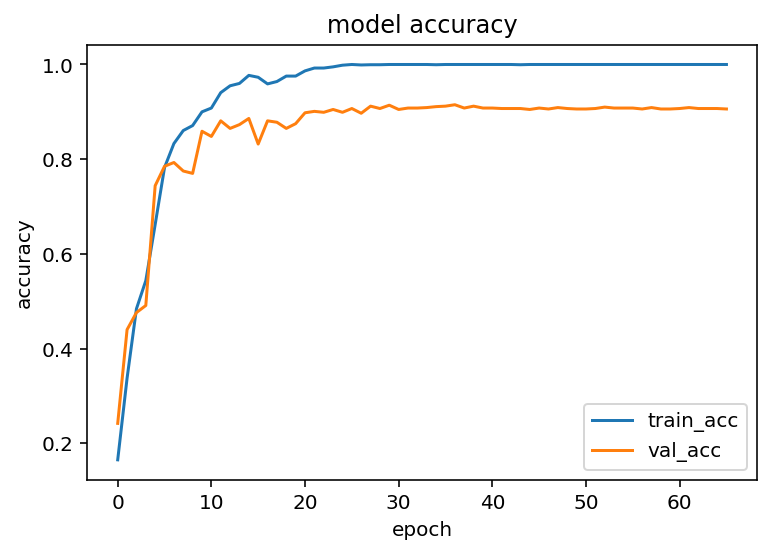

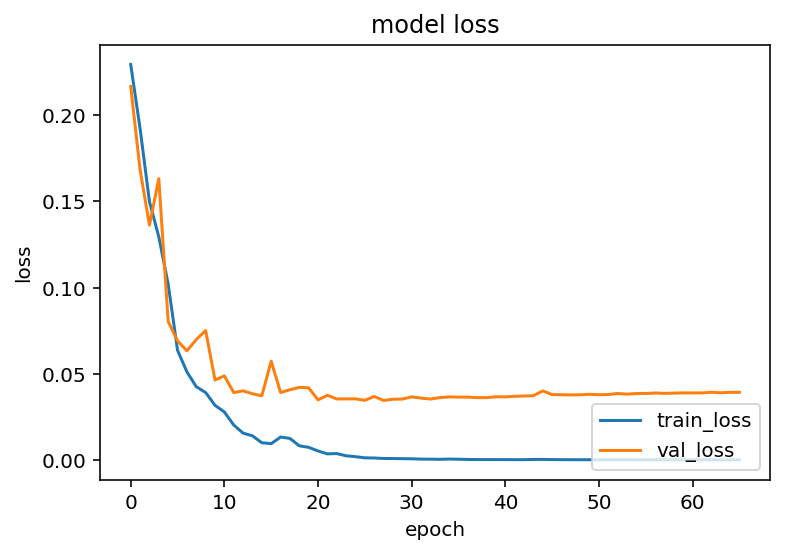

100%|██████████| 20/20 [00:02<00:00,  8.63it/s]
[2017-12-03 01:25:21,668 INFO] TestAcc: 0.9127 | TestLoss: 0.0318 
100%|██████████| 114/114 [00:12<00:00,  8.91it/s]
[2017-12-03 01:25:34,537 INFO] UnlabeledAcc: 0.9052 | UnlabeledLoss: 0.0362 
[2017-12-03 01:25:35,776 INFO] Epoch: 0 | TrainAcc: 0.2295 | TrainLoss: 0.2223
[2017-12-03 01:25:36,156 INFO] Epoch: 0 | ValAcc: 0.2740 | ValLoss: 0.2078 

[2017-12-03 01:25:37,474 INFO] Epoch: 1 | TrainAcc: 0.4980 | TrainLoss: 0.1517
[2017-12-03 01:25:37,879 INFO] Epoch: 1 | ValAcc: 0.5440 | ValLoss: 0.1286 

[2017-12-03 01:25:39,293 INFO] Epoch: 2 | TrainAcc: 0.7045 | TrainLoss: 0.0923
[2017-12-03 01:25:39,650 INFO] Epoch: 2 | ValAcc: 0.6400 | ValLoss: 0.1206 

[2017-12-03 01:25:41,098 INFO] Epoch: 3 | TrainAcc: 0.7400 | TrainLoss: 0.0821
[2017-12-03 01:25:41,455 INFO] Epoch: 3 | ValAcc: 0.7510 | ValLoss: 0.0725 

[2017-12-03 01:25:42,959 INFO] Epoch: 4 | TrainAcc: 0.8425 | TrainLoss: 0.0513
[2017-12-03 01:25:43,356 INFO] Epoch: 4 | ValAcc: 0.795

[2017-12-03 01:27:00,408 INFO] Epoch: 50 | ValAcc: 0.9020 | ValLoss: 0.0351 

[2017-12-03 01:27:00,431 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 01:27:00,433 INFO] Train done.
[2017-12-03 01:27:00,435 INFO] Elapsed Time: 85.86440801620483


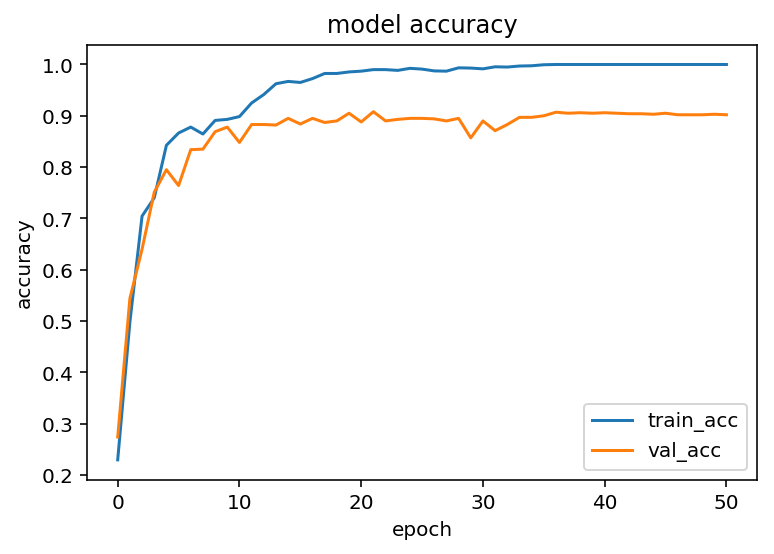

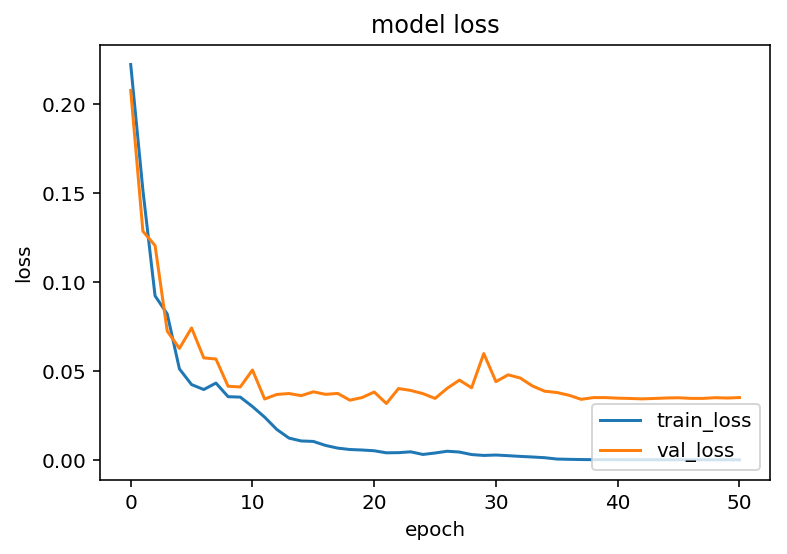

100%|██████████| 20/20 [00:02<00:00,  8.42it/s]
[2017-12-03 01:27:03,116 INFO] TestAcc: 0.9128 | TestLoss: 0.0311 
100%|██████████| 114/114 [00:12<00:00,  9.10it/s]
[2017-12-03 01:27:15,695 INFO] UnlabeledAcc: 0.9056 | UnlabeledLoss: 0.0336 
[2017-12-03 01:27:16,940 INFO] Epoch: 0 | TrainAcc: 0.2130 | TrainLoss: 0.2177
[2017-12-03 01:27:17,297 INFO] Epoch: 0 | ValAcc: 0.3030 | ValLoss: 0.2124 

[2017-12-03 01:27:18,573 INFO] Epoch: 1 | TrainAcc: 0.4065 | TrainLoss: 0.1751
[2017-12-03 01:27:18,928 INFO] Epoch: 1 | ValAcc: 0.5160 | ValLoss: 0.1574 

[2017-12-03 01:27:20,177 INFO] Epoch: 2 | TrainAcc: 0.6055 | TrainLoss: 0.1151
[2017-12-03 01:27:20,523 INFO] Epoch: 2 | ValAcc: 0.5080 | ValLoss: 0.1356 

[2017-12-03 01:27:21,778 INFO] Epoch: 3 | TrainAcc: 0.7255 | TrainLoss: 0.0825
[2017-12-03 01:27:22,122 INFO] Epoch: 3 | ValAcc: 0.3130 | ValLoss: 0.2432 

[2017-12-03 01:27:23,374 INFO] Epoch: 4 | TrainAcc: 0.8365 | TrainLoss: 0.0532
[2017-12-03 01:27:23,726 INFO] Epoch: 4 | ValAcc: 0.683

[2017-12-03 01:28:41,004 INFO] Epoch: 50 | ValAcc: 0.9070 | ValLoss: 0.0372 

[2017-12-03 01:28:42,278 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:42,621 INFO] Epoch: 51 | ValAcc: 0.9070 | ValLoss: 0.0371 

[2017-12-03 01:28:43,864 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:44,207 INFO] Epoch: 52 | ValAcc: 0.9060 | ValLoss: 0.0372 

[2017-12-03 01:28:45,425 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:45,797 INFO] Epoch: 53 | ValAcc: 0.9070 | ValLoss: 0.0375 

[2017-12-03 01:28:46,993 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:47,328 INFO] Epoch: 54 | ValAcc: 0.9060 | ValLoss: 0.0374 

[2017-12-03 01:28:48,580 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:48,929 INFO] Epoch: 55 | ValAcc: 0.9060 | ValLoss: 0.0372 

[2017-12-03 01:28:50,100 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:28:50,440 INFO] Epoch: 56 | ValAcc: 0

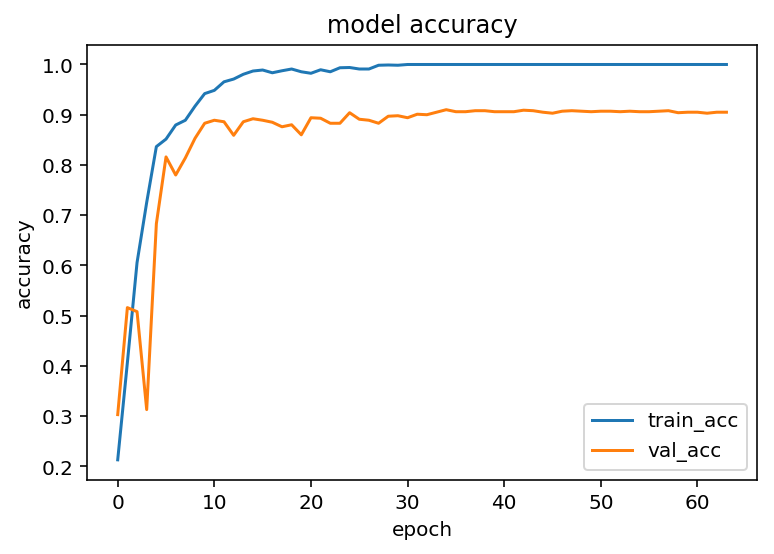

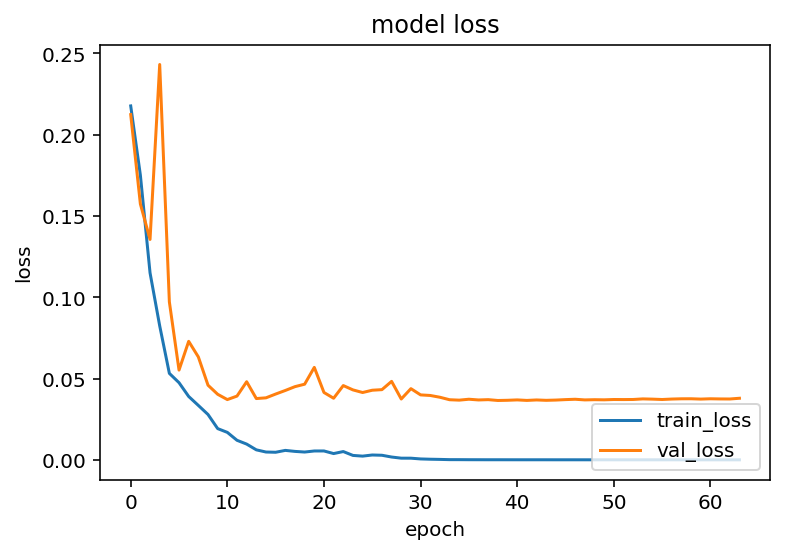

100%|██████████| 20/20 [00:02<00:00,  7.98it/s]
[2017-12-03 01:29:04,787 INFO] TestAcc: 0.9242 | TestLoss: 0.0298 
100%|██████████| 114/114 [00:12<00:00,  9.01it/s]
[2017-12-03 01:29:17,498 INFO] UnlabeledAcc: 0.9147 | UnlabeledLoss: 0.0354 
[2017-12-03 01:29:18,723 INFO] Epoch: 0 | TrainAcc: 0.1225 | TrainLoss: 0.2518
[2017-12-03 01:29:19,073 INFO] Epoch: 0 | ValAcc: 0.1260 | ValLoss: 0.2304 

[2017-12-03 01:29:20,320 INFO] Epoch: 1 | TrainAcc: 0.1870 | TrainLoss: 0.2204
[2017-12-03 01:29:20,672 INFO] Epoch: 1 | ValAcc: 0.2790 | ValLoss: 0.2083 

[2017-12-03 01:29:21,982 INFO] Epoch: 2 | TrainAcc: 0.3475 | TrainLoss: 0.1863
[2017-12-03 01:29:22,347 INFO] Epoch: 2 | ValAcc: 0.3630 | ValLoss: 0.1838 

[2017-12-03 01:29:23,657 INFO] Epoch: 3 | TrainAcc: 0.5085 | TrainLoss: 0.1420
[2017-12-03 01:29:24,045 INFO] Epoch: 3 | ValAcc: 0.4690 | ValLoss: 0.1388 

[2017-12-03 01:29:25,316 INFO] Epoch: 4 | TrainAcc: 0.6605 | TrainLoss: 0.1045
[2017-12-03 01:29:25,668 INFO] Epoch: 4 | ValAcc: 0.542

[2017-12-03 01:30:41,989 INFO] Epoch: 50 | ValAcc: 0.9040 | ValLoss: 0.0366 

[2017-12-03 01:30:43,372 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:43,747 INFO] Epoch: 51 | ValAcc: 0.9040 | ValLoss: 0.0366 

[2017-12-03 01:30:45,043 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:45,413 INFO] Epoch: 52 | ValAcc: 0.9060 | ValLoss: 0.0372 

[2017-12-03 01:30:46,673 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:47,068 INFO] Epoch: 53 | ValAcc: 0.9060 | ValLoss: 0.0364 

[2017-12-03 01:30:48,306 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:48,648 INFO] Epoch: 54 | ValAcc: 0.9040 | ValLoss: 0.0369 

[2017-12-03 01:30:49,938 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:50,306 INFO] Epoch: 55 | ValAcc: 0.9070 | ValLoss: 0.0371 

[2017-12-03 01:30:51,569 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:30:51,922 INFO] Epoch: 56 | ValAcc: 0

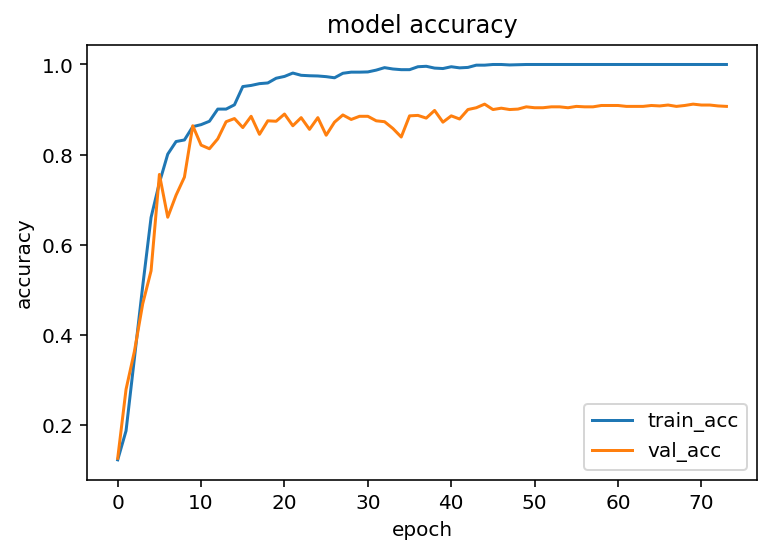

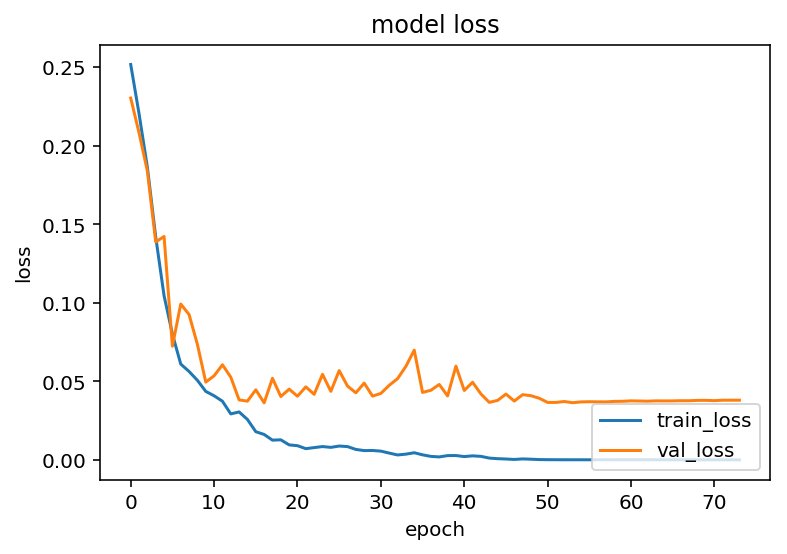

100%|██████████| 20/20 [00:02<00:00,  9.02it/s]
[2017-12-03 01:31:22,148 INFO] TestAcc: 0.9062 | TestLoss: 0.0408 
100%|██████████| 114/114 [00:11<00:00,  9.75it/s]
[2017-12-03 01:31:33,888 INFO] UnlabeledAcc: 0.9000 | UnlabeledLoss: 0.0444 
[2017-12-03 01:31:35,073 INFO] Epoch: 0 | TrainAcc: 0.1675 | TrainLoss: 0.2324
[2017-12-03 01:31:35,408 INFO] Epoch: 0 | ValAcc: 0.1190 | ValLoss: 0.2225 

[2017-12-03 01:31:36,617 INFO] Epoch: 1 | TrainAcc: 0.3215 | TrainLoss: 0.1962
[2017-12-03 01:31:36,944 INFO] Epoch: 1 | ValAcc: 0.4370 | ValLoss: 0.1742 

[2017-12-03 01:31:38,148 INFO] Epoch: 2 | TrainAcc: 0.5540 | TrainLoss: 0.1396
[2017-12-03 01:31:38,483 INFO] Epoch: 2 | ValAcc: 0.4930 | ValLoss: 0.1394 

[2017-12-03 01:31:39,727 INFO] Epoch: 3 | TrainAcc: 0.6640 | TrainLoss: 0.1010
[2017-12-03 01:31:40,060 INFO] Epoch: 3 | ValAcc: 0.6760 | ValLoss: 0.0969 

[2017-12-03 01:31:41,283 INFO] Epoch: 4 | TrainAcc: 0.7325 | TrainLoss: 0.0807
[2017-12-03 01:31:41,619 INFO] Epoch: 4 | ValAcc: 0.687

[2017-12-03 01:32:56,101 INFO] Epoch: 50 | ValAcc: 0.8820 | ValLoss: 0.0464 

[2017-12-03 01:32:57,386 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:32:57,732 INFO] Epoch: 51 | ValAcc: 0.8910 | ValLoss: 0.0450 

[2017-12-03 01:32:58,940 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:32:59,280 INFO] Epoch: 52 | ValAcc: 0.8870 | ValLoss: 0.0443 

[2017-12-03 01:33:00,461 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:33:00,802 INFO] Epoch: 53 | ValAcc: 0.8900 | ValLoss: 0.0444 

[2017-12-03 01:33:02,055 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:33:02,460 INFO] Epoch: 54 | ValAcc: 0.8880 | ValLoss: 0.0443 

[2017-12-03 01:33:02,487 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 01:33:02,491 INFO] Train done.
[2017-12-03 01:33:02,493 INFO] Elapsed Time: 88.57784986495972


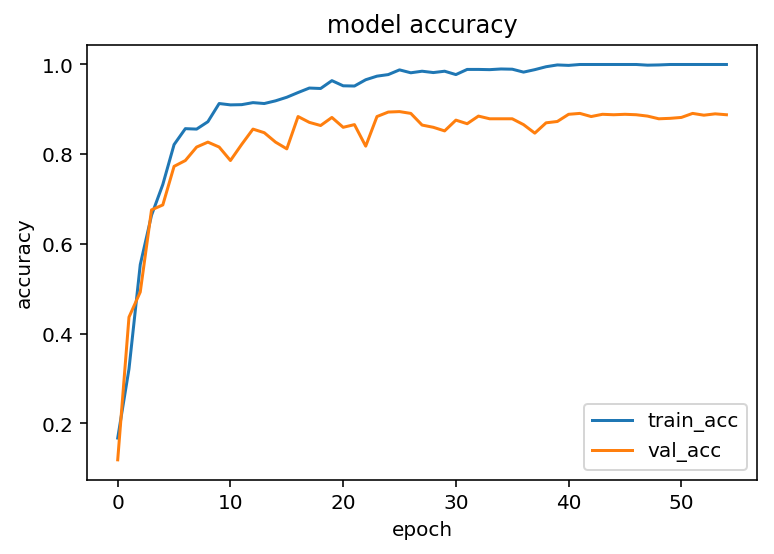

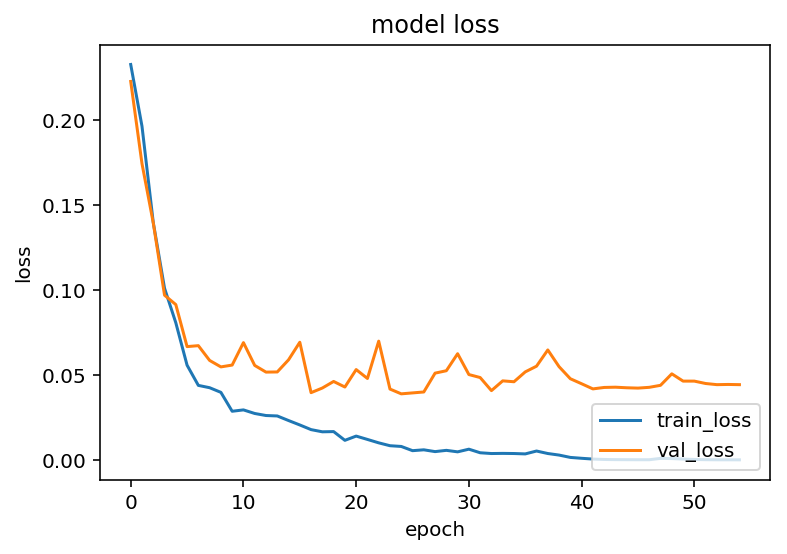

100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
[2017-12-03 01:33:05,053 INFO] TestAcc: 0.8989 | TestLoss: 0.0362 
100%|██████████| 114/114 [00:11<00:00,  9.51it/s]
[2017-12-03 01:33:17,087 INFO] UnlabeledAcc: 0.8929 | UnlabeledLoss: 0.0386 
[2017-12-03 01:33:18,313 INFO] Epoch: 0 | TrainAcc: 0.1785 | TrainLoss: 0.2270
[2017-12-03 01:33:18,658 INFO] Epoch: 0 | ValAcc: 0.3120 | ValLoss: 0.2202 

[2017-12-03 01:33:19,928 INFO] Epoch: 1 | TrainAcc: 0.3725 | TrainLoss: 0.1886
[2017-12-03 01:33:20,270 INFO] Epoch: 1 | ValAcc: 0.4340 | ValLoss: 0.1730 

[2017-12-03 01:33:21,494 INFO] Epoch: 2 | TrainAcc: 0.5575 | TrainLoss: 0.1370
[2017-12-03 01:33:21,870 INFO] Epoch: 2 | ValAcc: 0.5500 | ValLoss: 0.1501 

[2017-12-03 01:33:23,056 INFO] Epoch: 3 | TrainAcc: 0.6830 | TrainLoss: 0.0994
[2017-12-03 01:33:23,388 INFO] Epoch: 3 | ValAcc: 0.4200 | ValLoss: 0.2031 

[2017-12-03 01:33:24,564 INFO] Epoch: 4 | TrainAcc: 0.7650 | TrainLoss: 0.0738
[2017-12-03 01:33:24,896 INFO] Epoch: 4 | ValAcc: 0.767

[2017-12-03 01:34:37,552 INFO] Epoch: 50 | ValAcc: 0.8950 | ValLoss: 0.0422 

[2017-12-03 01:34:38,757 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:39,106 INFO] Epoch: 51 | ValAcc: 0.8960 | ValLoss: 0.0424 

[2017-12-03 01:34:40,352 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:40,690 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0422 

[2017-12-03 01:34:41,922 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:42,280 INFO] Epoch: 53 | ValAcc: 0.8960 | ValLoss: 0.0419 

[2017-12-03 01:34:43,533 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:43,867 INFO] Epoch: 54 | ValAcc: 0.8960 | ValLoss: 0.0425 

[2017-12-03 01:34:45,092 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:45,435 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0421 

[2017-12-03 01:34:46,666 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:34:47,006 INFO] Epoch: 56 | ValAcc: 0

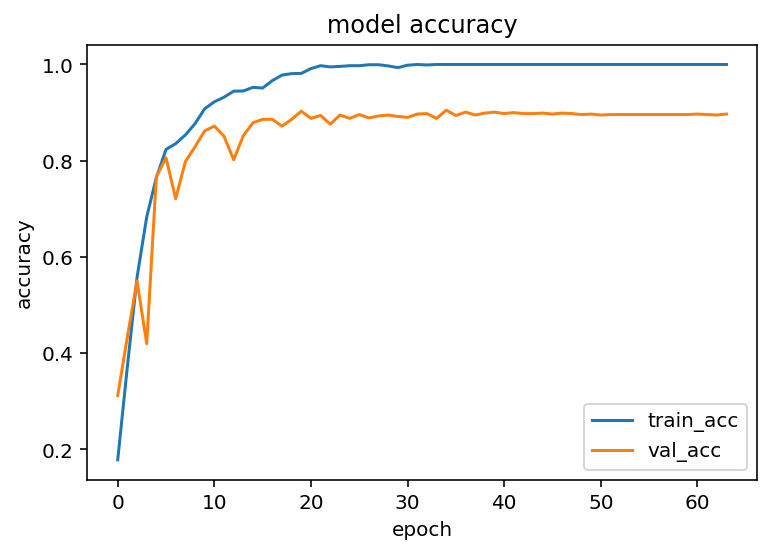

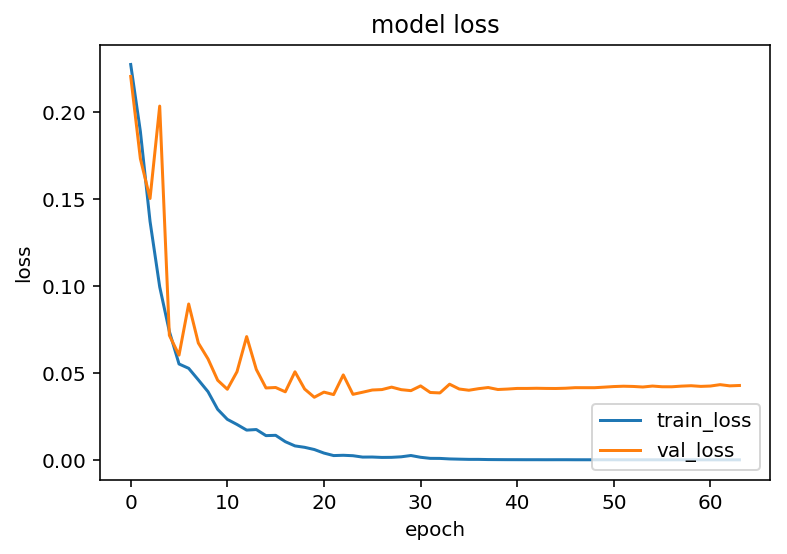

100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
[2017-12-03 01:35:00,508 INFO] TestAcc: 0.9057 | TestLoss: 0.0344 
100%|██████████| 114/114 [00:11<00:00,  9.50it/s]
[2017-12-03 01:35:12,559 INFO] UnlabeledAcc: 0.9009 | UnlabeledLoss: 0.0396 
[2017-12-03 01:35:13,772 INFO] Epoch: 0 | TrainAcc: 0.2190 | TrainLoss: 0.2245
[2017-12-03 01:35:14,239 INFO] Epoch: 0 | ValAcc: 0.1900 | ValLoss: 0.2151 

[2017-12-03 01:35:15,457 INFO] Epoch: 1 | TrainAcc: 0.3885 | TrainLoss: 0.1775
[2017-12-03 01:35:15,939 INFO] Epoch: 1 | ValAcc: 0.5280 | ValLoss: 0.1495 

[2017-12-03 01:35:17,145 INFO] Epoch: 2 | TrainAcc: 0.6310 | TrainLoss: 0.1113
[2017-12-03 01:35:17,599 INFO] Epoch: 2 | ValAcc: 0.5700 | ValLoss: 0.1307 

[2017-12-03 01:35:18,790 INFO] Epoch: 3 | TrainAcc: 0.7135 | TrainLoss: 0.0809
[2017-12-03 01:35:19,248 INFO] Epoch: 3 | ValAcc: 0.5620 | ValLoss: 0.1365 

[2017-12-03 01:35:20,455 INFO] Epoch: 4 | TrainAcc: 0.8215 | TrainLoss: 0.0554
[2017-12-03 01:35:20,908 INFO] Epoch: 4 | ValAcc: 0.743

[2017-12-03 01:36:39,101 INFO] Epoch: 50 | ValAcc: 0.9070 | ValLoss: 0.0379 

[2017-12-03 01:36:40,313 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:40,766 INFO] Epoch: 51 | ValAcc: 0.9080 | ValLoss: 0.0380 

[2017-12-03 01:36:42,005 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:42,474 INFO] Epoch: 52 | ValAcc: 0.9080 | ValLoss: 0.0382 

[2017-12-03 01:36:43,702 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:44,160 INFO] Epoch: 53 | ValAcc: 0.9080 | ValLoss: 0.0381 

[2017-12-03 01:36:45,348 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:45,794 INFO] Epoch: 54 | ValAcc: 0.9080 | ValLoss: 0.0381 

[2017-12-03 01:36:47,011 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:47,458 INFO] Epoch: 55 | ValAcc: 0.9080 | ValLoss: 0.0385 

[2017-12-03 01:36:48,659 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:36:49,114 INFO] Epoch: 56 | ValAcc: 0

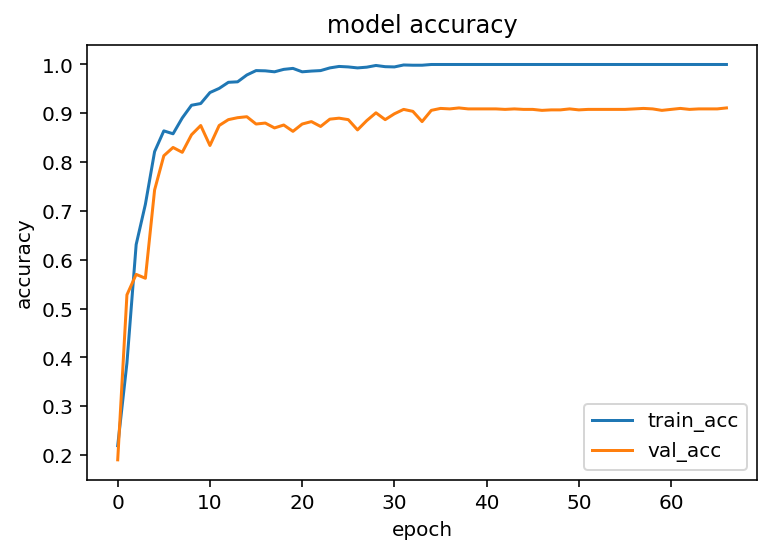

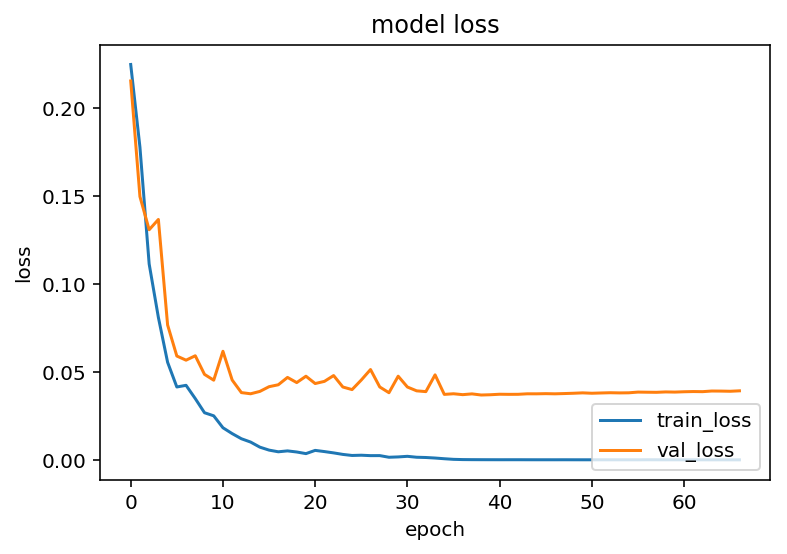

100%|██████████| 20/20 [00:02<00:00,  9.05it/s]
[2017-12-03 01:37:08,652 INFO] TestAcc: 0.9153 | TestLoss: 0.0347 
100%|██████████| 114/114 [00:12<00:00,  9.03it/s]
[2017-12-03 01:37:21,316 INFO] UnlabeledAcc: 0.9064 | UnlabeledLoss: 0.0386 
[2017-12-03 01:37:22,760 INFO] Epoch: 0 | TrainAcc: 0.1385 | TrainLoss: 0.2443
[2017-12-03 01:37:23,219 INFO] Epoch: 0 | ValAcc: 0.2160 | ValLoss: 0.2269 

[2017-12-03 01:37:24,637 INFO] Epoch: 1 | TrainAcc: 0.2465 | TrainLoss: 0.2182
[2017-12-03 01:37:24,992 INFO] Epoch: 1 | ValAcc: 0.3500 | ValLoss: 0.2064 

[2017-12-03 01:37:26,355 INFO] Epoch: 2 | TrainAcc: 0.3880 | TrainLoss: 0.1783
[2017-12-03 01:37:26,846 INFO] Epoch: 2 | ValAcc: 0.3740 | ValLoss: 0.1673 

[2017-12-03 01:37:28,277 INFO] Epoch: 3 | TrainAcc: 0.6410 | TrainLoss: 0.1199
[2017-12-03 01:37:28,701 INFO] Epoch: 3 | ValAcc: 0.5400 | ValLoss: 0.1349 

[2017-12-03 01:37:30,013 INFO] Epoch: 4 | TrainAcc: 0.7170 | TrainLoss: 0.0870
[2017-12-03 01:37:30,420 INFO] Epoch: 4 | ValAcc: 0.545

[2017-12-03 01:38:47,550 INFO] Epoch: 50 | ValAcc: 0.8920 | ValLoss: 0.0491 

[2017-12-03 01:38:48,983 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 01:38:49,445 INFO] Epoch: 51 | ValAcc: 0.8970 | ValLoss: 0.0480 

[2017-12-03 01:38:50,895 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:38:51,349 INFO] Epoch: 52 | ValAcc: 0.8910 | ValLoss: 0.0490 

[2017-12-03 01:38:52,777 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:38:53,227 INFO] Epoch: 53 | ValAcc: 0.8960 | ValLoss: 0.0484 

[2017-12-03 01:38:54,715 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:38:55,078 INFO] Epoch: 54 | ValAcc: 0.8910 | ValLoss: 0.0488 

[2017-12-03 01:38:56,638 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:38:57,119 INFO] Epoch: 55 | ValAcc: 0.8950 | ValLoss: 0.0488 

[2017-12-03 01:38:58,568 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:38:59,008 INFO] Epoch: 56 | ValAcc: 0

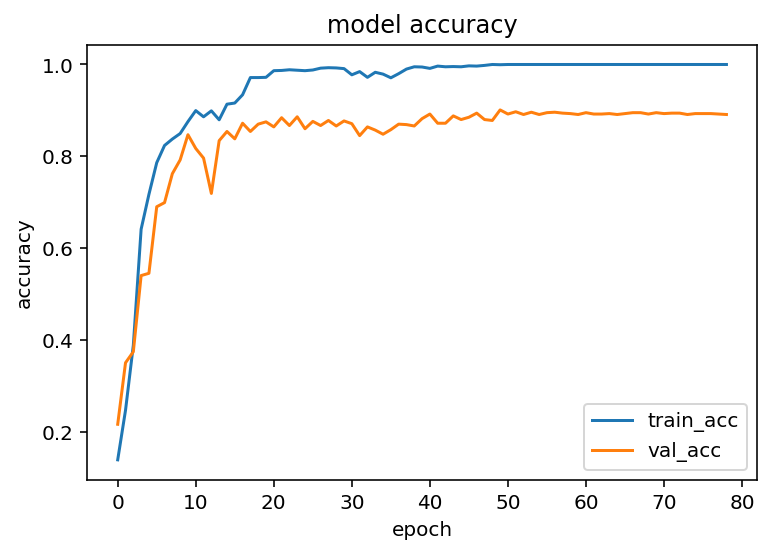

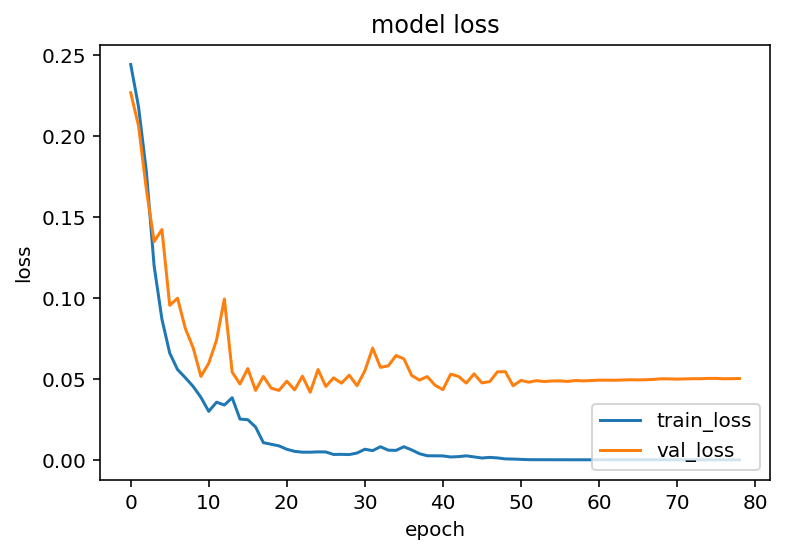

100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
[2017-12-03 01:39:37,704 INFO] TestAcc: 0.9055 | TestLoss: 0.0408 
100%|██████████| 114/114 [00:12<00:00,  8.86it/s]
[2017-12-03 01:39:50,647 INFO] UnlabeledAcc: 0.8982 | UnlabeledLoss: 0.0464 
[2017-12-03 01:39:51,830 INFO] Epoch: 0 | TrainAcc: 0.2080 | TrainLoss: 0.2264
[2017-12-03 01:39:52,176 INFO] Epoch: 0 | ValAcc: 0.2770 | ValLoss: 0.2114 

[2017-12-03 01:39:53,396 INFO] Epoch: 1 | TrainAcc: 0.3920 | TrainLoss: 0.1730
[2017-12-03 01:39:53,749 INFO] Epoch: 1 | ValAcc: 0.4830 | ValLoss: 0.1548 

[2017-12-03 01:39:54,967 INFO] Epoch: 2 | TrainAcc: 0.6305 | TrainLoss: 0.1105
[2017-12-03 01:39:55,314 INFO] Epoch: 2 | ValAcc: 0.5600 | ValLoss: 0.1391 

[2017-12-03 01:39:56,548 INFO] Epoch: 3 | TrainAcc: 0.7605 | TrainLoss: 0.0739
[2017-12-03 01:39:56,890 INFO] Epoch: 3 | ValAcc: 0.7280 | ValLoss: 0.0844 

[2017-12-03 01:39:58,130 INFO] Epoch: 4 | TrainAcc: 0.8180 | TrainLoss: 0.0590
[2017-12-03 01:39:58,475 INFO] Epoch: 4 | ValAcc: 0.761

[2017-12-03 01:41:13,363 INFO] Epoch: 50 | ValAcc: 0.9050 | ValLoss: 0.0426 

[2017-12-03 01:41:14,594 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:14,939 INFO] Epoch: 51 | ValAcc: 0.9060 | ValLoss: 0.0424 

[2017-12-03 01:41:16,191 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:16,554 INFO] Epoch: 52 | ValAcc: 0.9080 | ValLoss: 0.0426 

[2017-12-03 01:41:17,756 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:18,119 INFO] Epoch: 53 | ValAcc: 0.9060 | ValLoss: 0.0427 

[2017-12-03 01:41:19,329 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:19,686 INFO] Epoch: 54 | ValAcc: 0.9070 | ValLoss: 0.0429 

[2017-12-03 01:41:20,891 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:21,259 INFO] Epoch: 55 | ValAcc: 0.9060 | ValLoss: 0.0428 

[2017-12-03 01:41:22,480 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:41:22,836 INFO] Epoch: 56 | ValAcc: 0

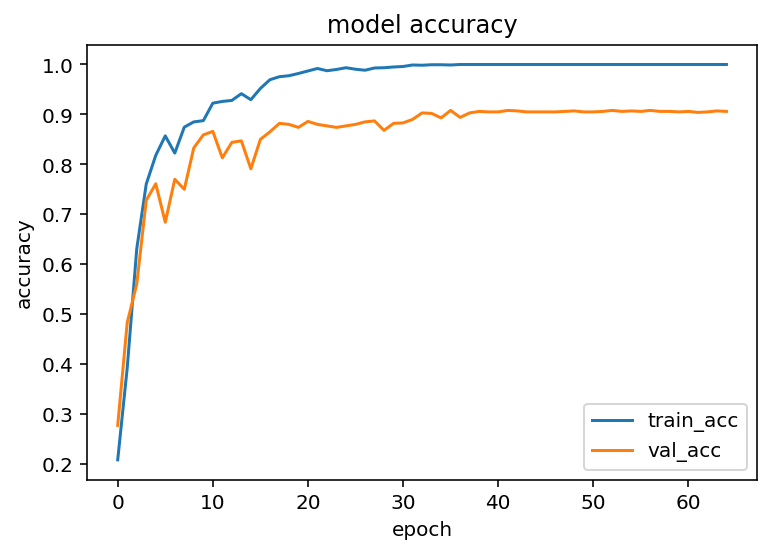

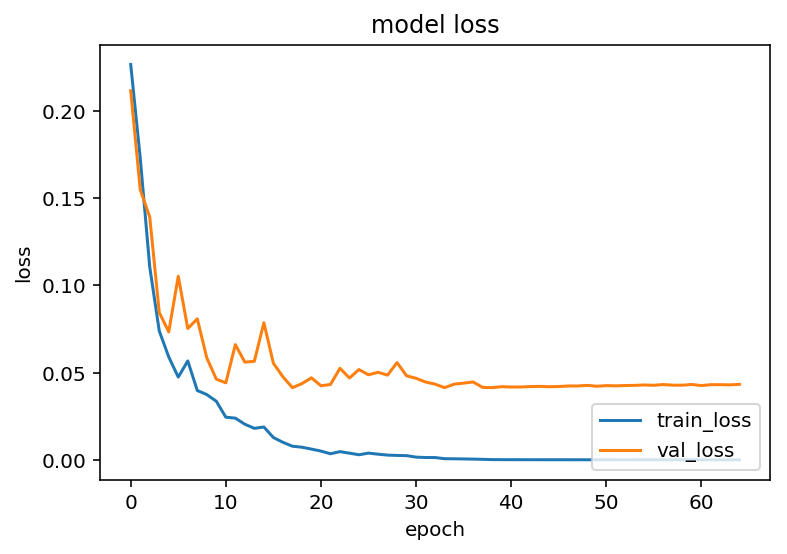

100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
[2017-12-03 01:41:38,272 INFO] TestAcc: 0.9075 | TestLoss: 0.0392 
100%|██████████| 114/114 [00:13<00:00,  8.40it/s]
[2017-12-03 01:41:51,896 INFO] UnlabeledAcc: 0.8975 | UnlabeledLoss: 0.0428 
[2017-12-03 01:41:53,175 INFO] Epoch: 0 | TrainAcc: 0.1905 | TrainLoss: 0.2298
[2017-12-03 01:41:53,562 INFO] Epoch: 0 | ValAcc: 0.2540 | ValLoss: 0.2167 

[2017-12-03 01:41:54,896 INFO] Epoch: 1 | TrainAcc: 0.3635 | TrainLoss: 0.1849
[2017-12-03 01:41:55,253 INFO] Epoch: 1 | ValAcc: 0.4840 | ValLoss: 0.1634 

[2017-12-03 01:41:56,626 INFO] Epoch: 2 | TrainAcc: 0.5995 | TrainLoss: 0.1220
[2017-12-03 01:41:56,995 INFO] Epoch: 2 | ValAcc: 0.3350 | ValLoss: 0.2035 

[2017-12-03 01:41:58,300 INFO] Epoch: 3 | TrainAcc: 0.7330 | TrainLoss: 0.0803
[2017-12-03 01:41:58,686 INFO] Epoch: 3 | ValAcc: 0.6490 | ValLoss: 0.1029 

[2017-12-03 01:42:00,153 INFO] Epoch: 4 | TrainAcc: 0.8045 | TrainLoss: 0.0571
[2017-12-03 01:42:00,507 INFO] Epoch: 4 | ValAcc: 0.670

[2017-12-03 01:43:15,985 INFO] Epoch: 50 | ValAcc: 0.8920 | ValLoss: 0.0447 

[2017-12-03 01:43:17,230 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:17,589 INFO] Epoch: 51 | ValAcc: 0.8950 | ValLoss: 0.0448 

[2017-12-03 01:43:18,804 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:19,145 INFO] Epoch: 52 | ValAcc: 0.8910 | ValLoss: 0.0448 

[2017-12-03 01:43:20,365 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:20,716 INFO] Epoch: 53 | ValAcc: 0.8930 | ValLoss: 0.0447 

[2017-12-03 01:43:22,141 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:22,482 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0450 

[2017-12-03 01:43:23,678 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:24,025 INFO] Epoch: 55 | ValAcc: 0.8930 | ValLoss: 0.0448 

[2017-12-03 01:43:25,216 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 01:43:25,550 INFO] Epoch: 56 | ValAcc: 0

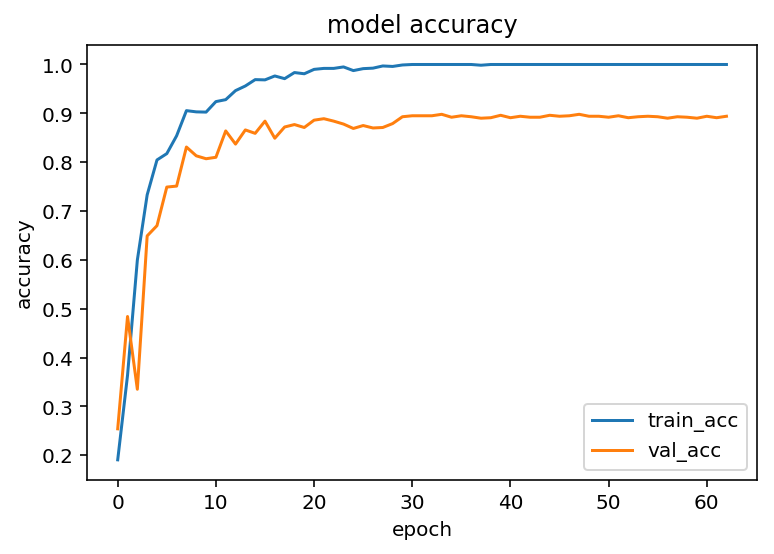

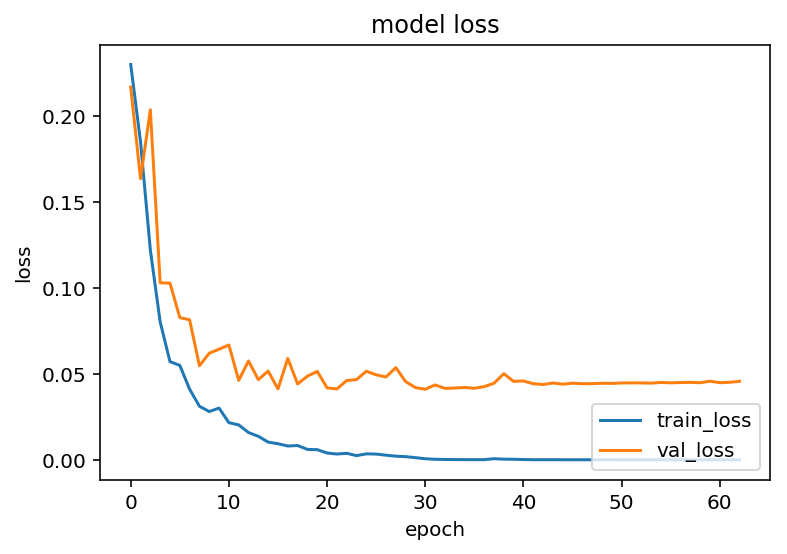

100%|██████████| 20/20 [00:02<00:00,  9.20it/s]
[2017-12-03 01:43:37,877 INFO] TestAcc: 0.9162 | TestLoss: 0.0340 
100%|██████████| 114/114 [00:12<00:00,  8.87it/s]
[2017-12-03 01:43:50,780 INFO] UnlabeledAcc: 0.9085 | UnlabeledLoss: 0.0370 


In [10]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = True
ex_name = 'pseudo_hard'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['test_acc'] = np.empty((trial_times))
results['test_loss'] = np.empty((trial_times))
results['unlabeled_acc'] = np.empty((trial_times))
results['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['test_acc'][i], results['test_loss'][i] = _test(model, test_loader, criterion)
    results['unlabeled_acc'][i], results['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [11]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['test_acc']),
    np.std(results['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results['test_loss']),
    np.std(results['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_acc']),
    np.std(results['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_loss']),
    np.std(results['unlabeled_loss'])
))

[2017-12-03 01:43:50,879 INFO] Test Accuracy: 0.9105 ± 0.0068
[2017-12-03 01:43:50,882 INFO] Test Loss: 0.0353 ± 0.0037

[2017-12-03 01:43:50,883 INFO] Unlabeled Accuracy: 0.9030 ± 0.0060
[2017-12-03 01:43:50,885 INFO] Unlabeled Loss: 0.0393 ± 0.0039


In [16]:
from scipy import stats

t, p = stats.ttest_ind(results['test_acc'], results['unlabeled_acc'], equal_var=False)
print( "Test accとUnlabeled acc(Pseudo Labelingされたデータの予測精度)に有意差はあるか？：p値 = %(p)s" %locals() )

t, p = stats.ttest_ind_from_stats(
    np.mean(results['test_acc']),
    np.std(results['test_acc']),
    10,
    0.8922, # supervised result
    0.0094, # //
    10,
    equal_var=False
)
print( "Pseudo Label使用/未使用に有意差はあるか？：p値 = %(p)s" %locals() )

Test accとUnlabeled acc(Pseudo Labelingされたデータの予測精度)に有意差はあるか？：p値 = 0.0232027335497
Pseudo Label使用/未使用に有意差はあるか？：p値 = 0.000125138613135


## Soft Pseudo Label

[2017-12-03 01:43:52,467 INFO] Epoch: 0 | TrainAcc: 0.1845 | TrainLoss: 0.2208
[2017-12-03 01:43:52,866 INFO] Epoch: 0 | ValAcc: 0.2830 | ValLoss: 0.2140 

[2017-12-03 01:43:54,136 INFO] Epoch: 1 | TrainAcc: 0.4560 | TrainLoss: 0.1595
[2017-12-03 01:43:54,526 INFO] Epoch: 1 | ValAcc: 0.5320 | ValLoss: 0.1403 

[2017-12-03 01:43:55,858 INFO] Epoch: 2 | TrainAcc: 0.6905 | TrainLoss: 0.0899
[2017-12-03 01:43:56,304 INFO] Epoch: 2 | ValAcc: 0.6280 | ValLoss: 0.1055 

[2017-12-03 01:43:57,603 INFO] Epoch: 3 | TrainAcc: 0.8125 | TrainLoss: 0.0541
[2017-12-03 01:43:58,040 INFO] Epoch: 3 | ValAcc: 0.7720 | ValLoss: 0.0726 

[2017-12-03 01:43:59,582 INFO] Epoch: 4 | TrainAcc: 0.8540 | TrainLoss: 0.0428
[2017-12-03 01:43:59,989 INFO] Epoch: 4 | ValAcc: 0.7900 | ValLoss: 0.0641 

[2017-12-03 01:44:01,404 INFO] Epoch: 5 | TrainAcc: 0.8735 | TrainLoss: 0.0372
[2017-12-03 01:44:01,807 INFO] Epoch: 5 | ValAcc: 0.8050 | ValLoss: 0.0627 

[2017-12-03 01:44:03,279 INFO] Epoch: 6 | TrainAcc: 0.8945 | Tra

[2017-12-03 01:45:27,017 INFO] Epoch: 52 | TrainAcc: 0.9725 | TrainLoss: 0.0079
[2017-12-03 01:45:27,518 INFO] Epoch: 52 | ValAcc: 0.8890 | ValLoss: 0.0386 

[2017-12-03 01:45:28,872 INFO] Epoch: 53 | TrainAcc: 0.9810 | TrainLoss: 0.0066
[2017-12-03 01:45:29,305 INFO] Epoch: 53 | ValAcc: 0.8960 | ValLoss: 0.0365 

[2017-12-03 01:45:30,719 INFO] Epoch: 54 | TrainAcc: 0.9815 | TrainLoss: 0.0058
[2017-12-03 01:45:31,151 INFO] Epoch: 54 | ValAcc: 0.8840 | ValLoss: 0.0412 

[2017-12-03 01:45:32,637 INFO] Epoch: 55 | TrainAcc: 0.9750 | TrainLoss: 0.0057
[2017-12-03 01:45:33,041 INFO] Epoch: 55 | ValAcc: 0.8500 | ValLoss: 0.0569 

[2017-12-03 01:45:34,353 INFO] Epoch: 56 | TrainAcc: 0.9765 | TrainLoss: 0.0071
[2017-12-03 01:45:34,727 INFO] Epoch: 56 | ValAcc: 0.8610 | ValLoss: 0.0496 

[2017-12-03 01:45:36,171 INFO] Epoch: 57 | TrainAcc: 0.9805 | TrainLoss: 0.0063
[2017-12-03 01:45:36,537 INFO] Epoch: 57 | ValAcc: 0.8990 | ValLoss: 0.0345 

[2017-12-03 01:45:37,872 INFO] Epoch: 58 | TrainAcc:

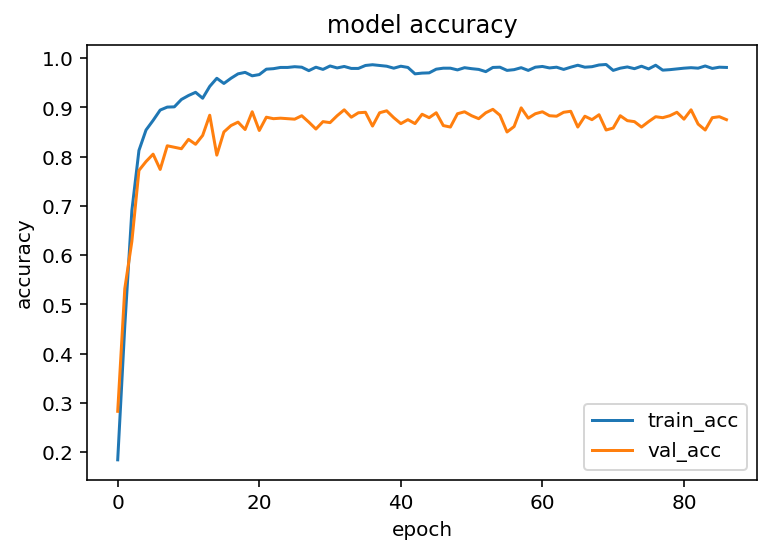

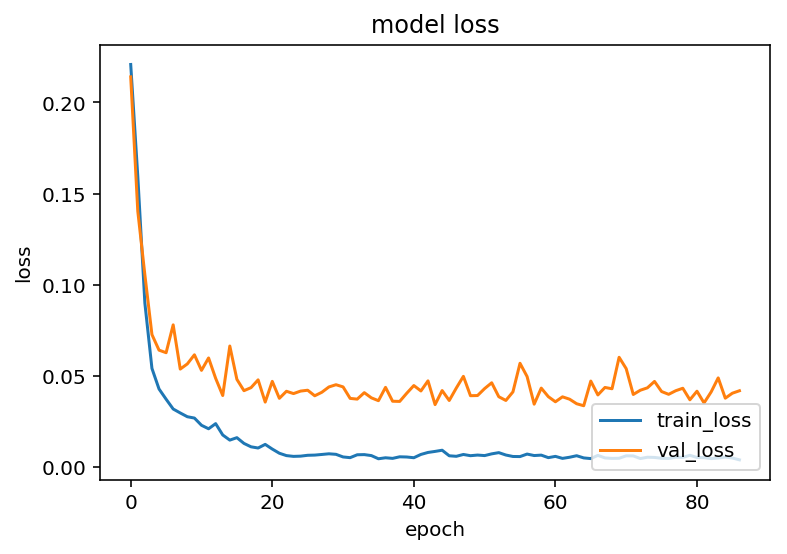

100%|██████████| 20/20 [00:02<00:00,  7.04it/s]
[2017-12-03 01:46:31,020 INFO] TestAcc: 0.9149 | TestLoss: 0.0289 
100%|██████████| 114/114 [00:12<00:00,  9.11it/s]
[2017-12-03 01:46:43,585 INFO] UnlabeledAcc: 0.9077 | UnlabeledLoss: 0.0311 
[2017-12-03 01:46:44,808 INFO] Epoch: 0 | TrainAcc: 0.1665 | TrainLoss: 0.2183
[2017-12-03 01:46:45,162 INFO] Epoch: 0 | ValAcc: 0.1960 | ValLoss: 0.2184 

[2017-12-03 01:46:46,389 INFO] Epoch: 1 | TrainAcc: 0.3785 | TrainLoss: 0.1759
[2017-12-03 01:46:46,738 INFO] Epoch: 1 | ValAcc: 0.5570 | ValLoss: 0.1608 

[2017-12-03 01:46:47,924 INFO] Epoch: 2 | TrainAcc: 0.5980 | TrainLoss: 0.1104
[2017-12-03 01:46:48,286 INFO] Epoch: 2 | ValAcc: 0.6490 | ValLoss: 0.1077 

[2017-12-03 01:46:49,512 INFO] Epoch: 3 | TrainAcc: 0.7045 | TrainLoss: 0.0817
[2017-12-03 01:46:49,862 INFO] Epoch: 3 | ValAcc: 0.7290 | ValLoss: 0.0843 

[2017-12-03 01:46:51,066 INFO] Epoch: 4 | TrainAcc: 0.8135 | TrainLoss: 0.0538
[2017-12-03 01:46:51,413 INFO] Epoch: 4 | ValAcc: 0.773

[2017-12-03 01:48:06,893 INFO] Epoch: 50 | ValAcc: 0.8510 | ValLoss: 0.0478 

[2017-12-03 01:48:08,347 INFO] Epoch: 51 | TrainAcc: 0.9770 | TrainLoss: 0.0058
[2017-12-03 01:48:08,703 INFO] Epoch: 51 | ValAcc: 0.8880 | ValLoss: 0.0403 

[2017-12-03 01:48:09,973 INFO] Epoch: 52 | TrainAcc: 0.9845 | TrainLoss: 0.0047
[2017-12-03 01:48:10,322 INFO] Epoch: 52 | ValAcc: 0.8730 | ValLoss: 0.0420 

[2017-12-03 01:48:11,627 INFO] Epoch: 53 | TrainAcc: 0.9875 | TrainLoss: 0.0048
[2017-12-03 01:48:11,970 INFO] Epoch: 53 | ValAcc: 0.8860 | ValLoss: 0.0363 

[2017-12-03 01:48:13,247 INFO] Epoch: 54 | TrainAcc: 0.9840 | TrainLoss: 0.0042
[2017-12-03 01:48:13,594 INFO] Epoch: 54 | ValAcc: 0.8820 | ValLoss: 0.0354 

[2017-12-03 01:48:14,854 INFO] Epoch: 55 | TrainAcc: 0.9835 | TrainLoss: 0.0047
[2017-12-03 01:48:15,203 INFO] Epoch: 55 | ValAcc: 0.8790 | ValLoss: 0.0377 

[2017-12-03 01:48:16,524 INFO] Epoch: 56 | TrainAcc: 0.9855 | TrainLoss: 0.0043
[2017-12-03 01:48:16,874 INFO] Epoch: 56 | ValAcc: 0

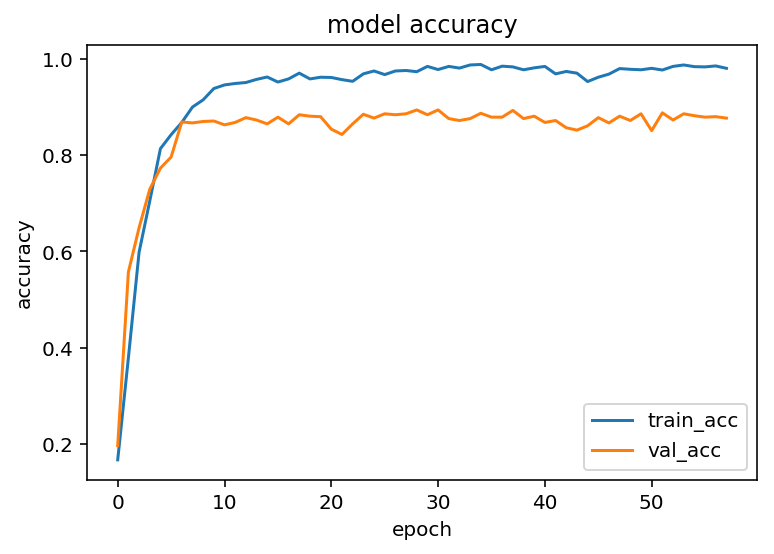

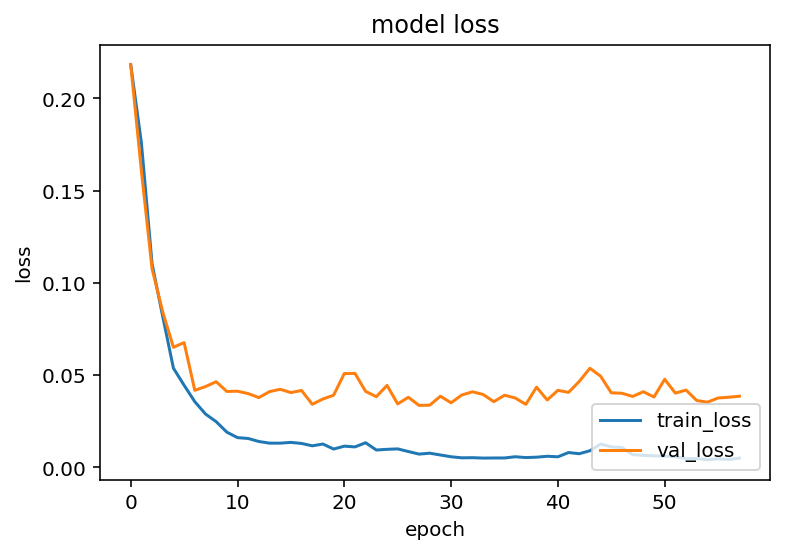

100%|██████████| 20/20 [00:02<00:00,  8.17it/s]
[2017-12-03 01:48:21,387 INFO] TestAcc: 0.9133 | TestLoss: 0.0298 
100%|██████████| 114/114 [00:12<00:00,  8.98it/s]
[2017-12-03 01:48:34,135 INFO] UnlabeledAcc: 0.9047 | UnlabeledLoss: 0.0316 
[2017-12-03 01:48:35,446 INFO] Epoch: 0 | TrainAcc: 0.1565 | TrainLoss: 0.2234
[2017-12-03 01:48:35,800 INFO] Epoch: 0 | ValAcc: 0.2140 | ValLoss: 0.2182 

[2017-12-03 01:48:37,036 INFO] Epoch: 1 | TrainAcc: 0.3760 | TrainLoss: 0.1754
[2017-12-03 01:48:37,397 INFO] Epoch: 1 | ValAcc: 0.4280 | ValLoss: 0.1713 

[2017-12-03 01:48:38,771 INFO] Epoch: 2 | TrainAcc: 0.5505 | TrainLoss: 0.1221
[2017-12-03 01:48:39,184 INFO] Epoch: 2 | ValAcc: 0.6520 | ValLoss: 0.1089 

[2017-12-03 01:48:40,580 INFO] Epoch: 3 | TrainAcc: 0.7610 | TrainLoss: 0.0706
[2017-12-03 01:48:40,946 INFO] Epoch: 3 | ValAcc: 0.7210 | ValLoss: 0.0859 

[2017-12-03 01:48:42,351 INFO] Epoch: 4 | TrainAcc: 0.8400 | TrainLoss: 0.0471
[2017-12-03 01:48:42,737 INFO] Epoch: 4 | ValAcc: 0.810

[2017-12-03 01:50:05,458 INFO] Epoch: 50 | ValAcc: 0.9030 | ValLoss: 0.0329 

[2017-12-03 01:50:06,789 INFO] Epoch: 51 | TrainAcc: 0.9760 | TrainLoss: 0.0059
[2017-12-03 01:50:07,141 INFO] Epoch: 51 | ValAcc: 0.8940 | ValLoss: 0.0326 

[2017-12-03 01:50:08,390 INFO] Epoch: 52 | TrainAcc: 0.9795 | TrainLoss: 0.0060
[2017-12-03 01:50:08,738 INFO] Epoch: 52 | ValAcc: 0.9010 | ValLoss: 0.0320 

[2017-12-03 01:50:10,023 INFO] Epoch: 53 | TrainAcc: 0.9770 | TrainLoss: 0.0048
[2017-12-03 01:50:10,394 INFO] Epoch: 53 | ValAcc: 0.8720 | ValLoss: 0.0417 

[2017-12-03 01:50:11,655 INFO] Epoch: 54 | TrainAcc: 0.9750 | TrainLoss: 0.0067
[2017-12-03 01:50:12,018 INFO] Epoch: 54 | ValAcc: 0.9030 | ValLoss: 0.0327 

[2017-12-03 01:50:13,453 INFO] Epoch: 55 | TrainAcc: 0.9765 | TrainLoss: 0.0049
[2017-12-03 01:50:13,804 INFO] Epoch: 55 | ValAcc: 0.9020 | ValLoss: 0.0325 

[2017-12-03 01:50:15,192 INFO] Epoch: 56 | TrainAcc: 0.9765 | TrainLoss: 0.0052
[2017-12-03 01:50:15,598 INFO] Epoch: 56 | ValAcc: 0

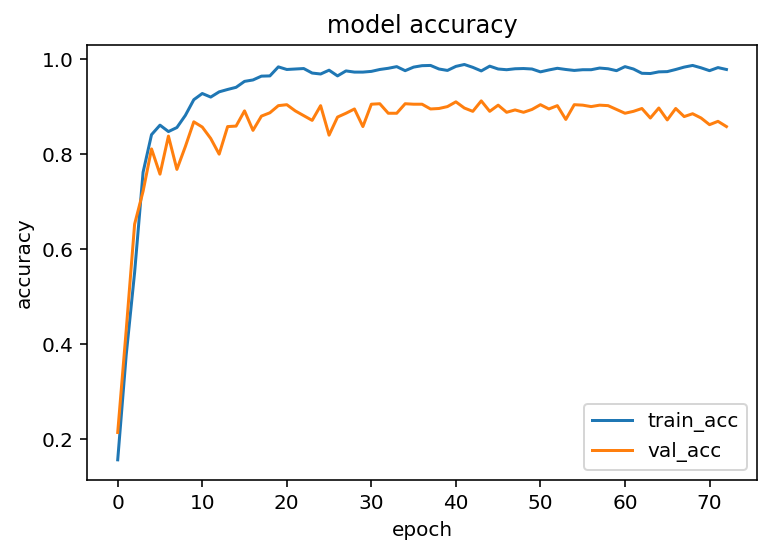

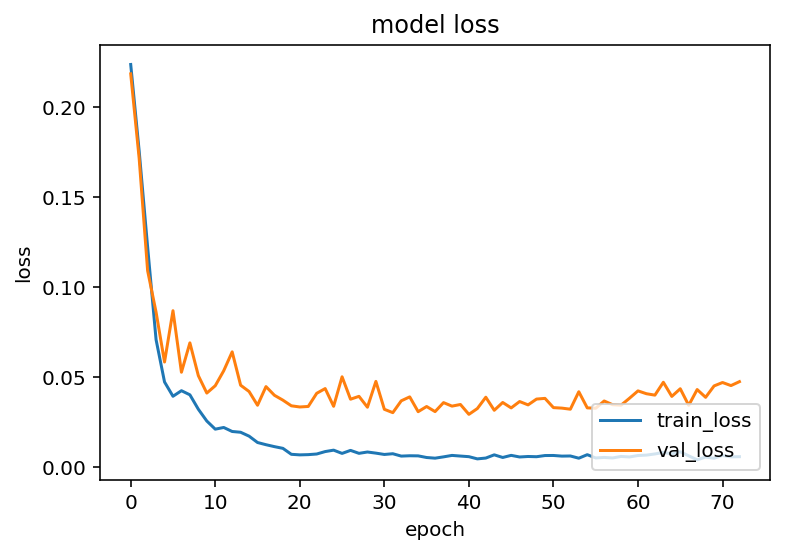

100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
[2017-12-03 01:50:48,592 INFO] TestAcc: 0.9127 | TestLoss: 0.0287 
100%|██████████| 114/114 [00:11<00:00,  9.77it/s]
[2017-12-03 01:51:00,306 INFO] UnlabeledAcc: 0.9041 | UnlabeledLoss: 0.0311 
[2017-12-03 01:51:01,490 INFO] Epoch: 0 | TrainAcc: 0.1675 | TrainLoss: 0.2188
[2017-12-03 01:51:01,830 INFO] Epoch: 0 | ValAcc: 0.2060 | ValLoss: 0.2222 

[2017-12-03 01:51:03,019 INFO] Epoch: 1 | TrainAcc: 0.3285 | TrainLoss: 0.1830
[2017-12-03 01:51:03,354 INFO] Epoch: 1 | ValAcc: 0.3940 | ValLoss: 0.1674 

[2017-12-03 01:51:04,535 INFO] Epoch: 2 | TrainAcc: 0.6010 | TrainLoss: 0.1258
[2017-12-03 01:51:04,884 INFO] Epoch: 2 | ValAcc: 0.6330 | ValLoss: 0.1085 

[2017-12-03 01:51:06,120 INFO] Epoch: 3 | TrainAcc: 0.7040 | TrainLoss: 0.0819
[2017-12-03 01:51:06,452 INFO] Epoch: 3 | ValAcc: 0.7360 | ValLoss: 0.0810 

[2017-12-03 01:51:07,785 INFO] Epoch: 4 | TrainAcc: 0.8025 | TrainLoss: 0.0539
[2017-12-03 01:51:08,200 INFO] Epoch: 4 | ValAcc: 0.800

[2017-12-03 01:52:34,339 INFO] Epoch: 50 | ValAcc: 0.8690 | ValLoss: 0.0401 

[2017-12-03 01:52:35,837 INFO] Epoch: 51 | TrainAcc: 0.9825 | TrainLoss: 0.0063
[2017-12-03 01:52:36,395 INFO] Epoch: 51 | ValAcc: 0.8820 | ValLoss: 0.0421 

[2017-12-03 01:52:37,915 INFO] Epoch: 52 | TrainAcc: 0.9850 | TrainLoss: 0.0046
[2017-12-03 01:52:38,300 INFO] Epoch: 52 | ValAcc: 0.8820 | ValLoss: 0.0372 

[2017-12-03 01:52:39,617 INFO] Epoch: 53 | TrainAcc: 0.9860 | TrainLoss: 0.0046
[2017-12-03 01:52:40,001 INFO] Epoch: 53 | ValAcc: 0.8680 | ValLoss: 0.0445 

[2017-12-03 01:52:41,370 INFO] Epoch: 54 | TrainAcc: 0.9810 | TrainLoss: 0.0046
[2017-12-03 01:52:41,752 INFO] Epoch: 54 | ValAcc: 0.8870 | ValLoss: 0.0382 

[2017-12-03 01:52:43,213 INFO] Epoch: 55 | TrainAcc: 0.9785 | TrainLoss: 0.0051
[2017-12-03 01:52:43,563 INFO] Epoch: 55 | ValAcc: 0.8780 | ValLoss: 0.0408 

[2017-12-03 01:52:44,795 INFO] Epoch: 56 | TrainAcc: 0.9805 | TrainLoss: 0.0045
[2017-12-03 01:52:45,139 INFO] Epoch: 56 | ValAcc: 0

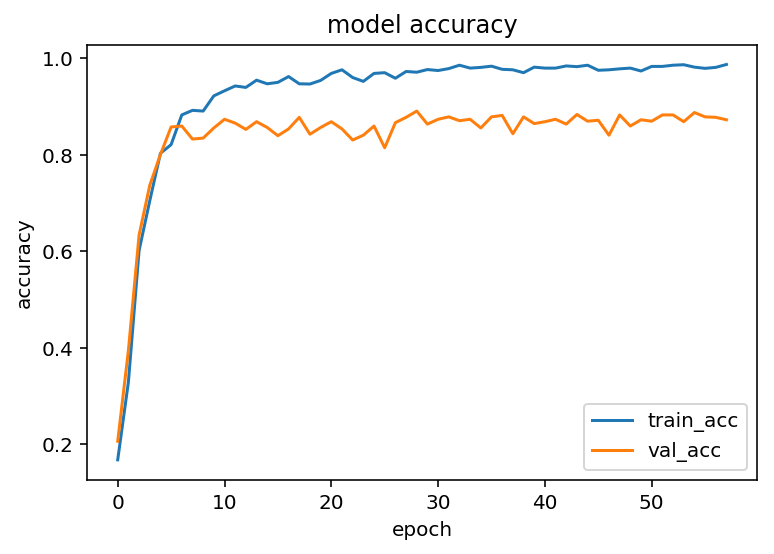

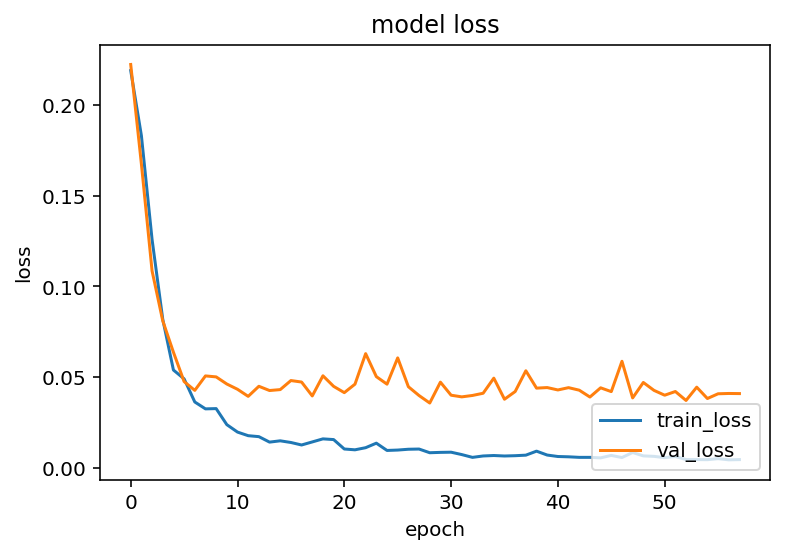

100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
[2017-12-03 01:52:49,312 INFO] TestAcc: 0.9065 | TestLoss: 0.0307 
100%|██████████| 114/114 [00:12<00:00,  9.23it/s]
[2017-12-03 01:53:01,712 INFO] UnlabeledAcc: 0.8955 | UnlabeledLoss: 0.0337 
[2017-12-03 01:53:02,898 INFO] Epoch: 0 | TrainAcc: 0.1290 | TrainLoss: 0.2296
[2017-12-03 01:53:03,254 INFO] Epoch: 0 | ValAcc: 0.1730 | ValLoss: 0.2223 

[2017-12-03 01:53:04,487 INFO] Epoch: 1 | TrainAcc: 0.3290 | TrainLoss: 0.1941
[2017-12-03 01:53:04,831 INFO] Epoch: 1 | ValAcc: 0.4200 | ValLoss: 0.1877 

[2017-12-03 01:53:06,093 INFO] Epoch: 2 | TrainAcc: 0.5175 | TrainLoss: 0.1467
[2017-12-03 01:53:06,437 INFO] Epoch: 2 | ValAcc: 0.5370 | ValLoss: 0.1359 

[2017-12-03 01:53:07,659 INFO] Epoch: 3 | TrainAcc: 0.6485 | TrainLoss: 0.1002
[2017-12-03 01:53:08,009 INFO] Epoch: 3 | ValAcc: 0.6050 | ValLoss: 0.1126 

[2017-12-03 01:53:09,216 INFO] Epoch: 4 | TrainAcc: 0.7480 | TrainLoss: 0.0692
[2017-12-03 01:53:09,555 INFO] Epoch: 4 | ValAcc: 0.714

[2017-12-03 01:54:22,453 INFO] Epoch: 50 | ValAcc: 0.8850 | ValLoss: 0.0371 

[2017-12-03 01:54:23,673 INFO] Epoch: 51 | TrainAcc: 0.9685 | TrainLoss: 0.0079
[2017-12-03 01:54:23,998 INFO] Epoch: 51 | ValAcc: 0.8730 | ValLoss: 0.0425 

[2017-12-03 01:54:25,222 INFO] Epoch: 52 | TrainAcc: 0.9695 | TrainLoss: 0.0086
[2017-12-03 01:54:25,556 INFO] Epoch: 52 | ValAcc: 0.8530 | ValLoss: 0.0521 

[2017-12-03 01:54:26,787 INFO] Epoch: 53 | TrainAcc: 0.9740 | TrainLoss: 0.0084
[2017-12-03 01:54:27,130 INFO] Epoch: 53 | ValAcc: 0.8730 | ValLoss: 0.0418 

[2017-12-03 01:54:28,365 INFO] Epoch: 54 | TrainAcc: 0.9750 | TrainLoss: 0.0075
[2017-12-03 01:54:28,706 INFO] Epoch: 54 | ValAcc: 0.8810 | ValLoss: 0.0388 

[2017-12-03 01:54:29,917 INFO] Epoch: 55 | TrainAcc: 0.9825 | TrainLoss: 0.0063
[2017-12-03 01:54:30,251 INFO] Epoch: 55 | ValAcc: 0.8720 | ValLoss: 0.0413 

[2017-12-03 01:54:31,470 INFO] Epoch: 56 | TrainAcc: 0.9780 | TrainLoss: 0.0053
[2017-12-03 01:54:31,811 INFO] Epoch: 56 | ValAcc: 0

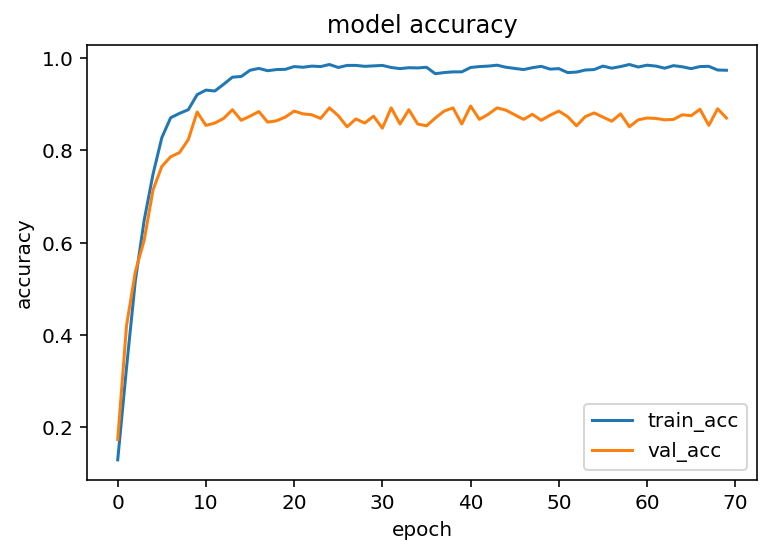

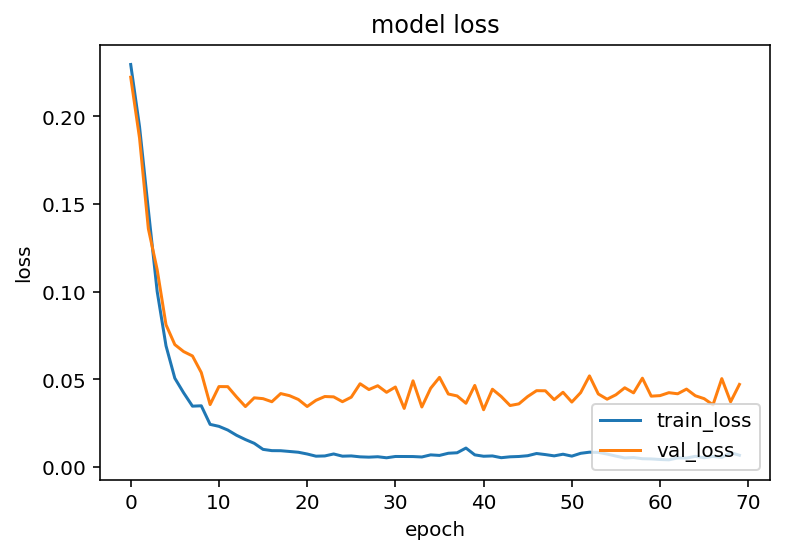

100%|██████████| 20/20 [00:02<00:00,  9.28it/s]
[2017-12-03 01:54:54,829 INFO] TestAcc: 0.9058 | TestLoss: 0.0312 
100%|██████████| 114/114 [00:11<00:00, 10.08it/s]
[2017-12-03 01:55:06,188 INFO] UnlabeledAcc: 0.8998 | UnlabeledLoss: 0.0337 
[2017-12-03 01:55:07,416 INFO] Epoch: 0 | TrainAcc: 0.1985 | TrainLoss: 0.2163
[2017-12-03 01:55:07,754 INFO] Epoch: 0 | ValAcc: 0.2440 | ValLoss: 0.2165 

[2017-12-03 01:55:08,980 INFO] Epoch: 1 | TrainAcc: 0.4135 | TrainLoss: 0.1662
[2017-12-03 01:55:09,325 INFO] Epoch: 1 | ValAcc: 0.2980 | ValLoss: 0.1922 

[2017-12-03 01:55:10,575 INFO] Epoch: 2 | TrainAcc: 0.5820 | TrainLoss: 0.1112
[2017-12-03 01:55:10,921 INFO] Epoch: 2 | ValAcc: 0.6550 | ValLoss: 0.1003 

[2017-12-03 01:55:12,182 INFO] Epoch: 3 | TrainAcc: 0.6840 | TrainLoss: 0.0863
[2017-12-03 01:55:12,541 INFO] Epoch: 3 | ValAcc: 0.7230 | ValLoss: 0.1120 

[2017-12-03 01:55:13,806 INFO] Epoch: 4 | TrainAcc: 0.8300 | TrainLoss: 0.0491
[2017-12-03 01:55:14,160 INFO] Epoch: 4 | ValAcc: 0.799

[2017-12-03 01:56:26,650 INFO] Epoch: 50 | ValAcc: 0.8770 | ValLoss: 0.0418 

[2017-12-03 01:56:26,672 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 01:56:26,674 INFO] Train done.
[2017-12-03 01:56:26,676 INFO] Elapsed Time: 80.4600088596344


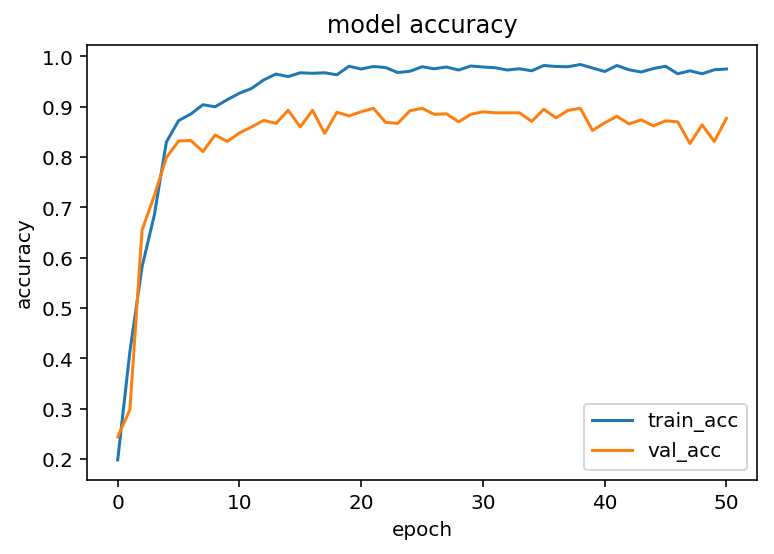

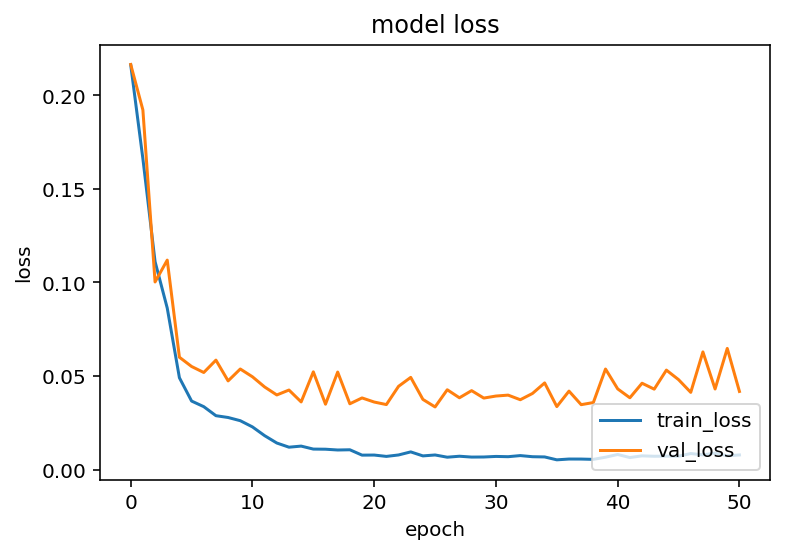

100%|██████████| 20/20 [00:02<00:00,  9.36it/s]
[2017-12-03 01:56:29,074 INFO] TestAcc: 0.9146 | TestLoss: 0.0274 
100%|██████████| 114/114 [00:11<00:00, 10.14it/s]
[2017-12-03 01:56:40,363 INFO] UnlabeledAcc: 0.9041 | UnlabeledLoss: 0.0307 
[2017-12-03 01:56:41,556 INFO] Epoch: 0 | TrainAcc: 0.1460 | TrainLoss: 0.2372
[2017-12-03 01:56:41,897 INFO] Epoch: 0 | ValAcc: 0.2050 | ValLoss: 0.2220 

[2017-12-03 01:56:43,167 INFO] Epoch: 1 | TrainAcc: 0.3455 | TrainLoss: 0.1907
[2017-12-03 01:56:43,507 INFO] Epoch: 1 | ValAcc: 0.4270 | ValLoss: 0.1814 

[2017-12-03 01:56:44,722 INFO] Epoch: 2 | TrainAcc: 0.5110 | TrainLoss: 0.1405
[2017-12-03 01:56:45,073 INFO] Epoch: 2 | ValAcc: 0.4560 | ValLoss: 0.1542 

[2017-12-03 01:56:46,310 INFO] Epoch: 3 | TrainAcc: 0.6610 | TrainLoss: 0.0975
[2017-12-03 01:56:46,647 INFO] Epoch: 3 | ValAcc: 0.7250 | ValLoss: 0.0866 

[2017-12-03 01:56:47,903 INFO] Epoch: 4 | TrainAcc: 0.7640 | TrainLoss: 0.0656
[2017-12-03 01:56:48,239 INFO] Epoch: 4 | ValAcc: 0.747

[2017-12-03 01:58:00,488 INFO] Epoch: 50 | ValAcc: 0.8320 | ValLoss: 0.0591 

[2017-12-03 01:58:01,731 INFO] Epoch: 51 | TrainAcc: 0.9775 | TrainLoss: 0.0062
[2017-12-03 01:58:02,090 INFO] Epoch: 51 | ValAcc: 0.8430 | ValLoss: 0.0543 

[2017-12-03 01:58:03,328 INFO] Epoch: 52 | TrainAcc: 0.9815 | TrainLoss: 0.0061
[2017-12-03 01:58:03,670 INFO] Epoch: 52 | ValAcc: 0.8490 | ValLoss: 0.0580 

[2017-12-03 01:58:04,889 INFO] Epoch: 53 | TrainAcc: 0.9685 | TrainLoss: 0.0071
[2017-12-03 01:58:05,245 INFO] Epoch: 53 | ValAcc: 0.8570 | ValLoss: 0.0529 

[2017-12-03 01:58:06,477 INFO] Epoch: 54 | TrainAcc: 0.9830 | TrainLoss: 0.0057
[2017-12-03 01:58:06,811 INFO] Epoch: 54 | ValAcc: 0.8860 | ValLoss: 0.0388 

[2017-12-03 01:58:08,054 INFO] Epoch: 55 | TrainAcc: 0.9785 | TrainLoss: 0.0058
[2017-12-03 01:58:08,397 INFO] Epoch: 55 | ValAcc: 0.8740 | ValLoss: 0.0412 

[2017-12-03 01:58:09,619 INFO] Epoch: 56 | TrainAcc: 0.9770 | TrainLoss: 0.0057
[2017-12-03 01:58:09,966 INFO] Epoch: 56 | ValAcc: 0

[2017-12-03 01:59:26,055 INFO] Epoch: 102 | ValAcc: 0.8850 | ValLoss: 0.0349 

[2017-12-03 01:59:27,299 INFO] Epoch: 103 | TrainAcc: 0.9805 | TrainLoss: 0.0046
[2017-12-03 01:59:27,647 INFO] Epoch: 103 | ValAcc: 0.8780 | ValLoss: 0.0381 

[2017-12-03 01:59:28,868 INFO] Epoch: 104 | TrainAcc: 0.9880 | TrainLoss: 0.0035
[2017-12-03 01:59:29,207 INFO] Epoch: 104 | ValAcc: 0.8940 | ValLoss: 0.0354 

[2017-12-03 01:59:30,440 INFO] Epoch: 105 | TrainAcc: 0.9855 | TrainLoss: 0.0033
[2017-12-03 01:59:30,780 INFO] Epoch: 105 | ValAcc: 0.8970 | ValLoss: 0.0355 

[2017-12-03 01:59:32,045 INFO] Epoch: 106 | TrainAcc: 0.9800 | TrainLoss: 0.0040
[2017-12-03 01:59:32,410 INFO] Epoch: 106 | ValAcc: 0.8880 | ValLoss: 0.0371 

[2017-12-03 01:59:33,664 INFO] Epoch: 107 | TrainAcc: 0.9805 | TrainLoss: 0.0043
[2017-12-03 01:59:34,045 INFO] Epoch: 107 | ValAcc: 0.8870 | ValLoss: 0.0340 

[2017-12-03 01:59:35,313 INFO] Epoch: 108 | TrainAcc: 0.9840 | TrainLoss: 0.0043
[2017-12-03 01:59:35,689 INFO] Epoch: 10

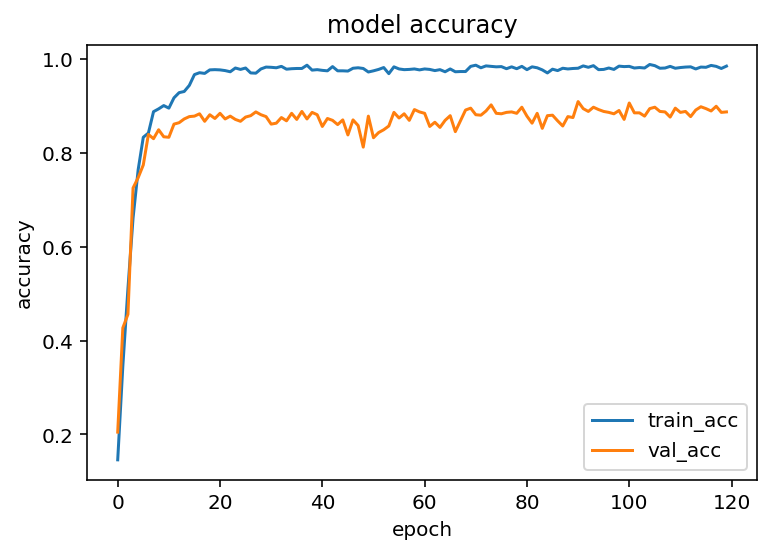

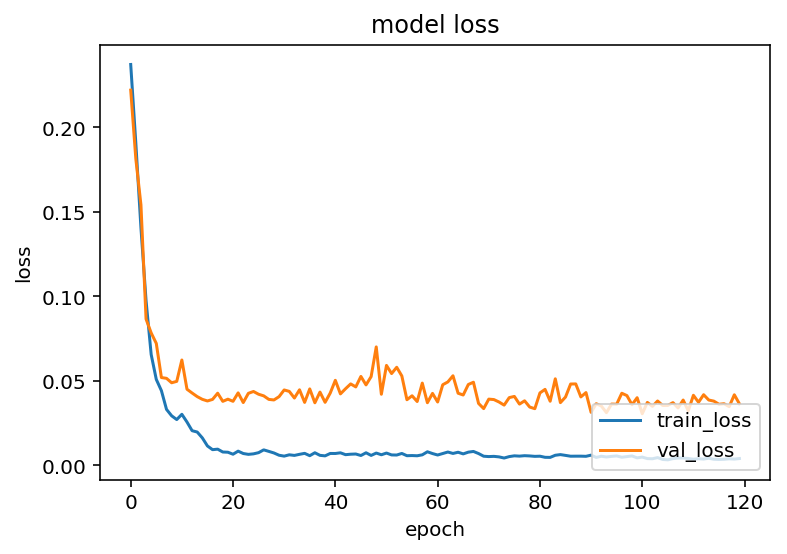

100%|██████████| 20/20 [00:02<00:00,  8.99it/s]
[2017-12-03 01:59:56,155 INFO] TestAcc: 0.9105 | TestLoss: 0.0307 
100%|██████████| 114/114 [00:12<00:00,  9.31it/s]
[2017-12-03 02:00:08,447 INFO] UnlabeledAcc: 0.9040 | UnlabeledLoss: 0.0331 
[2017-12-03 02:00:09,693 INFO] Epoch: 0 | TrainAcc: 0.1735 | TrainLoss: 0.2192
[2017-12-03 02:00:10,063 INFO] Epoch: 0 | ValAcc: 0.3310 | ValLoss: 0.2129 

[2017-12-03 02:00:11,632 INFO] Epoch: 1 | TrainAcc: 0.4600 | TrainLoss: 0.1549
[2017-12-03 02:00:12,154 INFO] Epoch: 1 | ValAcc: 0.5410 | ValLoss: 0.1319 

[2017-12-03 02:00:13,514 INFO] Epoch: 2 | TrainAcc: 0.6090 | TrainLoss: 0.1042
[2017-12-03 02:00:13,861 INFO] Epoch: 2 | ValAcc: 0.5550 | ValLoss: 0.1294 

[2017-12-03 02:00:15,093 INFO] Epoch: 3 | TrainAcc: 0.7310 | TrainLoss: 0.0769
[2017-12-03 02:00:15,431 INFO] Epoch: 3 | ValAcc: 0.7340 | ValLoss: 0.0745 

[2017-12-03 02:00:16,617 INFO] Epoch: 4 | TrainAcc: 0.8150 | TrainLoss: 0.0536
[2017-12-03 02:00:16,947 INFO] Epoch: 4 | ValAcc: 0.726

[2017-12-03 02:01:33,919 INFO] Epoch: 50 | ValAcc: 0.8690 | ValLoss: 0.0462 

[2017-12-03 02:01:35,152 INFO] Epoch: 51 | TrainAcc: 0.9760 | TrainLoss: 0.0071
[2017-12-03 02:01:35,498 INFO] Epoch: 51 | ValAcc: 0.8810 | ValLoss: 0.0426 

[2017-12-03 02:01:36,722 INFO] Epoch: 52 | TrainAcc: 0.9805 | TrainLoss: 0.0052
[2017-12-03 02:01:37,073 INFO] Epoch: 52 | ValAcc: 0.8680 | ValLoss: 0.0460 

[2017-12-03 02:01:38,309 INFO] Epoch: 53 | TrainAcc: 0.9730 | TrainLoss: 0.0065
[2017-12-03 02:01:38,669 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0430 

[2017-12-03 02:01:39,881 INFO] Epoch: 54 | TrainAcc: 0.9840 | TrainLoss: 0.0057
[2017-12-03 02:01:40,237 INFO] Epoch: 54 | ValAcc: 0.8750 | ValLoss: 0.0441 

[2017-12-03 02:01:41,495 INFO] Epoch: 55 | TrainAcc: 0.9820 | TrainLoss: 0.0054
[2017-12-03 02:01:41,845 INFO] Epoch: 55 | ValAcc: 0.8700 | ValLoss: 0.0480 

[2017-12-03 02:01:43,075 INFO] Epoch: 56 | TrainAcc: 0.9760 | TrainLoss: 0.0065
[2017-12-03 02:01:43,430 INFO] Epoch: 56 | ValAcc: 0

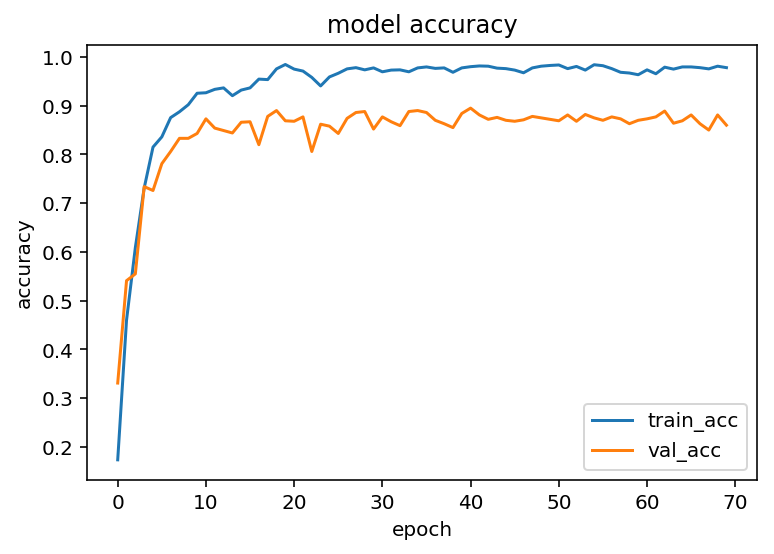

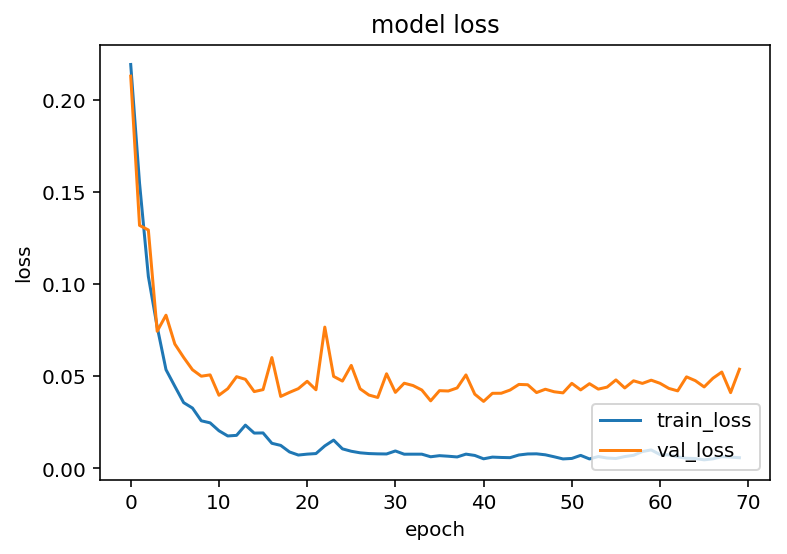

100%|██████████| 20/20 [00:03<00:00,  6.50it/s]
[2017-12-03 02:02:08,290 INFO] TestAcc: 0.9122 | TestLoss: 0.0301 
100%|██████████| 114/114 [00:14<00:00,  7.82it/s]
[2017-12-03 02:02:22,917 INFO] UnlabeledAcc: 0.8947 | UnlabeledLoss: 0.0346 
[2017-12-03 02:02:24,232 INFO] Epoch: 0 | TrainAcc: 0.1570 | TrainLoss: 0.2211
[2017-12-03 02:02:24,598 INFO] Epoch: 0 | ValAcc: 0.1590 | ValLoss: 0.2272 

[2017-12-03 02:02:25,889 INFO] Epoch: 1 | TrainAcc: 0.3065 | TrainLoss: 0.1980
[2017-12-03 02:02:26,321 INFO] Epoch: 1 | ValAcc: 0.3430 | ValLoss: 0.1941 

[2017-12-03 02:02:27,575 INFO] Epoch: 2 | TrainAcc: 0.4835 | TrainLoss: 0.1533
[2017-12-03 02:02:27,922 INFO] Epoch: 2 | ValAcc: 0.5380 | ValLoss: 0.1397 

[2017-12-03 02:02:29,413 INFO] Epoch: 3 | TrainAcc: 0.6510 | TrainLoss: 0.1030
[2017-12-03 02:02:29,842 INFO] Epoch: 3 | ValAcc: 0.5720 | ValLoss: 0.1447 

[2017-12-03 02:02:31,317 INFO] Epoch: 4 | TrainAcc: 0.7450 | TrainLoss: 0.0689
[2017-12-03 02:02:31,742 INFO] Epoch: 4 | ValAcc: 0.757

[2017-12-03 02:03:50,583 INFO] Epoch: 50 | ValAcc: 0.8720 | ValLoss: 0.0463 

[2017-12-03 02:03:51,826 INFO] Epoch: 51 | TrainAcc: 0.9785 | TrainLoss: 0.0060
[2017-12-03 02:03:52,175 INFO] Epoch: 51 | ValAcc: 0.9130 | ValLoss: 0.0315 

[2017-12-03 02:03:53,372 INFO] Epoch: 52 | TrainAcc: 0.9830 | TrainLoss: 0.0046
[2017-12-03 02:03:53,710 INFO] Epoch: 52 | ValAcc: 0.8910 | ValLoss: 0.0365 

[2017-12-03 02:03:54,934 INFO] Epoch: 53 | TrainAcc: 0.9885 | TrainLoss: 0.0034
[2017-12-03 02:03:55,285 INFO] Epoch: 53 | ValAcc: 0.8920 | ValLoss: 0.0379 

[2017-12-03 02:03:56,487 INFO] Epoch: 54 | TrainAcc: 0.9850 | TrainLoss: 0.0043
[2017-12-03 02:03:56,820 INFO] Epoch: 54 | ValAcc: 0.8880 | ValLoss: 0.0379 

[2017-12-03 02:03:58,063 INFO] Epoch: 55 | TrainAcc: 0.9845 | TrainLoss: 0.0040
[2017-12-03 02:03:58,416 INFO] Epoch: 55 | ValAcc: 0.8650 | ValLoss: 0.0489 

[2017-12-03 02:03:59,627 INFO] Epoch: 56 | TrainAcc: 0.9820 | TrainLoss: 0.0048
[2017-12-03 02:03:59,988 INFO] Epoch: 56 | ValAcc: 0

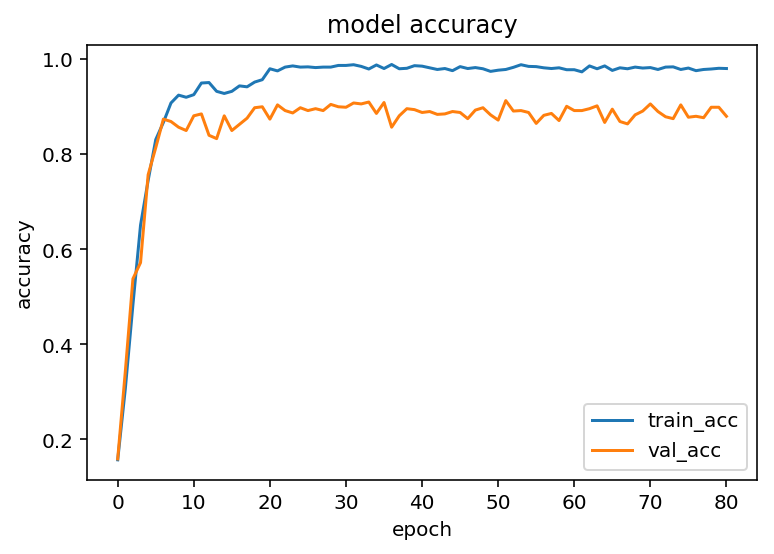

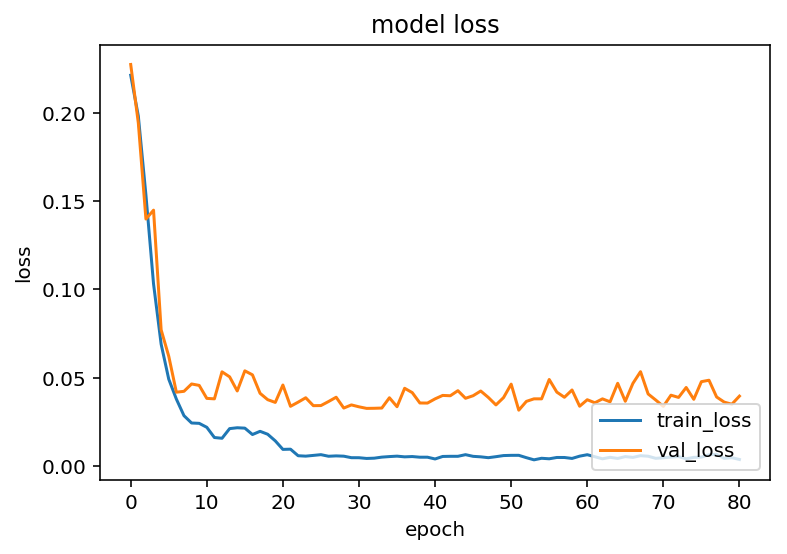

100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
[2017-12-03 02:04:40,582 INFO] TestAcc: 0.9190 | TestLoss: 0.0267 
100%|██████████| 114/114 [00:12<00:00,  9.50it/s]
[2017-12-03 02:04:52,632 INFO] UnlabeledAcc: 0.9133 | UnlabeledLoss: 0.0286 
[2017-12-03 02:04:53,928 INFO] Epoch: 0 | TrainAcc: 0.2025 | TrainLoss: 0.2193
[2017-12-03 02:04:54,405 INFO] Epoch: 0 | ValAcc: 0.1630 | ValLoss: 0.2216 

[2017-12-03 02:04:55,761 INFO] Epoch: 1 | TrainAcc: 0.3310 | TrainLoss: 0.1840
[2017-12-03 02:04:56,216 INFO] Epoch: 1 | ValAcc: 0.3930 | ValLoss: 0.1807 

[2017-12-03 02:04:57,557 INFO] Epoch: 2 | TrainAcc: 0.4650 | TrainLoss: 0.1449
[2017-12-03 02:04:58,005 INFO] Epoch: 2 | ValAcc: 0.4420 | ValLoss: 0.1604 

[2017-12-03 02:04:59,395 INFO] Epoch: 3 | TrainAcc: 0.6395 | TrainLoss: 0.1016
[2017-12-03 02:04:59,850 INFO] Epoch: 3 | ValAcc: 0.6750 | ValLoss: 0.0968 

[2017-12-03 02:05:01,224 INFO] Epoch: 4 | TrainAcc: 0.8005 | TrainLoss: 0.0593
[2017-12-03 02:05:01,683 INFO] Epoch: 4 | ValAcc: 0.731

[2017-12-03 02:06:26,334 INFO] Epoch: 50 | ValAcc: 0.8520 | ValLoss: 0.0539 

[2017-12-03 02:06:27,714 INFO] Epoch: 51 | TrainAcc: 0.9750 | TrainLoss: 0.0058
[2017-12-03 02:06:28,168 INFO] Epoch: 51 | ValAcc: 0.8680 | ValLoss: 0.0421 

[2017-12-03 02:06:29,555 INFO] Epoch: 52 | TrainAcc: 0.9775 | TrainLoss: 0.0063
[2017-12-03 02:06:30,001 INFO] Epoch: 52 | ValAcc: 0.8690 | ValLoss: 0.0467 

[2017-12-03 02:06:31,385 INFO] Epoch: 53 | TrainAcc: 0.9785 | TrainLoss: 0.0058
[2017-12-03 02:06:31,832 INFO] Epoch: 53 | ValAcc: 0.8580 | ValLoss: 0.0476 

[2017-12-03 02:06:33,208 INFO] Epoch: 54 | TrainAcc: 0.9790 | TrainLoss: 0.0065
[2017-12-03 02:06:33,664 INFO] Epoch: 54 | ValAcc: 0.8750 | ValLoss: 0.0440 

[2017-12-03 02:06:35,037 INFO] Epoch: 55 | TrainAcc: 0.9795 | TrainLoss: 0.0054
[2017-12-03 02:06:35,489 INFO] Epoch: 55 | ValAcc: 0.8640 | ValLoss: 0.0447 

[2017-12-03 02:06:36,849 INFO] Epoch: 56 | TrainAcc: 0.9765 | TrainLoss: 0.0060
[2017-12-03 02:06:37,296 INFO] Epoch: 56 | ValAcc: 0

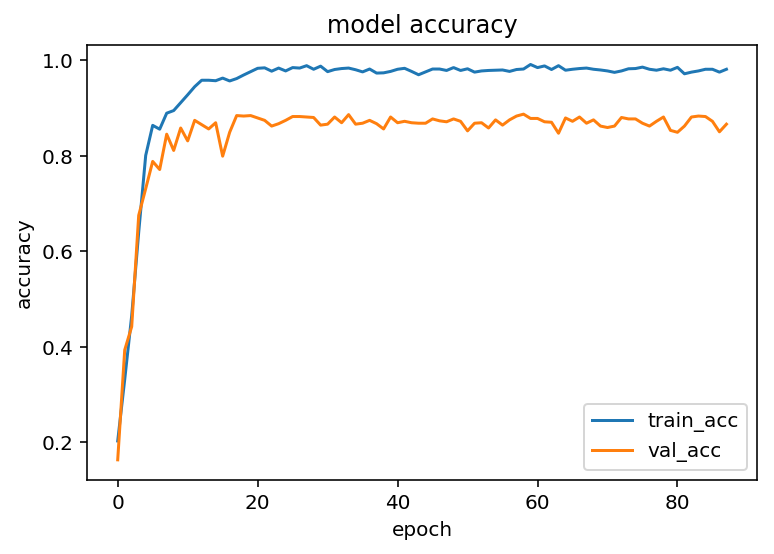

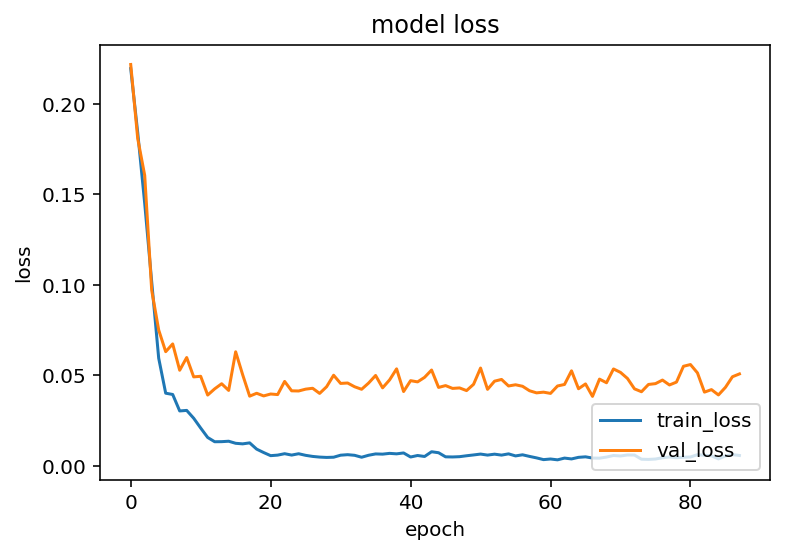

100%|██████████| 20/20 [00:02<00:00,  9.32it/s]
[2017-12-03 02:07:36,500 INFO] TestAcc: 0.9087 | TestLoss: 0.0302 
100%|██████████| 114/114 [00:11<00:00,  9.54it/s]
[2017-12-03 02:07:48,499 INFO] UnlabeledAcc: 0.8978 | UnlabeledLoss: 0.0343 


In [13]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = False
ex_name = 'pseudo_soft'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results_soft = {}
results_soft['test_acc'] = np.empty((trial_times))
results_soft['test_loss'] = np.empty((trial_times))
results_soft['unlabeled_acc'] = np.empty((trial_times))
results_soft['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_soft['test_acc'][i], results_soft['test_loss'][i] = _test(model, test_loader, criterion)
    results_soft['unlabeled_acc'][i], results_soft['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [14]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['test_acc']),
    np.std(results_soft['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_soft['test_loss']),
    np.std(results_soft['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_acc']),
    np.std(results_soft['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_loss']),
    np.std(results_soft['unlabeled_loss'])
))

[2017-12-03 02:07:48,604 INFO] Test Accuracy: 0.9118 ± 0.0038
[2017-12-03 02:07:48,606 INFO] Test Loss: 0.0294 ± 0.0014

[2017-12-03 02:07:48,608 INFO] Unlabeled Accuracy: 0.9026 ± 0.0054
[2017-12-03 02:07:48,622 INFO] Unlabeled Loss: 0.0323 ± 0.0018


In [15]:
from scipy import stats

t, p = stats.ttest_rel(results['test_acc'], results_soft['test_acc'])
print( "Pseudo Labelingのsoftとhardに有意差はあるか？：p値 = %(p)s" %locals() )

Pseudo Labelingのsoftとhardに有意差はあるか？：p値 = 0.62029083828


## annealing strategy on soft

[2017-12-03 03:59:16,469 INFO] 0.0
[2017-12-03 03:59:17,193 INFO] Epoch: 0 | TrainAcc: 0.1390 | TrainLoss: 0.2417
[2017-12-03 03:59:17,571 INFO] Epoch: 0 | ValAcc: 0.1080 | ValLoss: 0.2280 

[2017-12-03 03:59:17,597 INFO] 0.0
[2017-12-03 03:59:18,370 INFO] Epoch: 1 | TrainAcc: 0.2550 | TrainLoss: 0.2164
[2017-12-03 03:59:18,834 INFO] Epoch: 1 | ValAcc: 0.3120 | ValLoss: 0.2180 

[2017-12-03 03:59:18,871 INFO] 0.0
[2017-12-03 03:59:19,617 INFO] Epoch: 2 | TrainAcc: 0.3460 | TrainLoss: 0.1977
[2017-12-03 03:59:19,985 INFO] Epoch: 2 | ValAcc: 0.3840 | ValLoss: 0.1888 

[2017-12-03 03:59:20,010 INFO] 0.0
[2017-12-03 03:59:20,689 INFO] Epoch: 3 | TrainAcc: 0.5480 | TrainLoss: 0.1525
[2017-12-03 03:59:21,090 INFO] Epoch: 3 | ValAcc: 0.5240 | ValLoss: 0.1518 

[2017-12-03 03:59:21,119 INFO] 0.0
[2017-12-03 03:59:21,852 INFO] Epoch: 4 | TrainAcc: 0.6550 | TrainLoss: 0.1117
[2017-12-03 03:59:22,252 INFO] Epoch: 4 | ValAcc: 0.5000 | ValLoss: 0.1433 

[2017-12-03 03:59:22,278 INFO] 0.0
[2017-12-0

[2017-12-03 04:00:14,109 INFO] Epoch: 42 | ValAcc: 0.8550 | ValLoss: 0.0499 

[2017-12-03 04:00:14,138 INFO] 0.66
[2017-12-03 04:00:15,173 INFO] Epoch: 43 | TrainAcc: 0.9861 | TrainLoss: 0.0073
[2017-12-03 04:00:15,523 INFO] Epoch: 43 | ValAcc: 0.8500 | ValLoss: 0.0494 

[2017-12-03 04:00:15,543 INFO] 0.68
[2017-12-03 04:00:16,576 INFO] Epoch: 44 | TrainAcc: 0.9744 | TrainLoss: 0.0081
[2017-12-03 04:00:16,911 INFO] Epoch: 44 | ValAcc: 0.8140 | ValLoss: 0.0727 

[2017-12-03 04:00:16,936 INFO] 0.7000000000000001
[2017-12-03 04:00:18,016 INFO] Epoch: 45 | TrainAcc: 0.9747 | TrainLoss: 0.0091
[2017-12-03 04:00:18,346 INFO] Epoch: 45 | ValAcc: 0.8400 | ValLoss: 0.0638 

[2017-12-03 04:00:18,368 INFO] 0.72
[2017-12-03 04:00:19,442 INFO] Epoch: 46 | TrainAcc: 0.9703 | TrainLoss: 0.0099
[2017-12-03 04:00:19,786 INFO] Epoch: 46 | ValAcc: 0.8370 | ValLoss: 0.0607 

[2017-12-03 04:00:19,809 INFO] 0.74
[2017-12-03 04:00:20,896 INFO] Epoch: 47 | TrainAcc: 0.9741 | TrainLoss: 0.0093
[2017-12-03 04:0

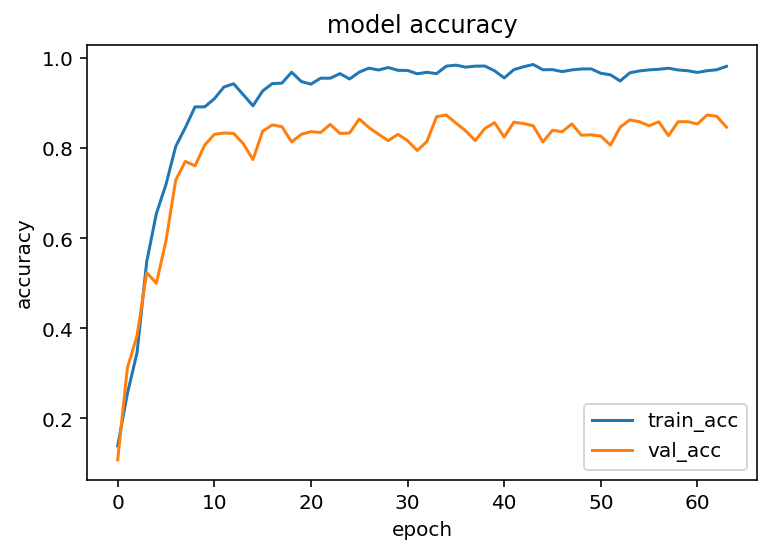

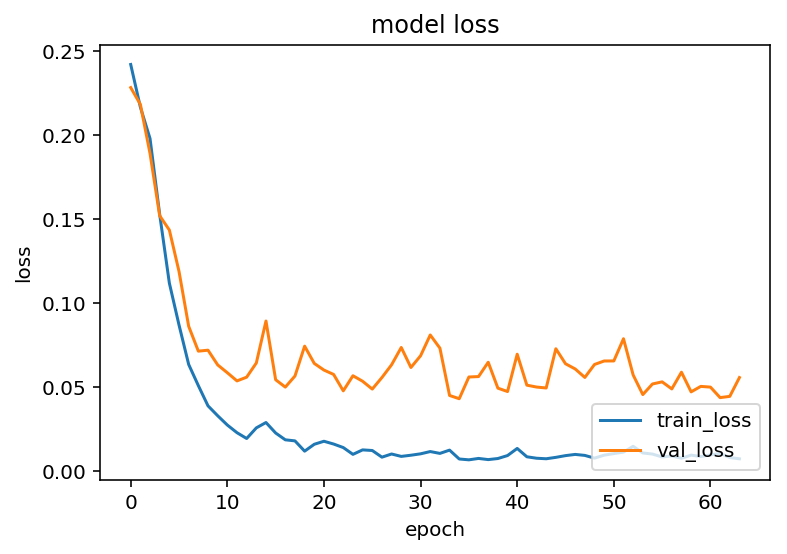

100%|██████████| 20/20 [00:03<00:00,  6.33it/s]
[2017-12-03 04:00:53,222 INFO] TestAcc: 0.8921 | TestLoss: 0.0372 
100%|██████████| 114/114 [00:12<00:00,  9.09it/s]
[2017-12-03 04:01:05,827 INFO] UnlabeledAcc: 0.8862 | UnlabeledLoss: 0.0400 
[2017-12-03 04:01:05,862 INFO] 0.0
[2017-12-03 04:01:06,531 INFO] Epoch: 0 | TrainAcc: 0.1390 | TrainLoss: 0.2467
[2017-12-03 04:01:06,901 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2323 

[2017-12-03 04:01:06,928 INFO] 0.0
[2017-12-03 04:01:07,638 INFO] Epoch: 1 | TrainAcc: 0.1720 | TrainLoss: 0.2275
[2017-12-03 04:01:08,076 INFO] Epoch: 1 | ValAcc: 0.1240 | ValLoss: 0.2274 

[2017-12-03 04:01:08,100 INFO] 0.0
[2017-12-03 04:01:08,791 INFO] Epoch: 2 | TrainAcc: 0.2830 | TrainLoss: 0.2156
[2017-12-03 04:01:09,140 INFO] Epoch: 2 | ValAcc: 0.2500 | ValLoss: 0.2126 

[2017-12-03 04:01:09,164 INFO] 0.0
[2017-12-03 04:01:09,926 INFO] Epoch: 3 | TrainAcc: 0.3270 | TrainLoss: 0.1975
[2017-12-03 04:01:10,280 INFO] Epoch: 3 | ValAcc: 0.3520 | ValLoss: 0.1

[2017-12-03 04:01:58,599 INFO] Epoch: 41 | TrainAcc: 0.9722 | TrainLoss: 0.0131
[2017-12-03 04:01:58,933 INFO] Epoch: 41 | ValAcc: 0.8710 | ValLoss: 0.0483 

[2017-12-03 04:01:58,954 INFO] 0.64
[2017-12-03 04:02:00,024 INFO] Epoch: 42 | TrainAcc: 0.9866 | TrainLoss: 0.0084
[2017-12-03 04:02:00,541 INFO] Epoch: 42 | ValAcc: 0.8620 | ValLoss: 0.0469 

[2017-12-03 04:02:00,570 INFO] 0.66
[2017-12-03 04:02:01,814 INFO] Epoch: 43 | TrainAcc: 0.9837 | TrainLoss: 0.0084
[2017-12-03 04:02:02,169 INFO] Epoch: 43 | ValAcc: 0.8800 | ValLoss: 0.0419 

[2017-12-03 04:02:02,192 INFO] 0.68
[2017-12-03 04:02:03,213 INFO] Epoch: 44 | TrainAcc: 0.9875 | TrainLoss: 0.0067
[2017-12-03 04:02:03,559 INFO] Epoch: 44 | ValAcc: 0.8770 | ValLoss: 0.0464 

[2017-12-03 04:02:03,586 INFO] 0.7000000000000001
[2017-12-03 04:02:04,861 INFO] Epoch: 45 | TrainAcc: 0.9688 | TrainLoss: 0.0100
[2017-12-03 04:02:05,182 INFO] Epoch: 45 | ValAcc: 0.8640 | ValLoss: 0.0478 

[2017-12-03 04:02:05,203 INFO] 0.72
[2017-12-03 04:0

[2017-12-03 04:03:06,805 INFO] Epoch: 83 | TrainAcc: 0.9593 | TrainLoss: 0.0110
[2017-12-03 04:03:07,124 INFO] Epoch: 83 | ValAcc: 0.8670 | ValLoss: 0.0418 

[2017-12-03 04:03:07,146 INFO] 1.48
[2017-12-03 04:03:08,617 INFO] Epoch: 84 | TrainAcc: 0.9673 | TrainLoss: 0.0105
[2017-12-03 04:03:08,944 INFO] Epoch: 84 | ValAcc: 0.8850 | ValLoss: 0.0378 

[2017-12-03 04:03:08,966 INFO] 1.5
[2017-12-03 04:03:10,464 INFO] Epoch: 85 | TrainAcc: 0.9648 | TrainLoss: 0.0102
[2017-12-03 04:03:10,804 INFO] Epoch: 85 | ValAcc: 0.8730 | ValLoss: 0.0421 

[2017-12-03 04:03:10,826 INFO] 1.5
[2017-12-03 04:03:12,287 INFO] Epoch: 86 | TrainAcc: 0.9676 | TrainLoss: 0.0084
[2017-12-03 04:03:12,627 INFO] Epoch: 86 | ValAcc: 0.8790 | ValLoss: 0.0383 

[2017-12-03 04:03:12,649 INFO] 1.5
[2017-12-03 04:03:14,094 INFO] Epoch: 87 | TrainAcc: 0.9700 | TrainLoss: 0.0070
[2017-12-03 04:03:14,447 INFO] Epoch: 87 | ValAcc: 0.8640 | ValLoss: 0.0406 

[2017-12-03 04:03:14,469 INFO] 1.5
[2017-12-03 04:03:16,095 INFO] Epo

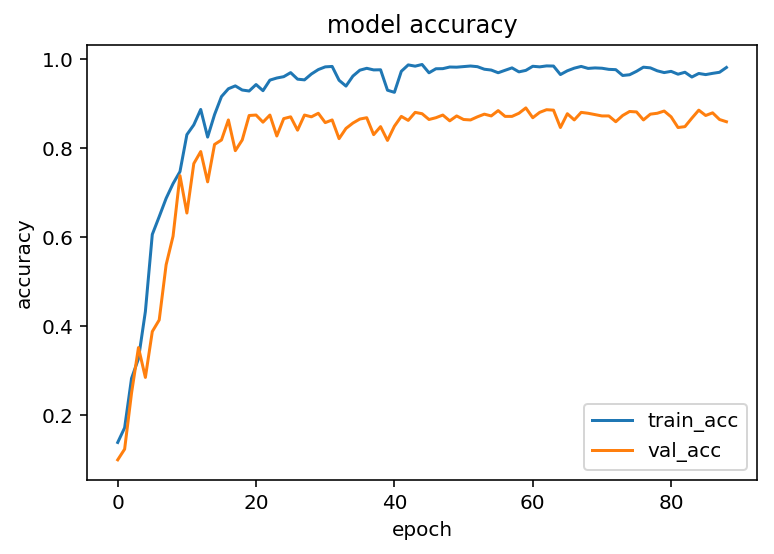

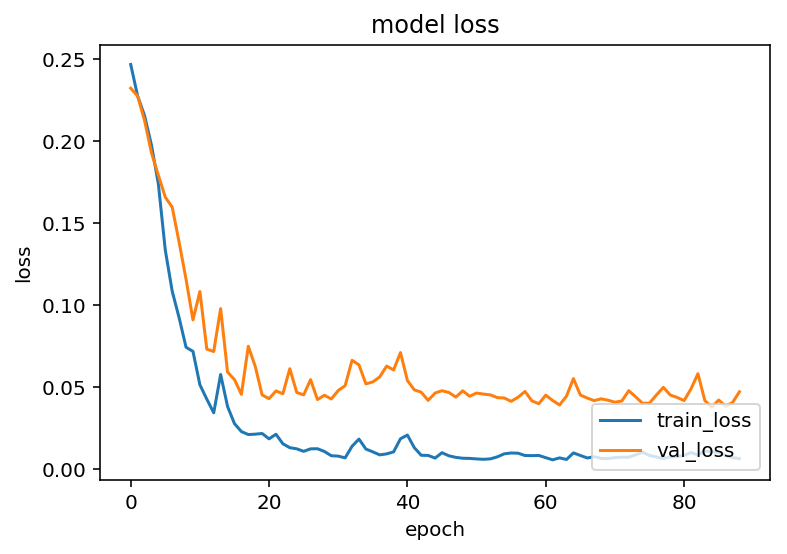

100%|██████████| 20/20 [00:02<00:00,  9.64it/s]
[2017-12-03 04:03:18,865 INFO] TestAcc: 0.8982 | TestLoss: 0.0334 
100%|██████████| 114/114 [00:11<00:00,  9.60it/s]
[2017-12-03 04:03:30,786 INFO] UnlabeledAcc: 0.8937 | UnlabeledLoss: 0.0352 
[2017-12-03 04:03:30,813 INFO] 0.0
[2017-12-03 04:03:31,461 INFO] Epoch: 0 | TrainAcc: 0.1370 | TrainLoss: 0.2346
[2017-12-03 04:03:31,808 INFO] Epoch: 0 | ValAcc: 0.2250 | ValLoss: 0.2280 

[2017-12-03 04:03:31,832 INFO] 0.0
[2017-12-03 04:03:32,497 INFO] Epoch: 1 | TrainAcc: 0.2170 | TrainLoss: 0.2157
[2017-12-03 04:03:32,837 INFO] Epoch: 1 | ValAcc: 0.3110 | ValLoss: 0.2153 

[2017-12-03 04:03:32,861 INFO] 0.0
[2017-12-03 04:03:33,515 INFO] Epoch: 2 | TrainAcc: 0.3930 | TrainLoss: 0.1841
[2017-12-03 04:03:33,857 INFO] Epoch: 2 | ValAcc: 0.3200 | ValLoss: 0.1922 

[2017-12-03 04:03:33,881 INFO] 0.0
[2017-12-03 04:03:34,531 INFO] Epoch: 3 | TrainAcc: 0.4810 | TrainLoss: 0.1556
[2017-12-03 04:03:34,870 INFO] Epoch: 3 | ValAcc: 0.4540 | ValLoss: 0.1

[2017-12-03 04:04:18,829 INFO] Epoch: 41 | TrainAcc: 0.9414 | TrainLoss: 0.0161
[2017-12-03 04:04:19,167 INFO] Epoch: 41 | ValAcc: 0.8790 | ValLoss: 0.0417 

[2017-12-03 04:04:19,188 INFO] 0.64
[2017-12-03 04:04:20,168 INFO] Epoch: 42 | TrainAcc: 0.9695 | TrainLoss: 0.0105
[2017-12-03 04:04:20,496 INFO] Epoch: 42 | ValAcc: 0.8870 | ValLoss: 0.0410 

[2017-12-03 04:04:20,518 INFO] 0.66
[2017-12-03 04:04:21,489 INFO] Epoch: 43 | TrainAcc: 0.9771 | TrainLoss: 0.0088
[2017-12-03 04:04:21,847 INFO] Epoch: 43 | ValAcc: 0.8940 | ValLoss: 0.0395 

[2017-12-03 04:04:21,869 INFO] 0.68
[2017-12-03 04:04:22,897 INFO] Epoch: 44 | TrainAcc: 0.9774 | TrainLoss: 0.0094
[2017-12-03 04:04:23,224 INFO] Epoch: 44 | ValAcc: 0.8810 | ValLoss: 0.0469 

[2017-12-03 04:04:23,249 INFO] 0.7000000000000001
[2017-12-03 04:04:24,251 INFO] Epoch: 45 | TrainAcc: 0.9653 | TrainLoss: 0.0123
[2017-12-03 04:04:24,574 INFO] Epoch: 45 | ValAcc: 0.8880 | ValLoss: 0.0370 

[2017-12-03 04:04:24,595 INFO] 0.72
[2017-12-03 04:0

[2017-12-03 04:05:25,860 INFO] Epoch: 83 | TrainAcc: 0.9691 | TrainLoss: 0.0086
[2017-12-03 04:05:26,175 INFO] Epoch: 83 | ValAcc: 0.8860 | ValLoss: 0.0395 

[2017-12-03 04:05:26,200 INFO] 1.48
[2017-12-03 04:05:27,637 INFO] Epoch: 84 | TrainAcc: 0.9710 | TrainLoss: 0.0081
[2017-12-03 04:05:27,959 INFO] Epoch: 84 | ValAcc: 0.8990 | ValLoss: 0.0338 

[2017-12-03 04:05:27,980 INFO] 1.5
[2017-12-03 04:05:29,459 INFO] Epoch: 85 | TrainAcc: 0.9696 | TrainLoss: 0.0080
[2017-12-03 04:05:29,802 INFO] Epoch: 85 | ValAcc: 0.8950 | ValLoss: 0.0369 

[2017-12-03 04:05:29,824 INFO] 1.5
[2017-12-03 04:05:31,284 INFO] Epoch: 86 | TrainAcc: 0.9776 | TrainLoss: 0.0063
[2017-12-03 04:05:31,612 INFO] Epoch: 86 | ValAcc: 0.9010 | ValLoss: 0.0337 

[2017-12-03 04:05:31,635 INFO] 1.5
[2017-12-03 04:05:33,122 INFO] Epoch: 87 | TrainAcc: 0.9812 | TrainLoss: 0.0061
[2017-12-03 04:05:33,466 INFO] Epoch: 87 | ValAcc: 0.8970 | ValLoss: 0.0343 

[2017-12-03 04:05:33,489 INFO] 1.5
[2017-12-03 04:05:34,981 INFO] Epo

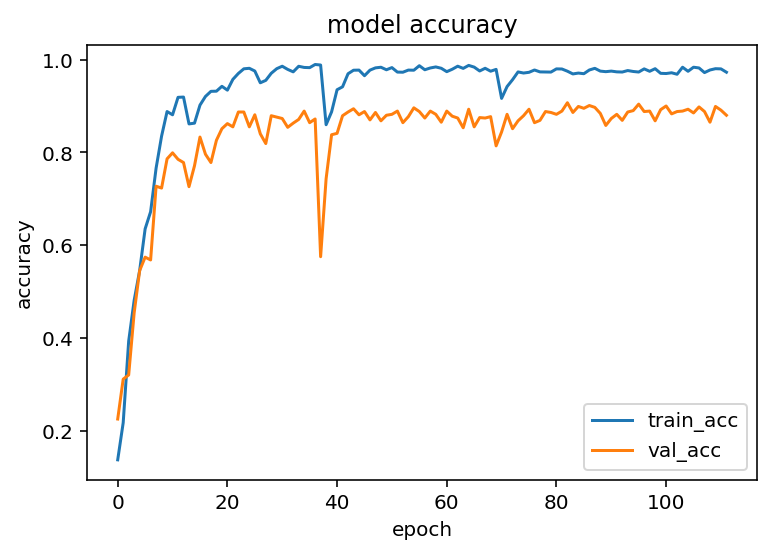

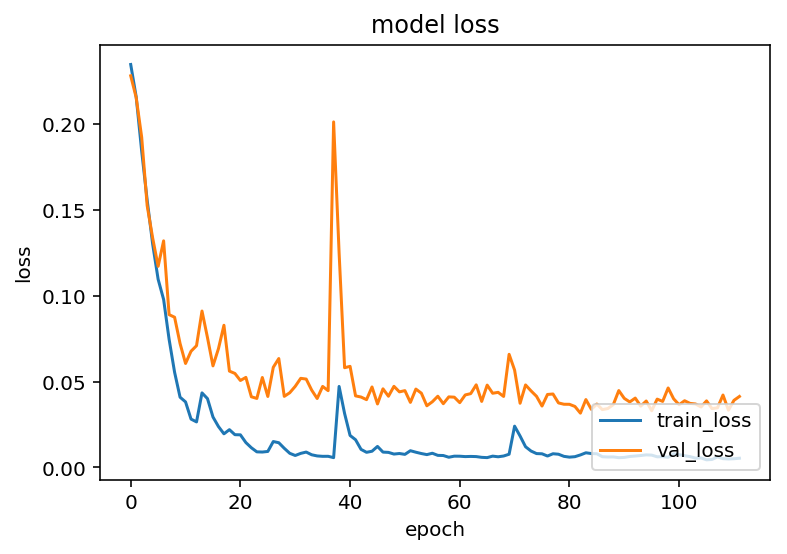

100%|██████████| 20/20 [00:02<00:00,  8.01it/s]
[2017-12-03 04:06:22,621 INFO] TestAcc: 0.9164 | TestLoss: 0.0272 
100%|██████████| 114/114 [00:13<00:00,  8.21it/s]
[2017-12-03 04:06:36,550 INFO] UnlabeledAcc: 0.9081 | UnlabeledLoss: 0.0302 
[2017-12-03 04:06:36,577 INFO] 0.0
[2017-12-03 04:06:37,223 INFO] Epoch: 0 | TrainAcc: 0.1320 | TrainLoss: 0.2450
[2017-12-03 04:06:37,582 INFO] Epoch: 0 | ValAcc: 0.1380 | ValLoss: 0.2302 

[2017-12-03 04:06:37,606 INFO] 0.0
[2017-12-03 04:06:38,257 INFO] Epoch: 1 | TrainAcc: 0.1890 | TrainLoss: 0.2269
[2017-12-03 04:06:38,599 INFO] Epoch: 1 | ValAcc: 0.1220 | ValLoss: 0.2229 

[2017-12-03 04:06:38,623 INFO] 0.0
[2017-12-03 04:06:39,279 INFO] Epoch: 2 | TrainAcc: 0.2750 | TrainLoss: 0.2013
[2017-12-03 04:06:39,633 INFO] Epoch: 2 | ValAcc: 0.2970 | ValLoss: 0.1980 

[2017-12-03 04:06:39,657 INFO] 0.0
[2017-12-03 04:06:40,337 INFO] Epoch: 3 | TrainAcc: 0.4130 | TrainLoss: 0.1726
[2017-12-03 04:06:40,678 INFO] Epoch: 3 | ValAcc: 0.3400 | ValLoss: 0.1

[2017-12-03 04:07:27,286 INFO] Epoch: 41 | TrainAcc: 0.9389 | TrainLoss: 0.0182
[2017-12-03 04:07:27,650 INFO] Epoch: 41 | ValAcc: 0.8820 | ValLoss: 0.0422 

[2017-12-03 04:07:27,672 INFO] 0.64
[2017-12-03 04:07:28,684 INFO] Epoch: 42 | TrainAcc: 0.9579 | TrainLoss: 0.0140
[2017-12-03 04:07:29,041 INFO] Epoch: 42 | ValAcc: 0.9010 | ValLoss: 0.0346 

[2017-12-03 04:07:29,064 INFO] 0.66
[2017-12-03 04:07:30,066 INFO] Epoch: 43 | TrainAcc: 0.9759 | TrainLoss: 0.0087
[2017-12-03 04:07:30,416 INFO] Epoch: 43 | ValAcc: 0.8870 | ValLoss: 0.0395 

[2017-12-03 04:07:30,440 INFO] 0.68
[2017-12-03 04:07:31,471 INFO] Epoch: 44 | TrainAcc: 0.9786 | TrainLoss: 0.0084
[2017-12-03 04:07:31,809 INFO] Epoch: 44 | ValAcc: 0.9000 | ValLoss: 0.0346 

[2017-12-03 04:07:31,831 INFO] 0.7000000000000001
[2017-12-03 04:07:32,890 INFO] Epoch: 45 | TrainAcc: 0.9735 | TrainLoss: 0.0086
[2017-12-03 04:07:33,218 INFO] Epoch: 45 | ValAcc: 0.8720 | ValLoss: 0.0453 

[2017-12-03 04:07:33,245 INFO] 0.72
[2017-12-03 04:0

[2017-12-03 04:08:35,467 INFO] Epoch: 83 | TrainAcc: 0.9724 | TrainLoss: 0.0073
[2017-12-03 04:08:35,797 INFO] Epoch: 83 | ValAcc: 0.8950 | ValLoss: 0.0333 

[2017-12-03 04:08:35,820 INFO] 1.48
[2017-12-03 04:08:37,300 INFO] Epoch: 84 | TrainAcc: 0.9677 | TrainLoss: 0.0062
[2017-12-03 04:08:37,638 INFO] Epoch: 84 | ValAcc: 0.9170 | ValLoss: 0.0276 

[2017-12-03 04:08:37,661 INFO] 1.5
[2017-12-03 04:08:39,171 INFO] Epoch: 85 | TrainAcc: 0.9804 | TrainLoss: 0.0070
[2017-12-03 04:08:39,518 INFO] Epoch: 85 | ValAcc: 0.9100 | ValLoss: 0.0326 

[2017-12-03 04:08:39,547 INFO] 1.5
[2017-12-03 04:08:41,026 INFO] Epoch: 86 | TrainAcc: 0.9696 | TrainLoss: 0.0066
[2017-12-03 04:08:41,387 INFO] Epoch: 86 | ValAcc: 0.9170 | ValLoss: 0.0272 

[2017-12-03 04:08:41,411 INFO] 1.5
[2017-12-03 04:08:42,890 INFO] Epoch: 87 | TrainAcc: 0.9688 | TrainLoss: 0.0070
[2017-12-03 04:08:43,246 INFO] Epoch: 87 | ValAcc: 0.9080 | ValLoss: 0.0296 

[2017-12-03 04:08:43,268 INFO] 1.5
[2017-12-03 04:08:44,746 INFO] Epo

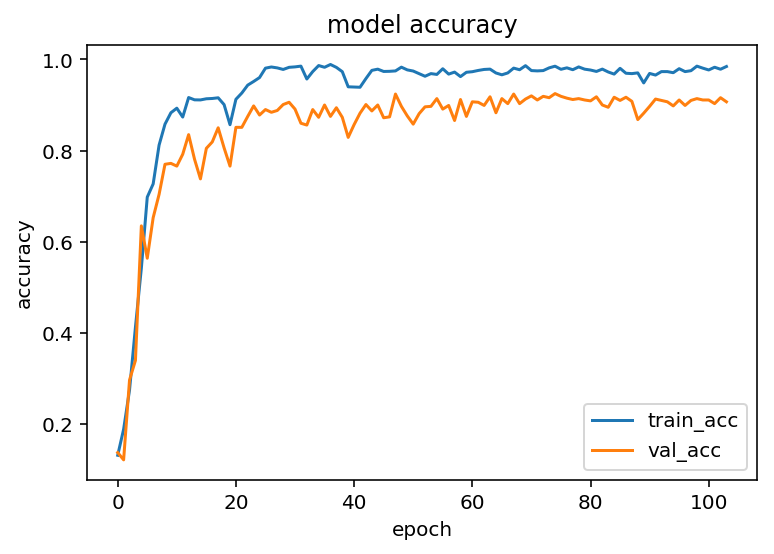

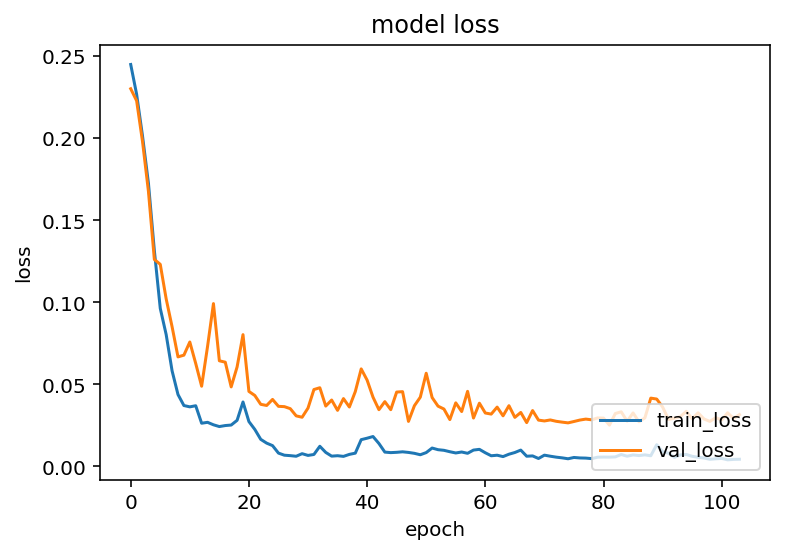

100%|██████████| 20/20 [00:02<00:00,  8.87it/s]
[2017-12-03 04:09:15,775 INFO] TestAcc: 0.9192 | TestLoss: 0.0270 
100%|██████████| 114/114 [00:12<00:00,  9.47it/s]
[2017-12-03 04:09:27,862 INFO] UnlabeledAcc: 0.9114 | UnlabeledLoss: 0.0293 
[2017-12-03 04:09:27,891 INFO] 0.0
[2017-12-03 04:09:28,549 INFO] Epoch: 0 | TrainAcc: 0.0940 | TrainLoss: 0.2442
[2017-12-03 04:09:28,908 INFO] Epoch: 0 | ValAcc: 0.1070 | ValLoss: 0.2295 

[2017-12-03 04:09:28,932 INFO] 0.0
[2017-12-03 04:09:29,587 INFO] Epoch: 1 | TrainAcc: 0.1900 | TrainLoss: 0.2256
[2017-12-03 04:09:29,940 INFO] Epoch: 1 | ValAcc: 0.2360 | ValLoss: 0.2263 

[2017-12-03 04:09:29,965 INFO] 0.0
[2017-12-03 04:09:30,637 INFO] Epoch: 2 | TrainAcc: 0.2750 | TrainLoss: 0.2126
[2017-12-03 04:09:30,984 INFO] Epoch: 2 | ValAcc: 0.2420 | ValLoss: 0.2108 

[2017-12-03 04:09:31,009 INFO] 0.0
[2017-12-03 04:09:31,675 INFO] Epoch: 3 | TrainAcc: 0.3560 | TrainLoss: 0.1870
[2017-12-03 04:09:32,030 INFO] Epoch: 3 | ValAcc: 0.3170 | ValLoss: 0.1

[2017-12-03 04:10:17,034 INFO] Epoch: 41 | TrainAcc: 0.9747 | TrainLoss: 0.0085
[2017-12-03 04:10:17,385 INFO] Epoch: 41 | ValAcc: 0.8890 | ValLoss: 0.0414 

[2017-12-03 04:10:17,408 INFO] 0.64
[2017-12-03 04:10:18,446 INFO] Epoch: 42 | TrainAcc: 0.9787 | TrainLoss: 0.0075
[2017-12-03 04:10:18,793 INFO] Epoch: 42 | ValAcc: 0.8970 | ValLoss: 0.0395 

[2017-12-03 04:10:18,817 INFO] 0.66
[2017-12-03 04:10:19,872 INFO] Epoch: 43 | TrainAcc: 0.9813 | TrainLoss: 0.0063
[2017-12-03 04:10:20,240 INFO] Epoch: 43 | ValAcc: 0.8750 | ValLoss: 0.0443 

[2017-12-03 04:10:20,261 INFO] 0.68
[2017-12-03 04:10:21,313 INFO] Epoch: 44 | TrainAcc: 0.9798 | TrainLoss: 0.0079
[2017-12-03 04:10:21,651 INFO] Epoch: 44 | ValAcc: 0.8940 | ValLoss: 0.0395 

[2017-12-03 04:10:21,673 INFO] 0.7000000000000001
[2017-12-03 04:10:22,727 INFO] Epoch: 45 | TrainAcc: 0.9618 | TrainLoss: 0.0088
[2017-12-03 04:10:23,066 INFO] Epoch: 45 | ValAcc: 0.8810 | ValLoss: 0.0448 

[2017-12-03 04:10:23,089 INFO] 0.72
[2017-12-03 04:1

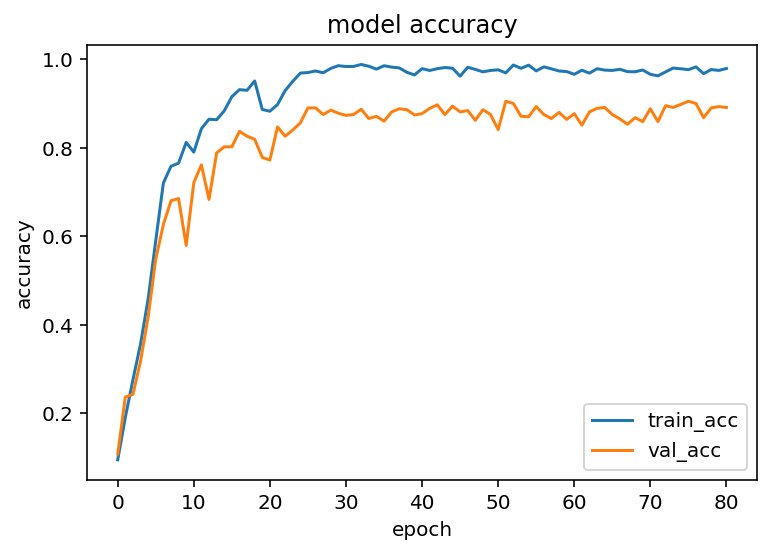

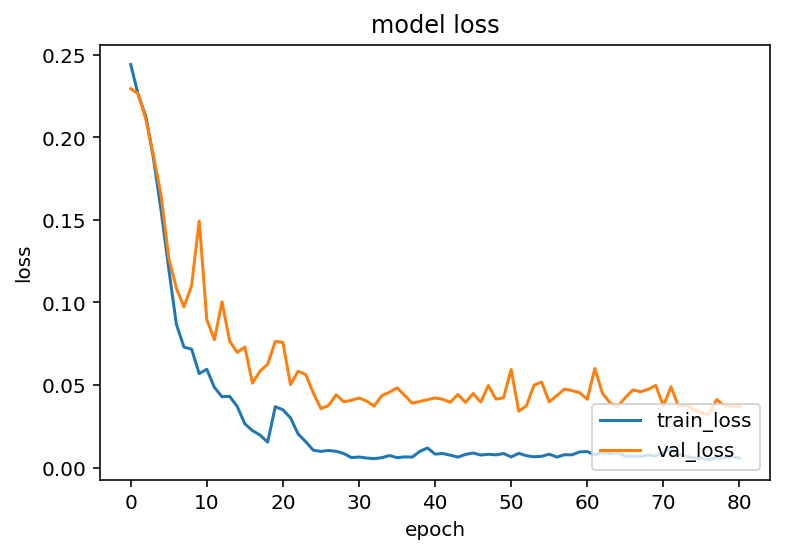

100%|██████████| 20/20 [00:02<00:00,  8.78it/s]
[2017-12-03 04:11:31,153 INFO] TestAcc: 0.9083 | TestLoss: 0.0316 
100%|██████████| 114/114 [00:12<00:00,  9.22it/s]
[2017-12-03 04:11:43,573 INFO] UnlabeledAcc: 0.8964 | UnlabeledLoss: 0.0355 
[2017-12-03 04:11:43,605 INFO] 0.0
[2017-12-03 04:11:44,246 INFO] Epoch: 0 | TrainAcc: 0.1140 | TrainLoss: 0.2451
[2017-12-03 04:11:44,601 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2293 

[2017-12-03 04:11:44,627 INFO] 0.0
[2017-12-03 04:11:45,303 INFO] Epoch: 1 | TrainAcc: 0.2540 | TrainLoss: 0.2171
[2017-12-03 04:11:45,654 INFO] Epoch: 1 | ValAcc: 0.2750 | ValLoss: 0.2175 

[2017-12-03 04:11:45,679 INFO] 0.0
[2017-12-03 04:11:46,341 INFO] Epoch: 2 | TrainAcc: 0.3710 | TrainLoss: 0.1930
[2017-12-03 04:11:46,698 INFO] Epoch: 2 | ValAcc: 0.4210 | ValLoss: 0.1906 

[2017-12-03 04:11:46,725 INFO] 0.0
[2017-12-03 04:11:47,411 INFO] Epoch: 3 | TrainAcc: 0.4110 | TrainLoss: 0.1674
[2017-12-03 04:11:47,765 INFO] Epoch: 3 | ValAcc: 0.3340 | ValLoss: 0.1

[2017-12-03 04:12:32,416 INFO] Epoch: 41 | TrainAcc: 0.9556 | TrainLoss: 0.0134
[2017-12-03 04:12:32,775 INFO] Epoch: 41 | ValAcc: 0.8750 | ValLoss: 0.0417 

[2017-12-03 04:12:32,797 INFO] 0.64
[2017-12-03 04:12:33,823 INFO] Epoch: 42 | TrainAcc: 0.9646 | TrainLoss: 0.0106
[2017-12-03 04:12:34,178 INFO] Epoch: 42 | ValAcc: 0.8700 | ValLoss: 0.0432 

[2017-12-03 04:12:34,201 INFO] 0.66
[2017-12-03 04:12:35,237 INFO] Epoch: 43 | TrainAcc: 0.9651 | TrainLoss: 0.0104
[2017-12-03 04:12:35,598 INFO] Epoch: 43 | ValAcc: 0.8990 | ValLoss: 0.0368 

[2017-12-03 04:12:35,621 INFO] 0.68
[2017-12-03 04:12:36,690 INFO] Epoch: 44 | TrainAcc: 0.9810 | TrainLoss: 0.0082
[2017-12-03 04:12:37,045 INFO] Epoch: 44 | ValAcc: 0.9030 | ValLoss: 0.0339 

[2017-12-03 04:12:37,072 INFO] 0.7000000000000001
[2017-12-03 04:12:38,229 INFO] Epoch: 45 | TrainAcc: 0.9794 | TrainLoss: 0.0082
[2017-12-03 04:12:38,585 INFO] Epoch: 45 | ValAcc: 0.9030 | ValLoss: 0.0338 

[2017-12-03 04:12:38,615 INFO] 0.72
[2017-12-03 04:1

[2017-12-03 04:13:45,867 INFO] Epoch: 83 | TrainAcc: 0.9809 | TrainLoss: 0.0059
[2017-12-03 04:13:46,179 INFO] Epoch: 83 | ValAcc: 0.8760 | ValLoss: 0.0421 

[2017-12-03 04:13:46,202 INFO] 1.48
[2017-12-03 04:13:47,657 INFO] Epoch: 84 | TrainAcc: 0.9681 | TrainLoss: 0.0071
[2017-12-03 04:13:47,998 INFO] Epoch: 84 | ValAcc: 0.8960 | ValLoss: 0.0349 

[2017-12-03 04:13:48,021 INFO] 1.5
[2017-12-03 04:13:49,744 INFO] Epoch: 85 | TrainAcc: 0.9724 | TrainLoss: 0.0066
[2017-12-03 04:13:50,120 INFO] Epoch: 85 | ValAcc: 0.9130 | ValLoss: 0.0293 

[2017-12-03 04:13:50,151 INFO] 1.5
[2017-12-03 04:13:51,691 INFO] Epoch: 86 | TrainAcc: 0.9784 | TrainLoss: 0.0060
[2017-12-03 04:13:52,048 INFO] Epoch: 86 | ValAcc: 0.9070 | ValLoss: 0.0292 

[2017-12-03 04:13:52,074 INFO] 1.5
[2017-12-03 04:13:53,609 INFO] Epoch: 87 | TrainAcc: 0.9784 | TrainLoss: 0.0063
[2017-12-03 04:13:54,084 INFO] Epoch: 87 | ValAcc: 0.8830 | ValLoss: 0.0394 

[2017-12-03 04:13:54,108 INFO] 1.5
[2017-12-03 04:13:55,791 INFO] Epo

[2017-12-03 04:15:11,359 INFO] Epoch: 125 | ValAcc: 0.9110 | ValLoss: 0.0313 

[2017-12-03 04:15:11,382 INFO] 1.5
[2017-12-03 04:15:12,879 INFO] Epoch: 126 | TrainAcc: 0.9816 | TrainLoss: 0.0035
[2017-12-03 04:15:13,228 INFO] Epoch: 126 | ValAcc: 0.9070 | ValLoss: 0.0320 

[2017-12-03 04:15:13,251 INFO] 1.5
[2017-12-03 04:15:14,750 INFO] Epoch: 127 | TrainAcc: 0.9876 | TrainLoss: 0.0036
[2017-12-03 04:15:15,109 INFO] Epoch: 127 | ValAcc: 0.9090 | ValLoss: 0.0305 

[2017-12-03 04:15:15,132 INFO] 1.5
[2017-12-03 04:15:16,631 INFO] Epoch: 128 | TrainAcc: 0.9772 | TrainLoss: 0.0045
[2017-12-03 04:15:16,981 INFO] Epoch: 128 | ValAcc: 0.9130 | ValLoss: 0.0287 

[2017-12-03 04:15:17,004 INFO] 1.5
[2017-12-03 04:15:18,495 INFO] Epoch: 129 | TrainAcc: 0.9752 | TrainLoss: 0.0044
[2017-12-03 04:15:18,866 INFO] Epoch: 129 | ValAcc: 0.8940 | ValLoss: 0.0343 

[2017-12-03 04:15:18,890 INFO] 1.5
[2017-12-03 04:15:20,384 INFO] Epoch: 130 | TrainAcc: 0.9788 | TrainLoss: 0.0045
[2017-12-03 04:15:20,749 

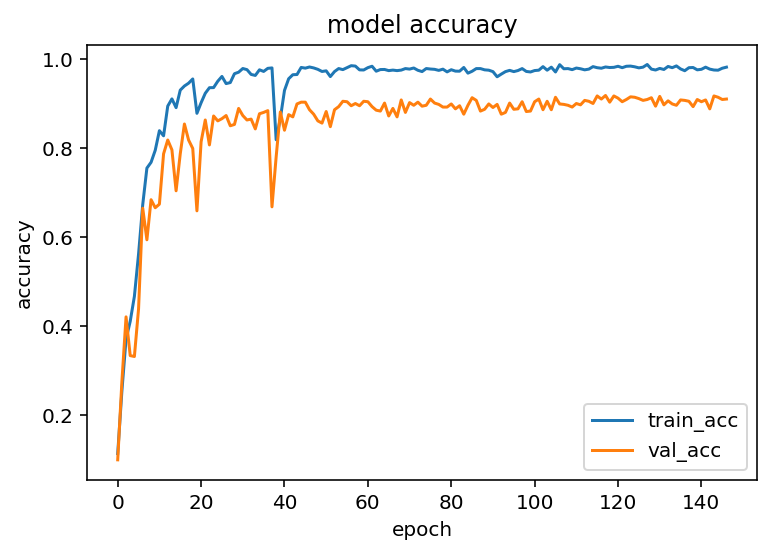

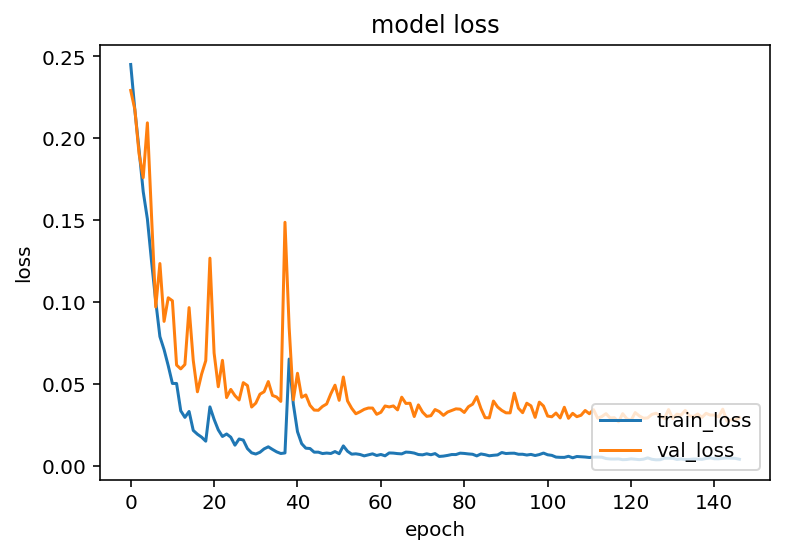

100%|██████████| 20/20 [00:02<00:00,  9.41it/s]
[2017-12-03 04:15:55,127 INFO] TestAcc: 0.9140 | TestLoss: 0.0280 
100%|██████████| 114/114 [00:11<00:00,  9.61it/s]
[2017-12-03 04:16:07,035 INFO] UnlabeledAcc: 0.9096 | UnlabeledLoss: 0.0297 
[2017-12-03 04:16:07,063 INFO] 0.0
[2017-12-03 04:16:07,727 INFO] Epoch: 0 | TrainAcc: 0.1320 | TrainLoss: 0.2409
[2017-12-03 04:16:08,071 INFO] Epoch: 0 | ValAcc: 0.1020 | ValLoss: 0.2274 

[2017-12-03 04:16:08,096 INFO] 0.0
[2017-12-03 04:16:08,724 INFO] Epoch: 1 | TrainAcc: 0.2440 | TrainLoss: 0.2112
[2017-12-03 04:16:09,059 INFO] Epoch: 1 | ValAcc: 0.1490 | ValLoss: 0.2199 

[2017-12-03 04:16:09,084 INFO] 0.0
[2017-12-03 04:16:09,739 INFO] Epoch: 2 | TrainAcc: 0.4260 | TrainLoss: 0.1831
[2017-12-03 04:16:10,081 INFO] Epoch: 2 | ValAcc: 0.4000 | ValLoss: 0.1809 

[2017-12-03 04:16:10,105 INFO] 0.0
[2017-12-03 04:16:10,758 INFO] Epoch: 3 | TrainAcc: 0.6130 | TrainLoss: 0.1415
[2017-12-03 04:16:11,104 INFO] Epoch: 3 | ValAcc: 0.4370 | ValLoss: 0.1

[2017-12-03 04:16:54,780 INFO] Epoch: 41 | TrainAcc: 0.9265 | TrainLoss: 0.0212
[2017-12-03 04:16:55,106 INFO] Epoch: 41 | ValAcc: 0.8610 | ValLoss: 0.0438 

[2017-12-03 04:16:55,133 INFO] 0.64
[2017-12-03 04:16:56,167 INFO] Epoch: 42 | TrainAcc: 0.9341 | TrainLoss: 0.0205
[2017-12-03 04:16:56,505 INFO] Epoch: 42 | ValAcc: 0.8260 | ValLoss: 0.0592 

[2017-12-03 04:16:56,527 INFO] 0.66
[2017-12-03 04:16:57,596 INFO] Epoch: 43 | TrainAcc: 0.9373 | TrainLoss: 0.0187
[2017-12-03 04:16:57,944 INFO] Epoch: 43 | ValAcc: 0.8800 | ValLoss: 0.0427 

[2017-12-03 04:16:57,963 INFO] 0.68
[2017-12-03 04:16:59,012 INFO] Epoch: 44 | TrainAcc: 0.9583 | TrainLoss: 0.0134
[2017-12-03 04:16:59,349 INFO] Epoch: 44 | ValAcc: 0.8760 | ValLoss: 0.0401 

[2017-12-03 04:16:59,371 INFO] 0.7000000000000001
[2017-12-03 04:17:00,407 INFO] Epoch: 45 | TrainAcc: 0.9641 | TrainLoss: 0.0113
[2017-12-03 04:17:00,727 INFO] Epoch: 45 | ValAcc: 0.8660 | ValLoss: 0.0438 

[2017-12-03 04:17:00,750 INFO] 0.72
[2017-12-03 04:1

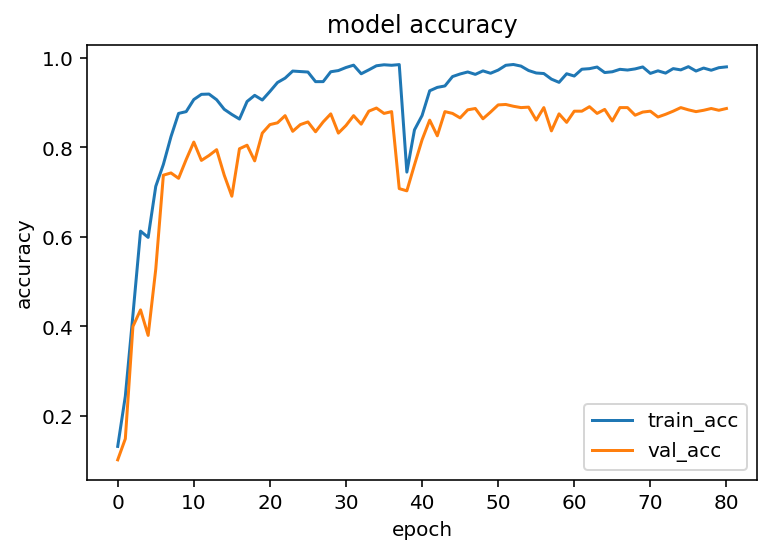

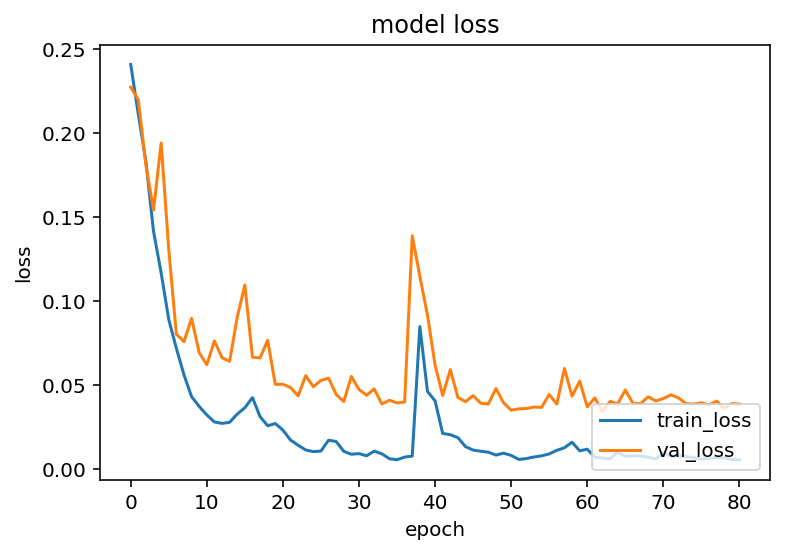

100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
[2017-12-03 04:18:00,849 INFO] TestAcc: 0.9150 | TestLoss: 0.0284 
100%|██████████| 114/114 [00:12<00:00,  8.95it/s]
[2017-12-03 04:18:13,646 INFO] UnlabeledAcc: 0.9096 | UnlabeledLoss: 0.0299 
[2017-12-03 04:18:13,678 INFO] 0.0
[2017-12-03 04:18:14,312 INFO] Epoch: 0 | TrainAcc: 0.1110 | TrainLoss: 0.2424
[2017-12-03 04:18:14,671 INFO] Epoch: 0 | ValAcc: 0.1120 | ValLoss: 0.2284 

[2017-12-03 04:18:14,695 INFO] 0.0
[2017-12-03 04:18:15,363 INFO] Epoch: 1 | TrainAcc: 0.2030 | TrainLoss: 0.2243
[2017-12-03 04:18:15,721 INFO] Epoch: 1 | ValAcc: 0.2100 | ValLoss: 0.2210 

[2017-12-03 04:18:15,745 INFO] 0.0
[2017-12-03 04:18:16,405 INFO] Epoch: 2 | TrainAcc: 0.2820 | TrainLoss: 0.2059
[2017-12-03 04:18:16,767 INFO] Epoch: 2 | ValAcc: 0.3100 | ValLoss: 0.2066 

[2017-12-03 04:18:16,791 INFO] 0.0
[2017-12-03 04:18:17,465 INFO] Epoch: 3 | TrainAcc: 0.4280 | TrainLoss: 0.1812
[2017-12-03 04:18:17,821 INFO] Epoch: 3 | ValAcc: 0.3260 | ValLoss: 0.1

[2017-12-03 04:19:02,922 INFO] Epoch: 41 | TrainAcc: 0.9698 | TrainLoss: 0.0093
[2017-12-03 04:19:03,273 INFO] Epoch: 41 | ValAcc: 0.8720 | ValLoss: 0.0508 

[2017-12-03 04:19:03,299 INFO] 0.64
[2017-12-03 04:19:04,331 INFO] Epoch: 42 | TrainAcc: 0.9774 | TrainLoss: 0.0078
[2017-12-03 04:19:04,714 INFO] Epoch: 42 | ValAcc: 0.8550 | ValLoss: 0.0489 

[2017-12-03 04:19:04,737 INFO] 0.66
[2017-12-03 04:19:05,778 INFO] Epoch: 43 | TrainAcc: 0.9813 | TrainLoss: 0.0075
[2017-12-03 04:19:06,146 INFO] Epoch: 43 | ValAcc: 0.8660 | ValLoss: 0.0481 

[2017-12-03 04:19:06,167 INFO] 0.68
[2017-12-03 04:19:07,229 INFO] Epoch: 44 | TrainAcc: 0.9845 | TrainLoss: 0.0080
[2017-12-03 04:19:07,583 INFO] Epoch: 44 | ValAcc: 0.8820 | ValLoss: 0.0473 

[2017-12-03 04:19:07,609 INFO] 0.7000000000000001
[2017-12-03 04:19:08,673 INFO] Epoch: 45 | TrainAcc: 0.9600 | TrainLoss: 0.0107
[2017-12-03 04:19:09,005 INFO] Epoch: 45 | ValAcc: 0.8690 | ValLoss: 0.0461 

[2017-12-03 04:19:09,028 INFO] 0.72
[2017-12-03 04:1

[2017-12-03 04:20:16,557 INFO] Epoch: 83 | TrainAcc: 0.9772 | TrainLoss: 0.0053
[2017-12-03 04:20:16,885 INFO] Epoch: 83 | ValAcc: 0.8910 | ValLoss: 0.0340 

[2017-12-03 04:20:16,908 INFO] 1.48
[2017-12-03 04:20:18,457 INFO] Epoch: 84 | TrainAcc: 0.9746 | TrainLoss: 0.0055
[2017-12-03 04:20:18,793 INFO] Epoch: 84 | ValAcc: 0.8890 | ValLoss: 0.0344 

[2017-12-03 04:20:18,816 INFO] 1.5
[2017-12-03 04:20:20,342 INFO] Epoch: 85 | TrainAcc: 0.9796 | TrainLoss: 0.0054
[2017-12-03 04:20:20,681 INFO] Epoch: 85 | ValAcc: 0.8790 | ValLoss: 0.0408 

[2017-12-03 04:20:20,708 INFO] 1.5
[2017-12-03 04:20:22,233 INFO] Epoch: 86 | TrainAcc: 0.9764 | TrainLoss: 0.0057
[2017-12-03 04:20:22,586 INFO] Epoch: 86 | ValAcc: 0.8640 | ValLoss: 0.0414 

[2017-12-03 04:20:22,612 INFO] 1.5
[2017-12-03 04:20:24,131 INFO] Epoch: 87 | TrainAcc: 0.9788 | TrainLoss: 0.0061
[2017-12-03 04:20:24,476 INFO] Epoch: 87 | ValAcc: 0.8950 | ValLoss: 0.0334 

[2017-12-03 04:20:24,498 INFO] 1.5
[2017-12-03 04:20:26,012 INFO] Epo

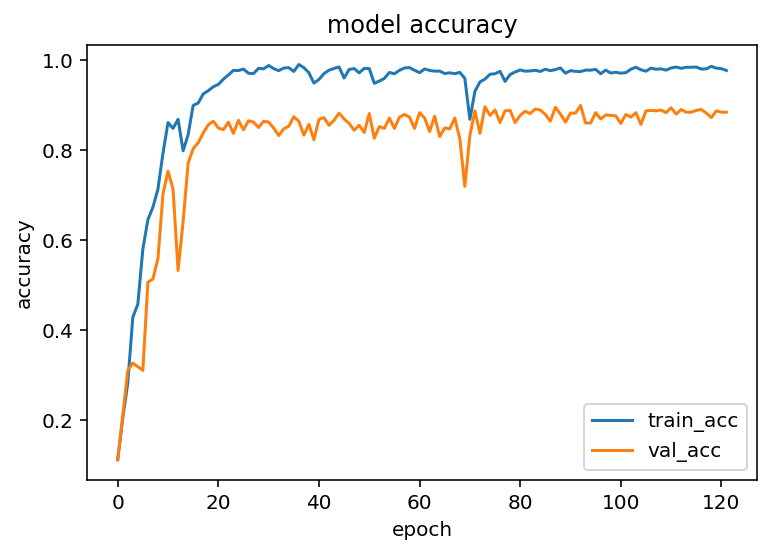

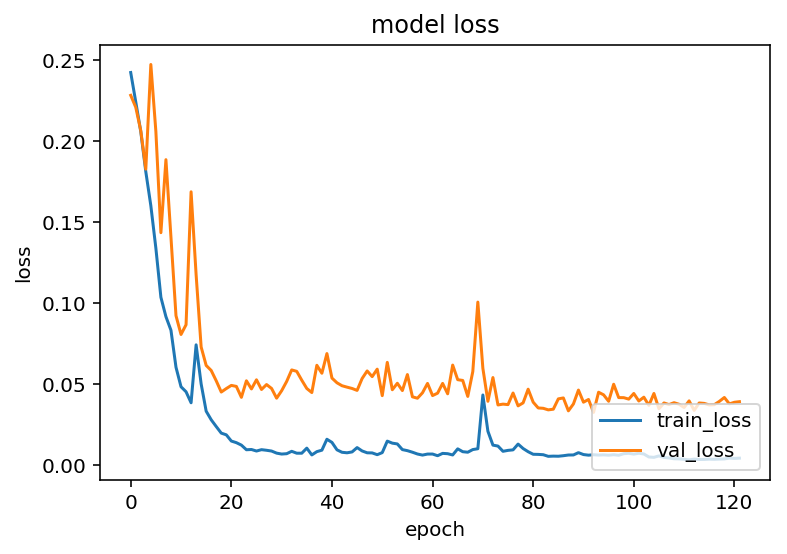

100%|██████████| 20/20 [00:02<00:00,  8.88it/s]
[2017-12-03 04:21:38,735 INFO] TestAcc: 0.9128 | TestLoss: 0.0284 
100%|██████████| 114/114 [00:12<00:00,  9.39it/s]
[2017-12-03 04:21:50,930 INFO] UnlabeledAcc: 0.9059 | UnlabeledLoss: 0.0305 
[2017-12-03 04:21:50,964 INFO] 0.0
[2017-12-03 04:21:51,734 INFO] Epoch: 0 | TrainAcc: 0.1300 | TrainLoss: 0.2408
[2017-12-03 04:21:52,126 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2290 

[2017-12-03 04:21:52,152 INFO] 0.0
[2017-12-03 04:21:52,857 INFO] Epoch: 1 | TrainAcc: 0.1640 | TrainLoss: 0.2238
[2017-12-03 04:21:53,205 INFO] Epoch: 1 | ValAcc: 0.1920 | ValLoss: 0.2211 

[2017-12-03 04:21:53,231 INFO] 0.0
[2017-12-03 04:21:53,914 INFO] Epoch: 2 | TrainAcc: 0.3800 | TrainLoss: 0.2030
[2017-12-03 04:21:54,266 INFO] Epoch: 2 | ValAcc: 0.2250 | ValLoss: 0.2026 

[2017-12-03 04:21:54,298 INFO] 0.0
[2017-12-03 04:21:54,979 INFO] Epoch: 3 | TrainAcc: 0.4850 | TrainLoss: 0.1713
[2017-12-03 04:21:55,323 INFO] Epoch: 3 | ValAcc: 0.4510 | ValLoss: 0.1

[2017-12-03 04:22:40,630 INFO] Epoch: 41 | TrainAcc: 0.9735 | TrainLoss: 0.0091
[2017-12-03 04:22:40,973 INFO] Epoch: 41 | ValAcc: 0.8800 | ValLoss: 0.0425 

[2017-12-03 04:22:41,000 INFO] 0.64
[2017-12-03 04:22:42,015 INFO] Epoch: 42 | TrainAcc: 0.9774 | TrainLoss: 0.0084
[2017-12-03 04:22:42,355 INFO] Epoch: 42 | ValAcc: 0.8710 | ValLoss: 0.0475 

[2017-12-03 04:22:42,378 INFO] 0.66
[2017-12-03 04:22:43,396 INFO] Epoch: 43 | TrainAcc: 0.9843 | TrainLoss: 0.0064
[2017-12-03 04:22:43,750 INFO] Epoch: 43 | ValAcc: 0.8840 | ValLoss: 0.0461 

[2017-12-03 04:22:43,773 INFO] 0.68
[2017-12-03 04:22:44,811 INFO] Epoch: 44 | TrainAcc: 0.9821 | TrainLoss: 0.0073
[2017-12-03 04:22:45,188 INFO] Epoch: 44 | ValAcc: 0.8450 | ValLoss: 0.0527 

[2017-12-03 04:22:45,217 INFO] 0.7000000000000001
[2017-12-03 04:22:46,297 INFO] Epoch: 45 | TrainAcc: 0.9747 | TrainLoss: 0.0090
[2017-12-03 04:22:46,696 INFO] Epoch: 45 | ValAcc: 0.8590 | ValLoss: 0.0474 

[2017-12-03 04:22:46,721 INFO] 0.72
[2017-12-03 04:2

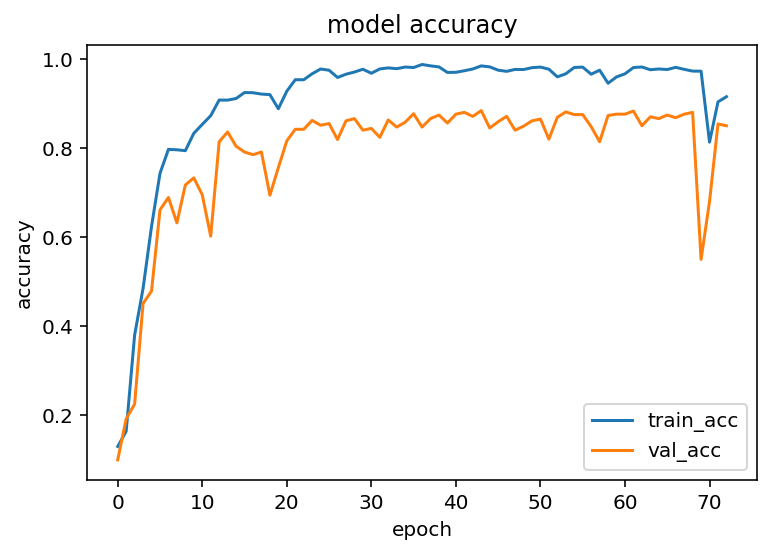

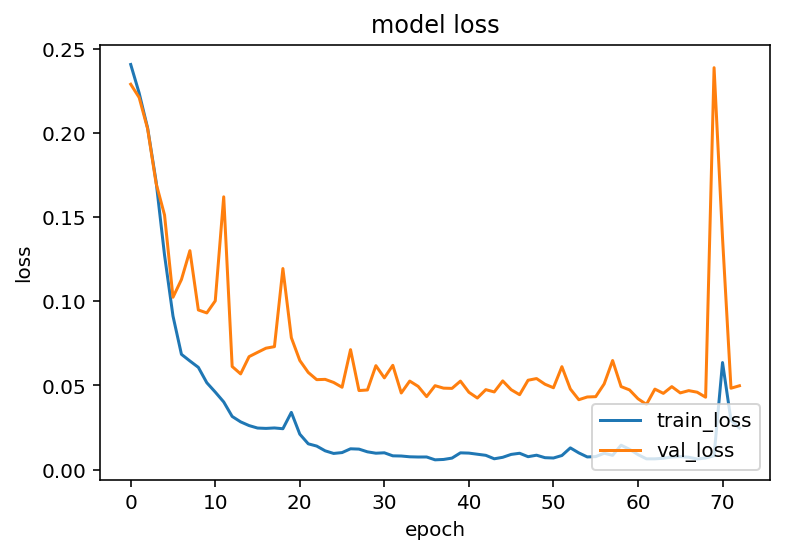

100%|██████████| 20/20 [00:02<00:00,  8.33it/s]
[2017-12-03 04:23:35,607 INFO] TestAcc: 0.8943 | TestLoss: 0.0375 
100%|██████████| 114/114 [00:12<00:00,  9.17it/s]
[2017-12-03 04:23:48,088 INFO] UnlabeledAcc: 0.8835 | UnlabeledLoss: 0.0405 
[2017-12-03 04:23:48,118 INFO] 0.0
[2017-12-03 04:23:48,808 INFO] Epoch: 0 | TrainAcc: 0.1490 | TrainLoss: 0.2285
[2017-12-03 04:23:49,175 INFO] Epoch: 0 | ValAcc: 0.1930 | ValLoss: 0.2261 

[2017-12-03 04:23:49,200 INFO] 0.0
[2017-12-03 04:23:49,892 INFO] Epoch: 1 | TrainAcc: 0.3250 | TrainLoss: 0.2073
[2017-12-03 04:23:50,260 INFO] Epoch: 1 | ValAcc: 0.3800 | ValLoss: 0.2097 

[2017-12-03 04:23:50,290 INFO] 0.0
[2017-12-03 04:23:50,988 INFO] Epoch: 2 | TrainAcc: 0.5250 | TrainLoss: 0.1698
[2017-12-03 04:23:51,337 INFO] Epoch: 2 | ValAcc: 0.3680 | ValLoss: 0.1764 

[2017-12-03 04:23:51,360 INFO] 0.0
[2017-12-03 04:23:52,047 INFO] Epoch: 3 | TrainAcc: 0.5990 | TrainLoss: 0.1284
[2017-12-03 04:23:52,408 INFO] Epoch: 3 | ValAcc: 0.5520 | ValLoss: 0.1

[2017-12-03 04:24:41,681 INFO] Epoch: 41 | TrainAcc: 0.9722 | TrainLoss: 0.0098
[2017-12-03 04:24:42,057 INFO] Epoch: 41 | ValAcc: 0.8730 | ValLoss: 0.0444 

[2017-12-03 04:24:42,079 INFO] 0.64
[2017-12-03 04:24:43,093 INFO] Epoch: 42 | TrainAcc: 0.9726 | TrainLoss: 0.0083
[2017-12-03 04:24:43,533 INFO] Epoch: 42 | ValAcc: 0.8730 | ValLoss: 0.0456 

[2017-12-03 04:24:43,562 INFO] 0.66
[2017-12-03 04:24:44,727 INFO] Epoch: 43 | TrainAcc: 0.9735 | TrainLoss: 0.0087
[2017-12-03 04:24:45,201 INFO] Epoch: 43 | ValAcc: 0.8850 | ValLoss: 0.0388 

[2017-12-03 04:24:45,225 INFO] 0.68
[2017-12-03 04:24:46,407 INFO] Epoch: 44 | TrainAcc: 0.9750 | TrainLoss: 0.0079
[2017-12-03 04:24:46,823 INFO] Epoch: 44 | ValAcc: 0.8650 | ValLoss: 0.0466 

[2017-12-03 04:24:46,847 INFO] 0.7000000000000001
[2017-12-03 04:24:47,955 INFO] Epoch: 45 | TrainAcc: 0.9729 | TrainLoss: 0.0080
[2017-12-03 04:24:48,294 INFO] Epoch: 45 | ValAcc: 0.8710 | ValLoss: 0.0431 

[2017-12-03 04:24:48,318 INFO] 0.72
[2017-12-03 04:2

[2017-12-03 04:25:57,475 INFO] Epoch: 83 | TrainAcc: 0.9841 | TrainLoss: 0.0051
[2017-12-03 04:25:57,881 INFO] Epoch: 83 | ValAcc: 0.8940 | ValLoss: 0.0378 

[2017-12-03 04:25:57,908 INFO] 1.48
[2017-12-03 04:25:59,618 INFO] Epoch: 84 | TrainAcc: 0.9790 | TrainLoss: 0.0053
[2017-12-03 04:25:59,940 INFO] Epoch: 84 | ValAcc: 0.8890 | ValLoss: 0.0398 

[2017-12-03 04:25:59,965 INFO] 1.5
[2017-12-03 04:26:01,422 INFO] Epoch: 85 | TrainAcc: 0.9804 | TrainLoss: 0.0057
[2017-12-03 04:26:01,757 INFO] Epoch: 85 | ValAcc: 0.9030 | ValLoss: 0.0359 

[2017-12-03 04:26:01,781 INFO] 1.5
[2017-12-03 04:26:03,255 INFO] Epoch: 86 | TrainAcc: 0.9800 | TrainLoss: 0.0052
[2017-12-03 04:26:03,613 INFO] Epoch: 86 | ValAcc: 0.9070 | ValLoss: 0.0343 

[2017-12-03 04:26:03,644 INFO] 1.5
[2017-12-03 04:26:05,121 INFO] Epoch: 87 | TrainAcc: 0.9828 | TrainLoss: 0.0048
[2017-12-03 04:26:05,470 INFO] Epoch: 87 | ValAcc: 0.9090 | ValLoss: 0.0321 

[2017-12-03 04:26:05,495 INFO] 1.5
[2017-12-03 04:26:06,933 INFO] Epo

[2017-12-03 04:27:26,423 INFO] Epoch: 125 | ValAcc: 0.8980 | ValLoss: 0.0357 

[2017-12-03 04:27:26,452 INFO] 1.5
[2017-12-03 04:27:28,083 INFO] Epoch: 126 | TrainAcc: 0.9856 | TrainLoss: 0.0043
[2017-12-03 04:27:28,455 INFO] Epoch: 126 | ValAcc: 0.8990 | ValLoss: 0.0355 

[2017-12-03 04:27:28,482 INFO] 1.5
[2017-12-03 04:27:30,249 INFO] Epoch: 127 | TrainAcc: 0.9836 | TrainLoss: 0.0045
[2017-12-03 04:27:30,663 INFO] Epoch: 127 | ValAcc: 0.8900 | ValLoss: 0.0406 

[2017-12-03 04:27:30,688 INFO] 1.5
[2017-12-03 04:27:32,526 INFO] Epoch: 128 | TrainAcc: 0.9752 | TrainLoss: 0.0046
[2017-12-03 04:27:32,958 INFO] Epoch: 128 | ValAcc: 0.9090 | ValLoss: 0.0312 

[2017-12-03 04:27:32,989 INFO] 1.5
[2017-12-03 04:27:34,879 INFO] Epoch: 129 | TrainAcc: 0.9760 | TrainLoss: 0.0045
[2017-12-03 04:27:35,291 INFO] Epoch: 129 | ValAcc: 0.8790 | ValLoss: 0.0397 

[2017-12-03 04:27:35,318 INFO] 1.5
[2017-12-03 04:27:37,081 INFO] Epoch: 130 | TrainAcc: 0.9740 | TrainLoss: 0.0054
[2017-12-03 04:27:37,507 

[2017-12-03 04:28:48,879 INFO] 1.5
[2017-12-03 04:28:50,376 INFO] Epoch: 168 | TrainAcc: 0.9840 | TrainLoss: 0.0040
[2017-12-03 04:28:50,707 INFO] Epoch: 168 | ValAcc: 0.8910 | ValLoss: 0.0387 

[2017-12-03 04:28:50,730 INFO] 1.5
[2017-12-03 04:28:52,222 INFO] Epoch: 169 | TrainAcc: 0.9856 | TrainLoss: 0.0042
[2017-12-03 04:28:52,570 INFO] Epoch: 169 | ValAcc: 0.8910 | ValLoss: 0.0393 

[2017-12-03 04:28:52,595 INFO] 1.5
[2017-12-03 04:28:54,059 INFO] Epoch: 170 | TrainAcc: 0.9808 | TrainLoss: 0.0038
[2017-12-03 04:28:54,397 INFO] Epoch: 170 | ValAcc: 0.8880 | ValLoss: 0.0406 

[2017-12-03 04:28:54,421 INFO] 1.5
[2017-12-03 04:28:55,888 INFO] Epoch: 171 | TrainAcc: 0.9796 | TrainLoss: 0.0042
[2017-12-03 04:28:56,227 INFO] Epoch: 171 | ValAcc: 0.8960 | ValLoss: 0.0372 

[2017-12-03 04:28:56,250 INFO] 1.5
[2017-12-03 04:28:57,792 INFO] Epoch: 172 | TrainAcc: 0.9856 | TrainLoss: 0.0036
[2017-12-03 04:28:58,134 INFO] Epoch: 172 | ValAcc: 0.9010 | ValLoss: 0.0374 

[2017-12-03 04:28:58,157 

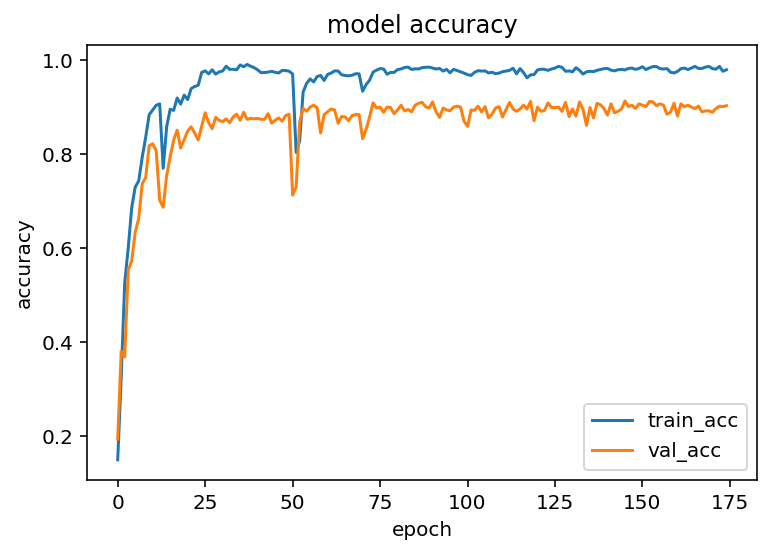

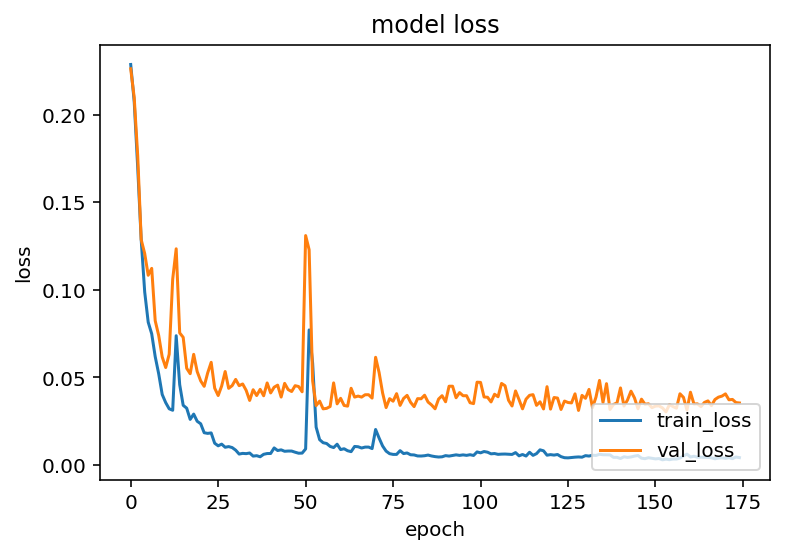

100%|██████████| 20/20 [00:02<00:00,  9.86it/s]
[2017-12-03 04:29:04,248 INFO] TestAcc: 0.9085 | TestLoss: 0.0299 
100%|██████████| 114/114 [00:11<00:00,  9.97it/s]
[2017-12-03 04:29:15,727 INFO] UnlabeledAcc: 0.9000 | UnlabeledLoss: 0.0334 


In [17]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
hard = False
ex_name = 'pseudo_ann'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_dataset = MNISTDataset(X_val, y_val, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch_size, num_workers=num_workers)
test_dataset = MNISTDataset(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, num_workers=num_workers)
unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
unlabeled_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)


results_ann = {}
results_ann['test_acc'] = np.empty((trial_times))
results_ann['test_loss'] = np.empty((trial_times))
results_ann['unlabeled_acc'] = np.empty((trial_times))
results_ann['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch
        
        #optimizer.param_groups[0]['lr'] = 0.5 * (0.1 ** (epoch // 30))
        ratio_pl = min(0.02 * max(epoch - 10, 0), 1.5) 
        logger.info(ratio_pl)
        train_dataset = MNISTDatasetForPseudoLabeling(
            X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_ann['test_acc'][i], results_ann['test_loss'][i] = _test(model, test_loader, criterion)
    results_ann['unlabeled_acc'][i], results_ann['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [18]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann['test_acc']),
    np.std(results_ann['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_ann['test_loss']),
    np.std(results_ann['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann['unlabeled_acc']),
    np.std(results_ann['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann['unlabeled_loss']),
    np.std(results_ann['unlabeled_loss'])
))

t, p = stats.ttest_rel(results_soft['test_acc'], results_ann['test_acc'])
print( "ann or const on soft：p値 = %(p)s" %locals() )

[2017-12-03 04:29:15,821 INFO] Test Accuracy: 0.9079 ± 0.0092
[2017-12-03 04:29:15,823 INFO] Test Loss: 0.0309 ± 0.0038

[2017-12-03 04:29:15,825 INFO] Unlabeled Accuracy: 0.9004 ± 0.0096
[2017-12-03 04:29:15,827 INFO] Unlabeled Loss: 0.0334 ± 0.0040


ann or const on soft：p値 = 0.344715310714


** reverse ann **

[2017-12-03 15:48:22,723 INFO] 1.0
[2017-12-03 15:48:24,091 INFO] Epoch: 0 | TrainAcc: 0.1475 | TrainLoss: 0.2308
[2017-12-03 15:48:24,523 INFO] Epoch: 0 | ValAcc: 0.1820 | ValLoss: 0.2260 

[2017-12-03 15:48:24,550 INFO] 0.98
[2017-12-03 15:48:25,884 INFO] Epoch: 1 | TrainAcc: 0.2717 | TrainLoss: 0.1959
[2017-12-03 15:48:26,240 INFO] Epoch: 1 | ValAcc: 0.3560 | ValLoss: 0.1943 

[2017-12-03 15:48:26,263 INFO] 0.96
[2017-12-03 15:48:27,545 INFO] Epoch: 2 | TrainAcc: 0.4592 | TrainLoss: 0.1541
[2017-12-03 15:48:27,897 INFO] Epoch: 2 | ValAcc: 0.4720 | ValLoss: 0.1452 

[2017-12-03 15:48:27,923 INFO] 0.9400000000000001
[2017-12-03 15:48:29,164 INFO] Epoch: 3 | TrainAcc: 0.5675 | TrainLoss: 0.1180
[2017-12-03 15:48:29,519 INFO] Epoch: 3 | ValAcc: 0.4670 | ValLoss: 0.1422 

[2017-12-03 15:48:29,543 INFO] 0.92
[2017-12-03 15:48:30,770 INFO] Epoch: 4 | TrainAcc: 0.7094 | TrainLoss: 0.0838
[2017-12-03 15:48:31,136 INFO] Epoch: 4 | ValAcc: 0.6700 | ValLoss: 0.1111 

[2017-12-03 15:48:31,160 IN

[2017-12-03 15:49:26,940 INFO] Epoch: 42 | TrainAcc: 0.9940 | TrainLoss: 0.0027
[2017-12-03 15:49:27,408 INFO] Epoch: 42 | ValAcc: 0.8870 | ValLoss: 0.0414 

[2017-12-03 15:49:27,440 INFO] 0.14
[2017-12-03 15:49:28,355 INFO] Epoch: 43 | TrainAcc: 0.9895 | TrainLoss: 0.0034
[2017-12-03 15:49:28,751 INFO] Epoch: 43 | ValAcc: 0.8900 | ValLoss: 0.0377 

[2017-12-03 15:49:28,778 INFO] 0.12
[2017-12-03 15:49:29,583 INFO] Epoch: 44 | TrainAcc: 0.9929 | TrainLoss: 0.0028
[2017-12-03 15:49:29,930 INFO] Epoch: 44 | ValAcc: 0.8820 | ValLoss: 0.0416 

[2017-12-03 15:49:29,958 INFO] 0.1
[2017-12-03 15:49:30,709 INFO] Epoch: 45 | TrainAcc: 0.9964 | TrainLoss: 0.0024
[2017-12-03 15:49:31,067 INFO] Epoch: 45 | ValAcc: 0.8820 | ValLoss: 0.0421 

[2017-12-03 15:49:31,091 INFO] 0.08
[2017-12-03 15:49:31,812 INFO] Epoch: 46 | TrainAcc: 0.9991 | TrainLoss: 0.0014
[2017-12-03 15:49:32,172 INFO] Epoch: 46 | ValAcc: 0.8900 | ValLoss: 0.0393 

[2017-12-03 15:49:32,196 INFO] 0.06
[2017-12-03 15:49:33,193 INFO] 

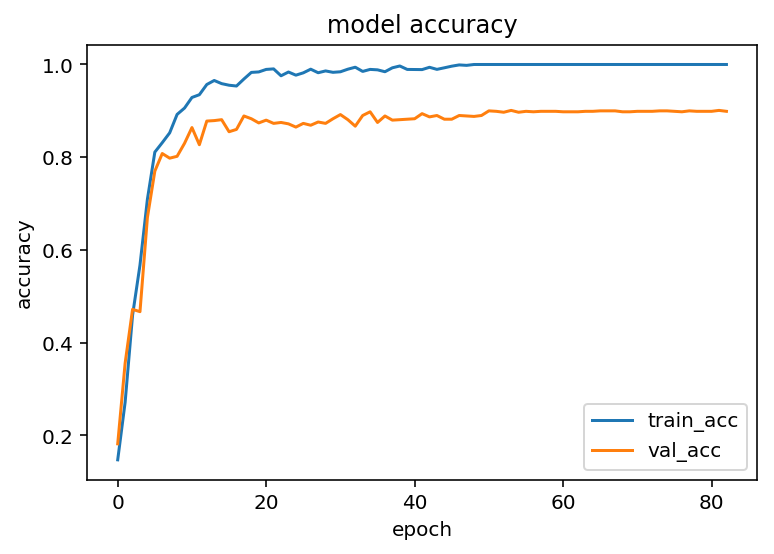

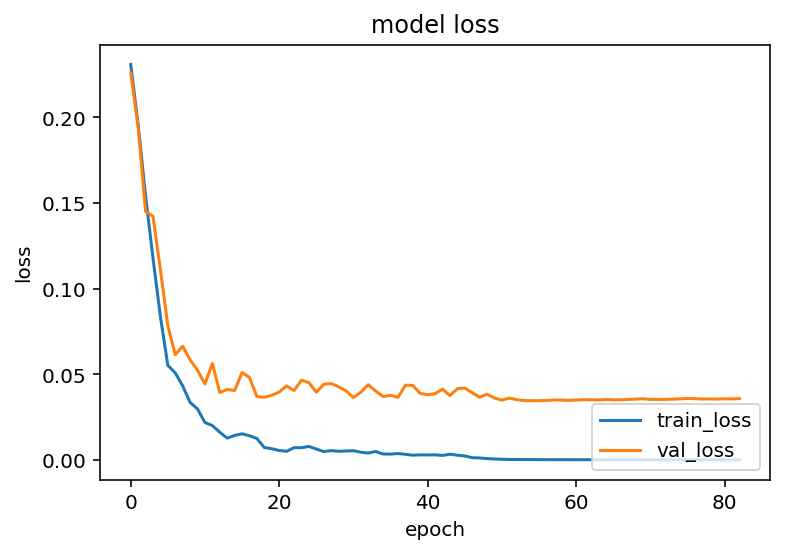

100%|██████████| 20/20 [00:02<00:00,  8.52it/s]
[2017-12-03 15:50:14,606 INFO] TestAcc: 0.9214 | TestLoss: 0.0271 
100%|██████████| 114/114 [00:12<00:00,  8.99it/s]
[2017-12-03 15:50:27,347 INFO] UnlabeledAcc: 0.9095 | UnlabeledLoss: 0.0316 
[2017-12-03 15:50:27,381 INFO] 1.0
[2017-12-03 15:50:28,612 INFO] Epoch: 0 | TrainAcc: 0.1330 | TrainLoss: 0.2286
[2017-12-03 15:50:28,969 INFO] Epoch: 0 | ValAcc: 0.2340 | ValLoss: 0.2262 

[2017-12-03 15:50:28,996 INFO] 0.98
[2017-12-03 15:50:30,240 INFO] Epoch: 1 | TrainAcc: 0.2530 | TrainLoss: 0.2019
[2017-12-03 15:50:30,580 INFO] Epoch: 1 | ValAcc: 0.3500 | ValLoss: 0.2012 

[2017-12-03 15:50:30,603 INFO] 0.96
[2017-12-03 15:50:31,832 INFO] Epoch: 2 | TrainAcc: 0.4796 | TrainLoss: 0.1554
[2017-12-03 15:50:32,183 INFO] Epoch: 2 | ValAcc: 0.5740 | ValLoss: 0.1380 

[2017-12-03 15:50:32,209 INFO] 0.9400000000000001
[2017-12-03 15:50:33,455 INFO] Epoch: 3 | TrainAcc: 0.6211 | TrainLoss: 0.1073
[2017-12-03 15:50:33,820 INFO] Epoch: 3 | ValAcc: 0.58

[2017-12-03 15:51:25,961 INFO] 0.18
[2017-12-03 15:51:26,773 INFO] Epoch: 41 | TrainAcc: 0.9924 | TrainLoss: 0.0046
[2017-12-03 15:51:27,117 INFO] Epoch: 41 | ValAcc: 0.8540 | ValLoss: 0.0560 

[2017-12-03 15:51:27,142 INFO] 0.16
[2017-12-03 15:51:27,930 INFO] Epoch: 42 | TrainAcc: 0.9905 | TrainLoss: 0.0040
[2017-12-03 15:51:28,299 INFO] Epoch: 42 | ValAcc: 0.8640 | ValLoss: 0.0487 

[2017-12-03 15:51:28,324 INFO] 0.14
[2017-12-03 15:51:29,107 INFO] Epoch: 43 | TrainAcc: 0.9886 | TrainLoss: 0.0049
[2017-12-03 15:51:29,466 INFO] Epoch: 43 | ValAcc: 0.8340 | ValLoss: 0.0610 

[2017-12-03 15:51:29,490 INFO] 0.12
[2017-12-03 15:51:30,255 INFO] Epoch: 44 | TrainAcc: 0.9920 | TrainLoss: 0.0034
[2017-12-03 15:51:30,623 INFO] Epoch: 44 | ValAcc: 0.8790 | ValLoss: 0.0442 

[2017-12-03 15:51:30,651 INFO] 0.1
[2017-12-03 15:51:31,496 INFO] Epoch: 45 | TrainAcc: 0.9945 | TrainLoss: 0.0020
[2017-12-03 15:51:31,908 INFO] Epoch: 45 | ValAcc: 0.8850 | ValLoss: 0.0466 

[2017-12-03 15:51:31,935 INFO] 

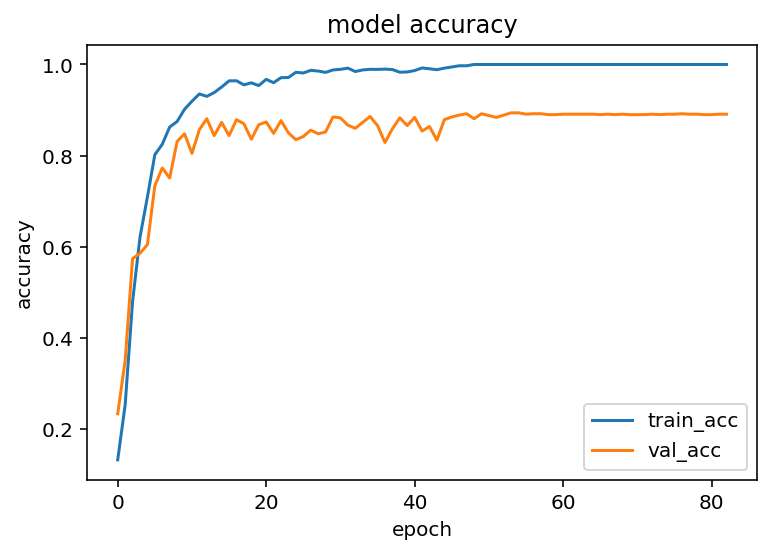

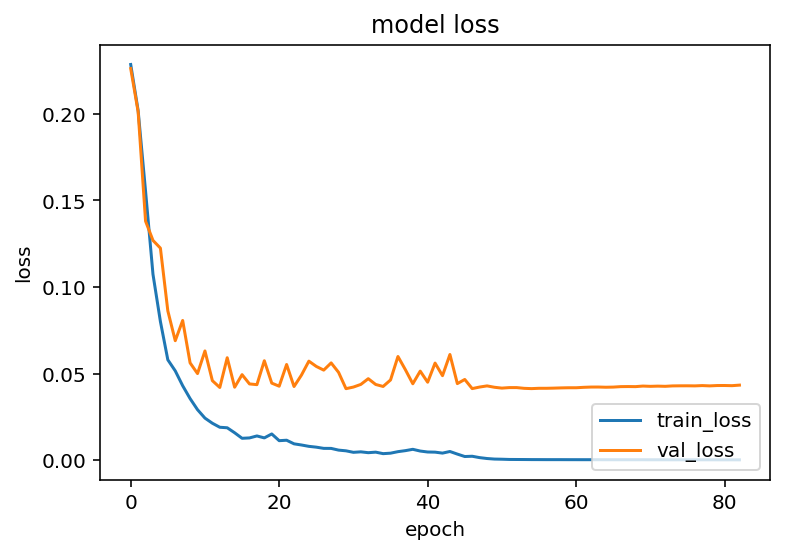

100%|██████████| 20/20 [00:02<00:00,  6.92it/s]
[2017-12-03 15:52:17,799 INFO] TestAcc: 0.9133 | TestLoss: 0.0316 
100%|██████████| 114/114 [00:12<00:00,  9.29it/s]
[2017-12-03 15:52:30,121 INFO] UnlabeledAcc: 0.9084 | UnlabeledLoss: 0.0334 
[2017-12-03 15:52:30,152 INFO] 1.0
[2017-12-03 15:52:31,520 INFO] Epoch: 0 | TrainAcc: 0.1525 | TrainLoss: 0.2266
[2017-12-03 15:52:31,888 INFO] Epoch: 0 | ValAcc: 0.2950 | ValLoss: 0.2226 

[2017-12-03 15:52:31,915 INFO] 0.98
[2017-12-03 15:52:33,175 INFO] Epoch: 1 | TrainAcc: 0.3081 | TrainLoss: 0.1983
[2017-12-03 15:52:33,520 INFO] Epoch: 1 | ValAcc: 0.3280 | ValLoss: 0.1920 

[2017-12-03 15:52:33,545 INFO] 0.96
[2017-12-03 15:52:34,799 INFO] Epoch: 2 | TrainAcc: 0.4867 | TrainLoss: 0.1500
[2017-12-03 15:52:35,153 INFO] Epoch: 2 | ValAcc: 0.4680 | ValLoss: 0.1527 

[2017-12-03 15:52:35,181 INFO] 0.9400000000000001
[2017-12-03 15:52:36,431 INFO] Epoch: 3 | TrainAcc: 0.6057 | TrainLoss: 0.1059
[2017-12-03 15:52:36,772 INFO] Epoch: 3 | ValAcc: 0.65

[2017-12-03 15:53:31,031 INFO] 0.18
[2017-12-03 15:53:31,861 INFO] Epoch: 41 | TrainAcc: 0.9915 | TrainLoss: 0.0033
[2017-12-03 15:53:32,306 INFO] Epoch: 41 | ValAcc: 0.9070 | ValLoss: 0.0353 

[2017-12-03 15:53:32,335 INFO] 0.16
[2017-12-03 15:53:33,341 INFO] Epoch: 42 | TrainAcc: 0.9957 | TrainLoss: 0.0033
[2017-12-03 15:53:33,842 INFO] Epoch: 42 | ValAcc: 0.8910 | ValLoss: 0.0401 

[2017-12-03 15:53:33,874 INFO] 0.14
[2017-12-03 15:53:34,811 INFO] Epoch: 43 | TrainAcc: 0.9877 | TrainLoss: 0.0048
[2017-12-03 15:53:35,210 INFO] Epoch: 43 | ValAcc: 0.9000 | ValLoss: 0.0369 

[2017-12-03 15:53:35,240 INFO] 0.12
[2017-12-03 15:53:36,090 INFO] Epoch: 44 | TrainAcc: 0.9920 | TrainLoss: 0.0028
[2017-12-03 15:53:36,466 INFO] Epoch: 44 | ValAcc: 0.8950 | ValLoss: 0.0380 

[2017-12-03 15:53:36,492 INFO] 0.1
[2017-12-03 15:53:37,246 INFO] Epoch: 45 | TrainAcc: 0.9955 | TrainLoss: 0.0022
[2017-12-03 15:53:37,640 INFO] Epoch: 45 | ValAcc: 0.8950 | ValLoss: 0.0375 

[2017-12-03 15:53:37,671 INFO] 

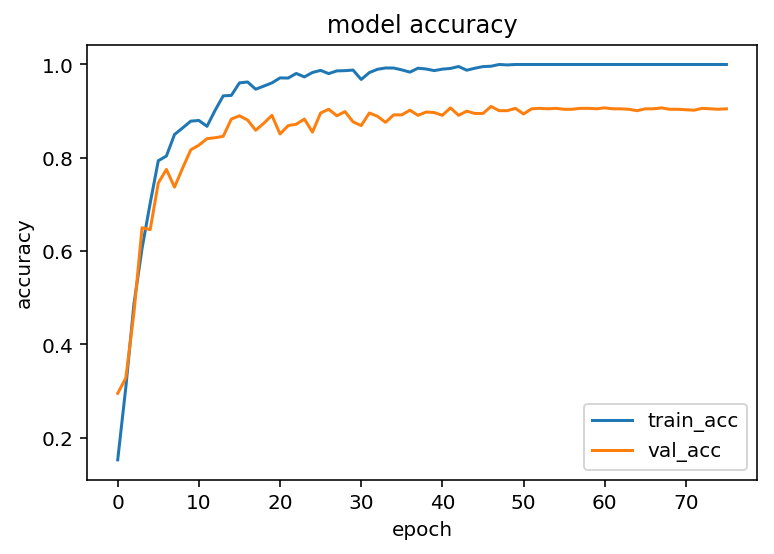

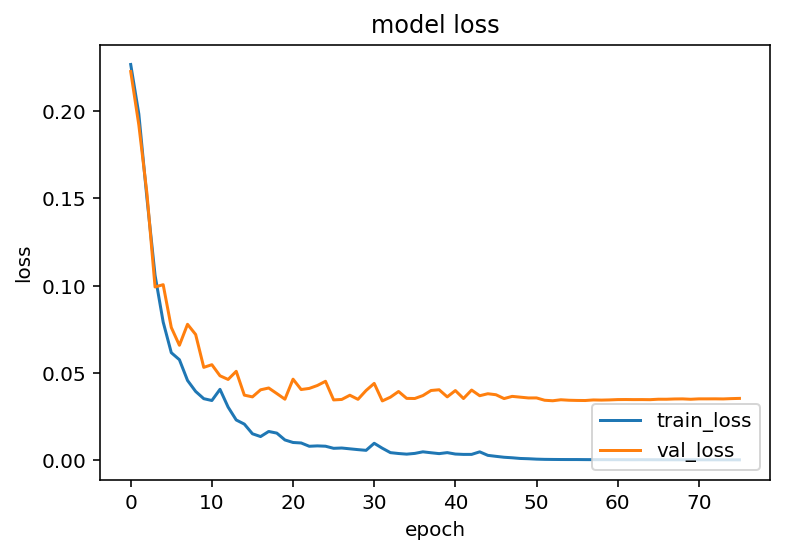

100%|██████████| 20/20 [00:02<00:00,  9.10it/s]
[2017-12-03 15:54:13,591 INFO] TestAcc: 0.9029 | TestLoss: 0.0335 
100%|██████████| 114/114 [00:12<00:00,  9.49it/s]
[2017-12-03 15:54:25,652 INFO] UnlabeledAcc: 0.9013 | UnlabeledLoss: 0.0358 
[2017-12-03 15:54:25,681 INFO] 1.0
[2017-12-03 15:54:26,927 INFO] Epoch: 0 | TrainAcc: 0.1560 | TrainLoss: 0.2360
[2017-12-03 15:54:27,285 INFO] Epoch: 0 | ValAcc: 0.1290 | ValLoss: 0.2239 

[2017-12-03 15:54:27,311 INFO] 0.98
[2017-12-03 15:54:28,562 INFO] Epoch: 1 | TrainAcc: 0.2939 | TrainLoss: 0.1968
[2017-12-03 15:54:28,906 INFO] Epoch: 1 | ValAcc: 0.2700 | ValLoss: 0.1970 

[2017-12-03 15:54:28,928 INFO] 0.96
[2017-12-03 15:54:30,159 INFO] Epoch: 2 | TrainAcc: 0.4015 | TrainLoss: 0.1667
[2017-12-03 15:54:30,503 INFO] Epoch: 2 | ValAcc: 0.3410 | ValLoss: 0.1871 

[2017-12-03 15:54:30,529 INFO] 0.9400000000000001
[2017-12-03 15:54:31,752 INFO] Epoch: 3 | TrainAcc: 0.5021 | TrainLoss: 0.1380
[2017-12-03 15:54:32,084 INFO] Epoch: 3 | ValAcc: 0.51

[2017-12-03 15:55:26,905 INFO] 0.18
[2017-12-03 15:55:27,800 INFO] Epoch: 41 | TrainAcc: 0.9958 | TrainLoss: 0.0025
[2017-12-03 15:55:28,134 INFO] Epoch: 41 | ValAcc: 0.8720 | ValLoss: 0.0459 

[2017-12-03 15:55:28,160 INFO] 0.16
[2017-12-03 15:55:28,933 INFO] Epoch: 42 | TrainAcc: 0.9879 | TrainLoss: 0.0034
[2017-12-03 15:55:29,308 INFO] Epoch: 42 | ValAcc: 0.8830 | ValLoss: 0.0426 

[2017-12-03 15:55:29,332 INFO] 0.14
[2017-12-03 15:55:30,093 INFO] Epoch: 43 | TrainAcc: 0.9939 | TrainLoss: 0.0027
[2017-12-03 15:55:30,449 INFO] Epoch: 43 | ValAcc: 0.8870 | ValLoss: 0.0414 

[2017-12-03 15:55:30,473 INFO] 0.12
[2017-12-03 15:55:31,254 INFO] Epoch: 44 | TrainAcc: 0.9991 | TrainLoss: 0.0024
[2017-12-03 15:55:31,637 INFO] Epoch: 44 | ValAcc: 0.8800 | ValLoss: 0.0431 

[2017-12-03 15:55:31,665 INFO] 0.1
[2017-12-03 15:55:32,434 INFO] Epoch: 45 | TrainAcc: 0.9964 | TrainLoss: 0.0023
[2017-12-03 15:55:32,901 INFO] Epoch: 45 | ValAcc: 0.8830 | ValLoss: 0.0410 

[2017-12-03 15:55:32,925 INFO] 

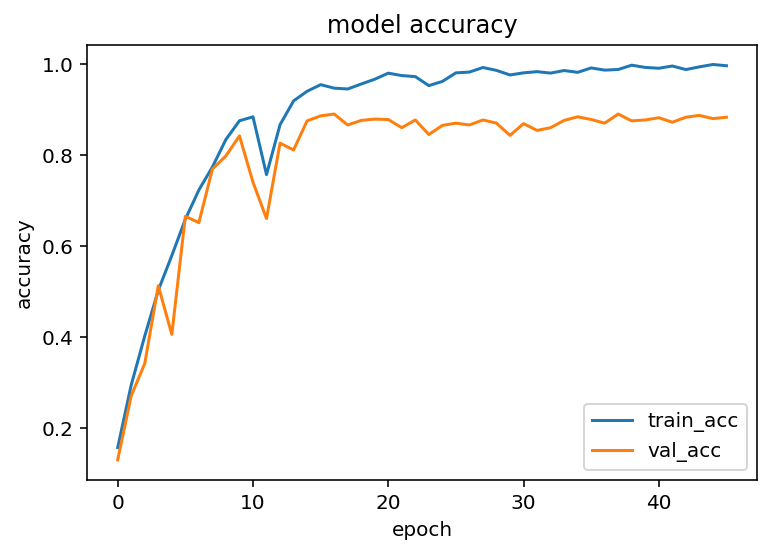

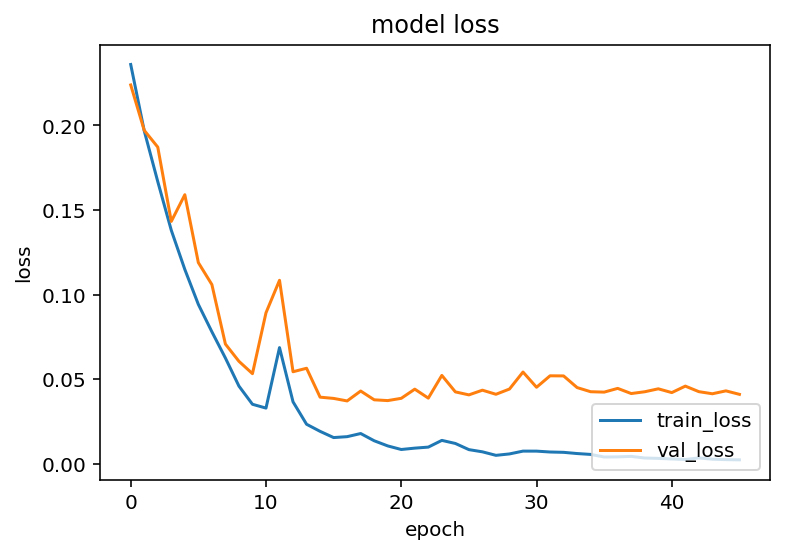

100%|██████████| 20/20 [00:02<00:00,  8.96it/s]
[2017-12-03 15:55:35,426 INFO] TestAcc: 0.8963 | TestLoss: 0.0341 
100%|██████████| 114/114 [00:12<00:00,  9.13it/s]
[2017-12-03 15:55:47,965 INFO] UnlabeledAcc: 0.8852 | UnlabeledLoss: 0.0371 
[2017-12-03 15:55:47,997 INFO] 1.0
[2017-12-03 15:55:49,224 INFO] Epoch: 0 | TrainAcc: 0.1340 | TrainLoss: 0.2268
[2017-12-03 15:55:49,595 INFO] Epoch: 0 | ValAcc: 0.3280 | ValLoss: 0.2185 

[2017-12-03 15:55:49,622 INFO] 0.98
[2017-12-03 15:55:50,826 INFO] Epoch: 1 | TrainAcc: 0.3323 | TrainLoss: 0.1861
[2017-12-03 15:55:51,167 INFO] Epoch: 1 | ValAcc: 0.3950 | ValLoss: 0.1780 

[2017-12-03 15:55:51,189 INFO] 0.96
[2017-12-03 15:55:52,409 INFO] Epoch: 2 | TrainAcc: 0.5342 | TrainLoss: 0.1272
[2017-12-03 15:55:52,752 INFO] Epoch: 2 | ValAcc: 0.5170 | ValLoss: 0.1495 

[2017-12-03 15:55:52,778 INFO] 0.9400000000000001
[2017-12-03 15:55:54,137 INFO] Epoch: 3 | TrainAcc: 0.6747 | TrainLoss: 0.0870
[2017-12-03 15:55:54,476 INFO] Epoch: 3 | ValAcc: 0.64

[2017-12-03 15:56:45,762 INFO] 0.18
[2017-12-03 15:56:46,545 INFO] Epoch: 41 | TrainAcc: 0.9898 | TrainLoss: 0.0031
[2017-12-03 15:56:46,885 INFO] Epoch: 41 | ValAcc: 0.8850 | ValLoss: 0.0372 

[2017-12-03 15:56:46,912 INFO] 0.16
[2017-12-03 15:56:47,691 INFO] Epoch: 42 | TrainAcc: 0.9940 | TrainLoss: 0.0025
[2017-12-03 15:56:48,061 INFO] Epoch: 42 | ValAcc: 0.8730 | ValLoss: 0.0429 

[2017-12-03 15:56:48,084 INFO] 0.14
[2017-12-03 15:56:48,876 INFO] Epoch: 43 | TrainAcc: 0.9939 | TrainLoss: 0.0018
[2017-12-03 15:56:49,240 INFO] Epoch: 43 | ValAcc: 0.8920 | ValLoss: 0.0359 

[2017-12-03 15:56:49,265 INFO] 0.12
[2017-12-03 15:56:49,996 INFO] Epoch: 44 | TrainAcc: 0.9982 | TrainLoss: 0.0016
[2017-12-03 15:56:50,343 INFO] Epoch: 44 | ValAcc: 0.8950 | ValLoss: 0.0370 

[2017-12-03 15:56:50,368 INFO] 0.1
[2017-12-03 15:56:51,079 INFO] Epoch: 45 | TrainAcc: 0.9955 | TrainLoss: 0.0015
[2017-12-03 15:56:51,445 INFO] Epoch: 45 | ValAcc: 0.8910 | ValLoss: 0.0388 

[2017-12-03 15:56:51,470 INFO] 

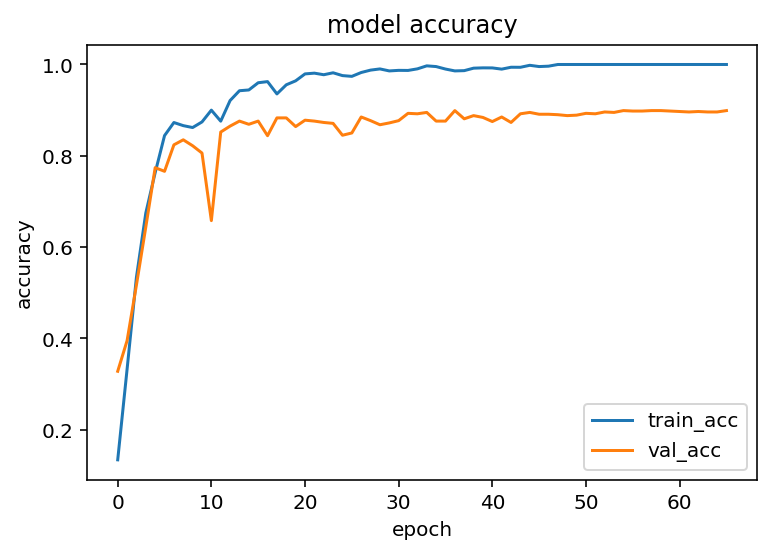

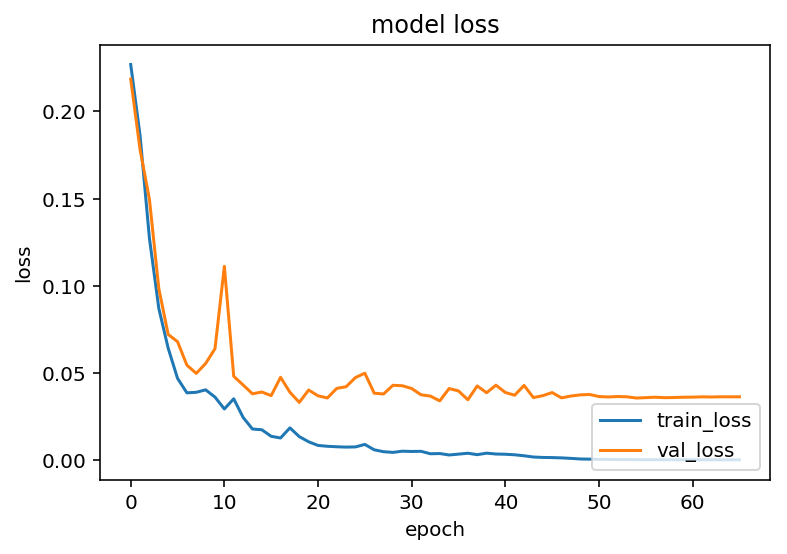

100%|██████████| 20/20 [00:02<00:00,  9.20it/s]
[2017-12-03 15:57:15,034 INFO] TestAcc: 0.9154 | TestLoss: 0.0284 
100%|██████████| 114/114 [00:11<00:00,  9.85it/s]
[2017-12-03 15:57:26,659 INFO] UnlabeledAcc: 0.9040 | UnlabeledLoss: 0.0327 
[2017-12-03 15:57:26,688 INFO] 1.0
[2017-12-03 15:57:27,931 INFO] Epoch: 0 | TrainAcc: 0.1695 | TrainLoss: 0.2212
[2017-12-03 15:57:28,287 INFO] Epoch: 0 | ValAcc: 0.1790 | ValLoss: 0.2194 

[2017-12-03 15:57:28,317 INFO] 0.98
[2017-12-03 15:57:29,541 INFO] Epoch: 1 | TrainAcc: 0.3742 | TrainLoss: 0.1758
[2017-12-03 15:57:29,879 INFO] Epoch: 1 | ValAcc: 0.4930 | ValLoss: 0.1677 

[2017-12-03 15:57:29,902 INFO] 0.96
[2017-12-03 15:57:31,091 INFO] Epoch: 2 | TrainAcc: 0.6224 | TrainLoss: 0.1137
[2017-12-03 15:57:31,428 INFO] Epoch: 2 | ValAcc: 0.5900 | ValLoss: 0.1145 

[2017-12-03 15:57:31,455 INFO] 0.9400000000000001
[2017-12-03 15:57:32,670 INFO] Epoch: 3 | TrainAcc: 0.7170 | TrainLoss: 0.0763
[2017-12-03 15:57:33,013 INFO] Epoch: 3 | ValAcc: 0.53

[2017-12-03 15:58:24,246 INFO] 0.18
[2017-12-03 15:58:25,081 INFO] Epoch: 41 | TrainAcc: 0.9941 | TrainLoss: 0.0021
[2017-12-03 15:58:25,429 INFO] Epoch: 41 | ValAcc: 0.9020 | ValLoss: 0.0351 

[2017-12-03 15:58:25,463 INFO] 0.16
[2017-12-03 15:58:26,274 INFO] Epoch: 42 | TrainAcc: 0.9914 | TrainLoss: 0.0018
[2017-12-03 15:58:26,636 INFO] Epoch: 42 | ValAcc: 0.8960 | ValLoss: 0.0333 

[2017-12-03 15:58:26,661 INFO] 0.14
[2017-12-03 15:58:27,448 INFO] Epoch: 43 | TrainAcc: 0.9956 | TrainLoss: 0.0019
[2017-12-03 15:58:27,801 INFO] Epoch: 43 | ValAcc: 0.9060 | ValLoss: 0.0335 

[2017-12-03 15:58:27,826 INFO] 0.12
[2017-12-03 15:58:28,584 INFO] Epoch: 44 | TrainAcc: 0.9964 | TrainLoss: 0.0014
[2017-12-03 15:58:28,961 INFO] Epoch: 44 | ValAcc: 0.9180 | ValLoss: 0.0323 

[2017-12-03 15:58:28,988 INFO] 0.1
[2017-12-03 15:58:29,717 INFO] Epoch: 45 | TrainAcc: 0.9955 | TrainLoss: 0.0013
[2017-12-03 15:58:30,066 INFO] Epoch: 45 | ValAcc: 0.9070 | ValLoss: 0.0318 

[2017-12-03 15:58:30,091 INFO] 

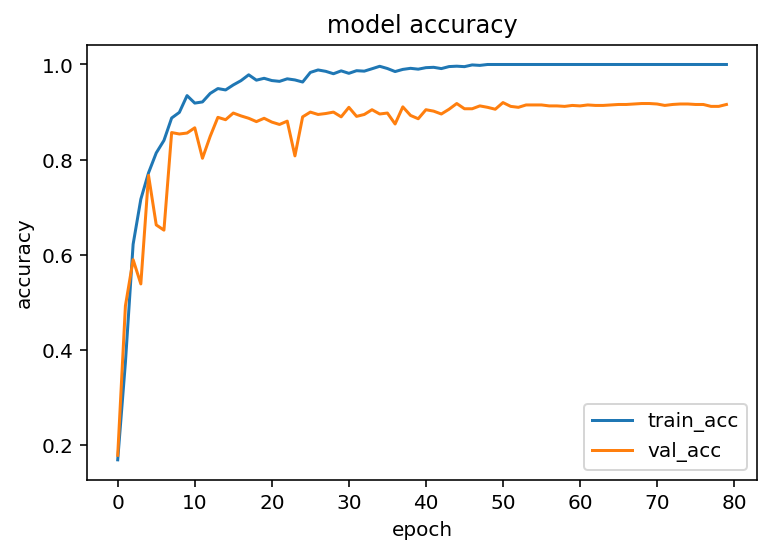

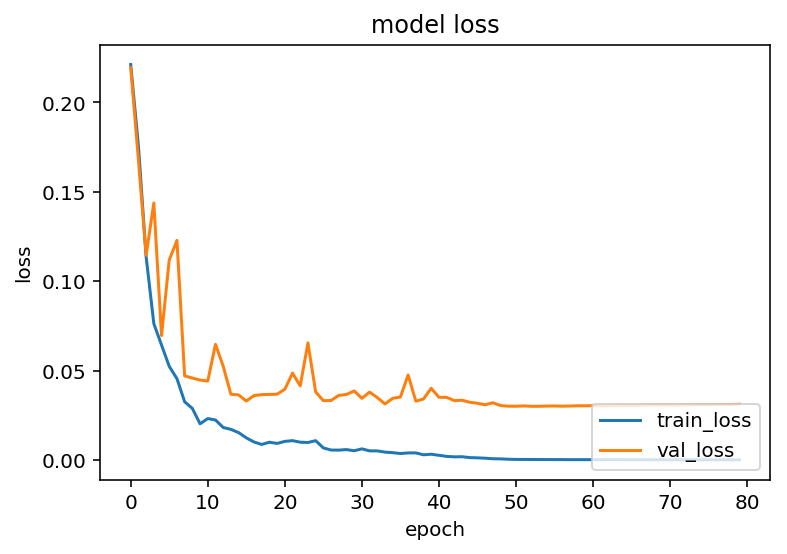

100%|██████████| 20/20 [00:02<00:00,  9.58it/s]
[2017-12-03 15:59:08,757 INFO] TestAcc: 0.9185 | TestLoss: 0.0292 
100%|██████████| 114/114 [00:11<00:00,  9.86it/s]
[2017-12-03 15:59:20,357 INFO] UnlabeledAcc: 0.9095 | UnlabeledLoss: 0.0323 
[2017-12-03 15:59:20,386 INFO] 1.0
[2017-12-03 15:59:21,586 INFO] Epoch: 0 | TrainAcc: 0.1205 | TrainLoss: 0.2298
[2017-12-03 15:59:21,945 INFO] Epoch: 0 | ValAcc: 0.1760 | ValLoss: 0.2288 

[2017-12-03 15:59:21,972 INFO] 0.98
[2017-12-03 15:59:23,216 INFO] Epoch: 1 | TrainAcc: 0.2778 | TrainLoss: 0.2005
[2017-12-03 15:59:23,556 INFO] Epoch: 1 | ValAcc: 0.2450 | ValLoss: 0.1947 

[2017-12-03 15:59:23,578 INFO] 0.96
[2017-12-03 15:59:24,827 INFO] Epoch: 2 | TrainAcc: 0.4372 | TrainLoss: 0.1527
[2017-12-03 15:59:25,164 INFO] Epoch: 2 | ValAcc: 0.3310 | ValLoss: 0.1791 

[2017-12-03 15:59:25,190 INFO] 0.9400000000000001
[2017-12-03 15:59:26,389 INFO] Epoch: 3 | TrainAcc: 0.6046 | TrainLoss: 0.1124
[2017-12-03 15:59:26,734 INFO] Epoch: 3 | ValAcc: 0.64

[2017-12-03 16:00:17,957 INFO] 0.18
[2017-12-03 16:00:18,748 INFO] Epoch: 41 | TrainAcc: 0.9932 | TrainLoss: 0.0032
[2017-12-03 16:00:19,080 INFO] Epoch: 41 | ValAcc: 0.8900 | ValLoss: 0.0376 

[2017-12-03 16:00:19,104 INFO] 0.16
[2017-12-03 16:00:19,879 INFO] Epoch: 42 | TrainAcc: 0.9914 | TrainLoss: 0.0030
[2017-12-03 16:00:20,239 INFO] Epoch: 42 | ValAcc: 0.8790 | ValLoss: 0.0464 

[2017-12-03 16:00:20,263 INFO] 0.14
[2017-12-03 16:00:21,059 INFO] Epoch: 43 | TrainAcc: 0.9825 | TrainLoss: 0.0059
[2017-12-03 16:00:21,419 INFO] Epoch: 43 | ValAcc: 0.8660 | ValLoss: 0.0491 

[2017-12-03 16:00:21,443 INFO] 0.12
[2017-12-03 16:00:22,196 INFO] Epoch: 44 | TrainAcc: 0.9884 | TrainLoss: 0.0044
[2017-12-03 16:00:22,562 INFO] Epoch: 44 | ValAcc: 0.8890 | ValLoss: 0.0412 

[2017-12-03 16:00:22,588 INFO] 0.1
[2017-12-03 16:00:23,324 INFO] Epoch: 45 | TrainAcc: 0.9936 | TrainLoss: 0.0033
[2017-12-03 16:00:23,715 INFO] Epoch: 45 | ValAcc: 0.8730 | ValLoss: 0.0411 

[2017-12-03 16:00:23,740 INFO] 

[2017-12-03 16:01:05,789 INFO] 0
[2017-12-03 16:01:06,486 INFO] Epoch: 84 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:01:06,842 INFO] Epoch: 84 | ValAcc: 0.9060 | ValLoss: 0.0361 

[2017-12-03 16:01:06,866 INFO] 0
[2017-12-03 16:01:07,522 INFO] Epoch: 85 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:01:07,891 INFO] Epoch: 85 | ValAcc: 0.9050 | ValLoss: 0.0365 

[2017-12-03 16:01:07,916 INFO] 0
[2017-12-03 16:01:08,585 INFO] Epoch: 86 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:01:08,933 INFO] Epoch: 86 | ValAcc: 0.9070 | ValLoss: 0.0363 

[2017-12-03 16:01:08,958 INFO] 0
[2017-12-03 16:01:09,631 INFO] Epoch: 87 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:01:09,983 INFO] Epoch: 87 | ValAcc: 0.9060 | ValLoss: 0.0364 

[2017-12-03 16:01:10,007 INFO] 0
[2017-12-03 16:01:10,688 INFO] Epoch: 88 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:01:11,039 INFO] Epoch: 88 | ValAcc: 0.9050 | ValLoss: 0.0364 

[2017-12-03 16:01:11,063 INFO] 0
[2017-12-03 

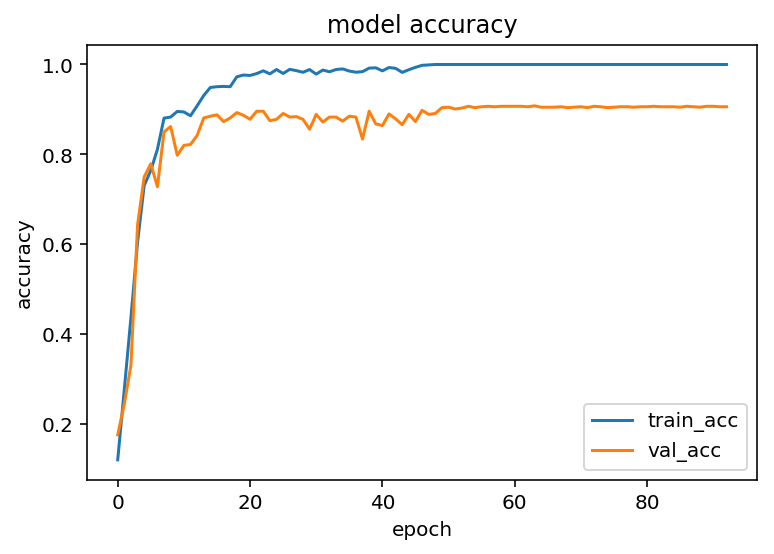

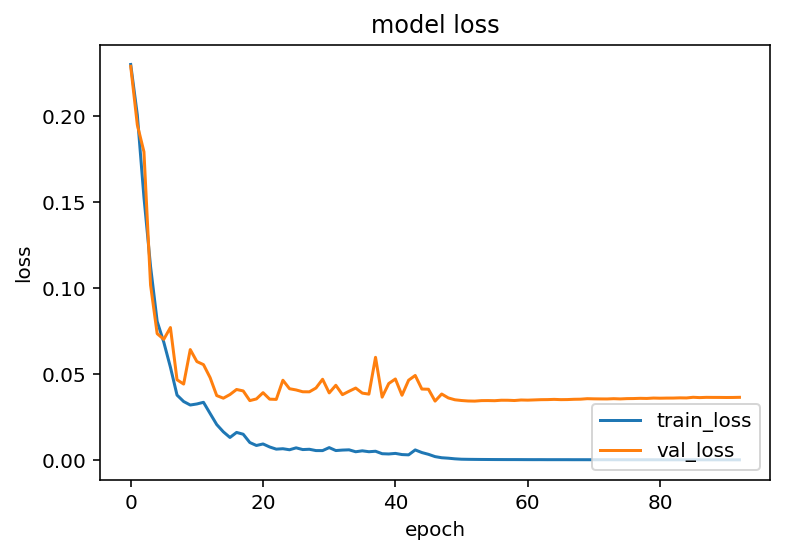

100%|██████████| 20/20 [00:02<00:00,  8.89it/s]
[2017-12-03 16:01:17,826 INFO] TestAcc: 0.9165 | TestLoss: 0.0293 
100%|██████████| 114/114 [00:11<00:00,  9.63it/s]
[2017-12-03 16:01:29,713 INFO] UnlabeledAcc: 0.9097 | UnlabeledLoss: 0.0326 
[2017-12-03 16:01:29,742 INFO] 1.0
[2017-12-03 16:01:30,954 INFO] Epoch: 0 | TrainAcc: 0.1980 | TrainLoss: 0.2216
[2017-12-03 16:01:31,313 INFO] Epoch: 0 | ValAcc: 0.2990 | ValLoss: 0.2178 

[2017-12-03 16:01:31,341 INFO] 0.98
[2017-12-03 16:01:32,545 INFO] Epoch: 1 | TrainAcc: 0.4005 | TrainLoss: 0.1741
[2017-12-03 16:01:32,898 INFO] Epoch: 1 | ValAcc: 0.5460 | ValLoss: 0.1524 

[2017-12-03 16:01:32,921 INFO] 0.96
[2017-12-03 16:01:34,079 INFO] Epoch: 2 | TrainAcc: 0.6393 | TrainLoss: 0.1074
[2017-12-03 16:01:34,420 INFO] Epoch: 2 | ValAcc: 0.5130 | ValLoss: 0.1363 

[2017-12-03 16:01:34,445 INFO] 0.9400000000000001
[2017-12-03 16:01:35,626 INFO] Epoch: 3 | TrainAcc: 0.7500 | TrainLoss: 0.0679
[2017-12-03 16:01:35,997 INFO] Epoch: 3 | ValAcc: 0.76

[2017-12-03 16:02:27,473 INFO] 0.18
[2017-12-03 16:02:28,265 INFO] Epoch: 41 | TrainAcc: 0.9881 | TrainLoss: 0.0023
[2017-12-03 16:02:28,590 INFO] Epoch: 41 | ValAcc: 0.8820 | ValLoss: 0.0407 

[2017-12-03 16:02:28,614 INFO] 0.16
[2017-12-03 16:02:29,389 INFO] Epoch: 42 | TrainAcc: 0.9905 | TrainLoss: 0.0028
[2017-12-03 16:02:29,743 INFO] Epoch: 42 | ValAcc: 0.8580 | ValLoss: 0.0532 

[2017-12-03 16:02:29,773 INFO] 0.14
[2017-12-03 16:02:30,553 INFO] Epoch: 43 | TrainAcc: 0.9991 | TrainLoss: 0.0019
[2017-12-03 16:02:30,896 INFO] Epoch: 43 | ValAcc: 0.8820 | ValLoss: 0.0399 

[2017-12-03 16:02:30,920 INFO] 0.12
[2017-12-03 16:02:31,662 INFO] Epoch: 44 | TrainAcc: 0.9929 | TrainLoss: 0.0015
[2017-12-03 16:02:32,008 INFO] Epoch: 44 | ValAcc: 0.8850 | ValLoss: 0.0387 

[2017-12-03 16:02:32,032 INFO] 0.1
[2017-12-03 16:02:32,774 INFO] Epoch: 45 | TrainAcc: 0.9973 | TrainLoss: 0.0018
[2017-12-03 16:02:33,116 INFO] Epoch: 45 | ValAcc: 0.8840 | ValLoss: 0.0401 

[2017-12-03 16:02:33,140 INFO] 

[2017-12-03 16:03:13,859 INFO] 0
[2017-12-03 16:03:14,510 INFO] Epoch: 84 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:03:14,884 INFO] Epoch: 84 | ValAcc: 0.9010 | ValLoss: 0.0377 

[2017-12-03 16:03:14,907 INFO] 0
[2017-12-03 16:03:15,584 INFO] Epoch: 85 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:03:15,940 INFO] Epoch: 85 | ValAcc: 0.9010 | ValLoss: 0.0378 

[2017-12-03 16:03:15,964 INFO] 0
[2017-12-03 16:03:16,634 INFO] Epoch: 86 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:03:16,985 INFO] Epoch: 86 | ValAcc: 0.9000 | ValLoss: 0.0378 

[2017-12-03 16:03:17,012 INFO] 0
[2017-12-03 16:03:17,690 INFO] Epoch: 87 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:03:18,035 INFO] Epoch: 87 | ValAcc: 0.9020 | ValLoss: 0.0377 

[2017-12-03 16:03:18,061 INFO] 0
[2017-12-03 16:03:18,745 INFO] Epoch: 88 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:03:19,096 INFO] Epoch: 88 | ValAcc: 0.9010 | ValLoss: 0.0377 

[2017-12-03 16:03:19,120 INFO] 0
[2017-12-03 

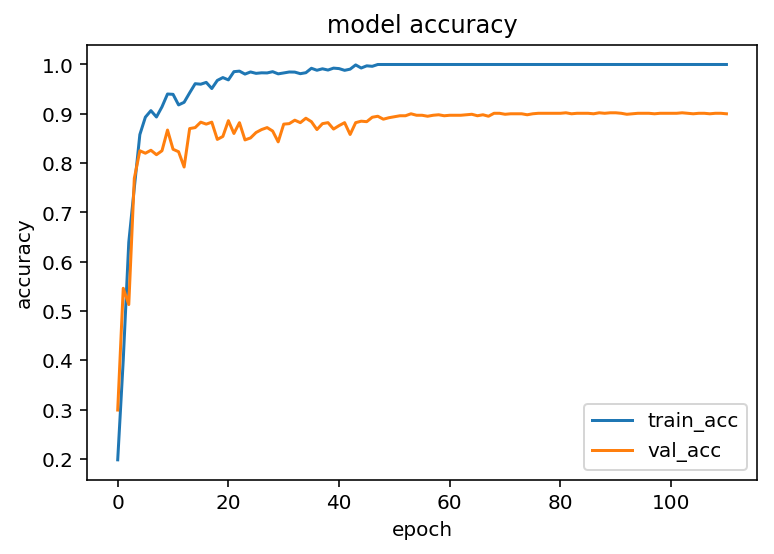

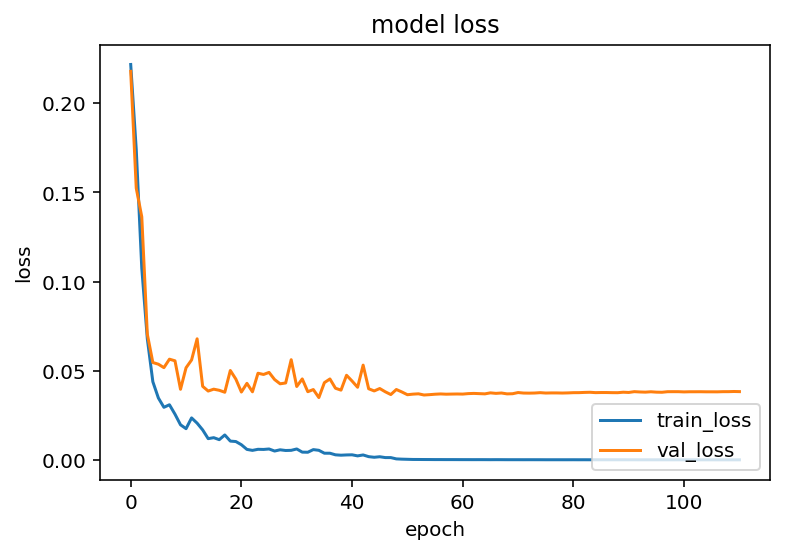

100%|██████████| 20/20 [00:02<00:00,  8.82it/s]
[2017-12-03 16:03:45,529 INFO] TestAcc: 0.9108 | TestLoss: 0.0334 
100%|██████████| 114/114 [00:12<00:00,  8.83it/s]
[2017-12-03 16:03:58,484 INFO] UnlabeledAcc: 0.9023 | UnlabeledLoss: 0.0371 
[2017-12-03 16:03:58,520 INFO] 1.0
[2017-12-03 16:03:59,930 INFO] Epoch: 0 | TrainAcc: 0.1870 | TrainLoss: 0.2142
[2017-12-03 16:04:00,383 INFO] Epoch: 0 | ValAcc: 0.2930 | ValLoss: 0.2109 

[2017-12-03 16:04:00,418 INFO] 0.98
[2017-12-03 16:04:01,773 INFO] Epoch: 1 | TrainAcc: 0.3919 | TrainLoss: 0.1679
[2017-12-03 16:04:02,133 INFO] Epoch: 1 | ValAcc: 0.5710 | ValLoss: 0.1613 

[2017-12-03 16:04:02,160 INFO] 0.96
[2017-12-03 16:04:03,414 INFO] Epoch: 2 | TrainAcc: 0.5582 | TrainLoss: 0.1325
[2017-12-03 16:04:03,748 INFO] Epoch: 2 | ValAcc: 0.4930 | ValLoss: 0.1553 

[2017-12-03 16:04:03,773 INFO] 0.9400000000000001
[2017-12-03 16:04:04,996 INFO] Epoch: 3 | TrainAcc: 0.7046 | TrainLoss: 0.0826
[2017-12-03 16:04:05,327 INFO] Epoch: 3 | ValAcc: 0.65

[2017-12-03 16:04:56,941 INFO] 0.18
[2017-12-03 16:04:57,737 INFO] Epoch: 41 | TrainAcc: 0.9941 | TrainLoss: 0.0027
[2017-12-03 16:04:58,070 INFO] Epoch: 41 | ValAcc: 0.8950 | ValLoss: 0.0367 

[2017-12-03 16:04:58,098 INFO] 0.16
[2017-12-03 16:04:58,864 INFO] Epoch: 42 | TrainAcc: 0.9922 | TrainLoss: 0.0026
[2017-12-03 16:04:59,260 INFO] Epoch: 42 | ValAcc: 0.8760 | ValLoss: 0.0425 

[2017-12-03 16:04:59,288 INFO] 0.14
[2017-12-03 16:05:00,164 INFO] Epoch: 43 | TrainAcc: 0.9939 | TrainLoss: 0.0030
[2017-12-03 16:05:00,574 INFO] Epoch: 43 | ValAcc: 0.8820 | ValLoss: 0.0416 

[2017-12-03 16:05:00,602 INFO] 0.12
[2017-12-03 16:05:01,498 INFO] Epoch: 44 | TrainAcc: 0.9929 | TrainLoss: 0.0022
[2017-12-03 16:05:01,901 INFO] Epoch: 44 | ValAcc: 0.8820 | ValLoss: 0.0394 

[2017-12-03 16:05:01,927 INFO] 0.1
[2017-12-03 16:05:02,700 INFO] Epoch: 45 | TrainAcc: 0.9936 | TrainLoss: 0.0025
[2017-12-03 16:05:03,085 INFO] Epoch: 45 | ValAcc: 0.8870 | ValLoss: 0.0409 

[2017-12-03 16:05:03,111 INFO] 

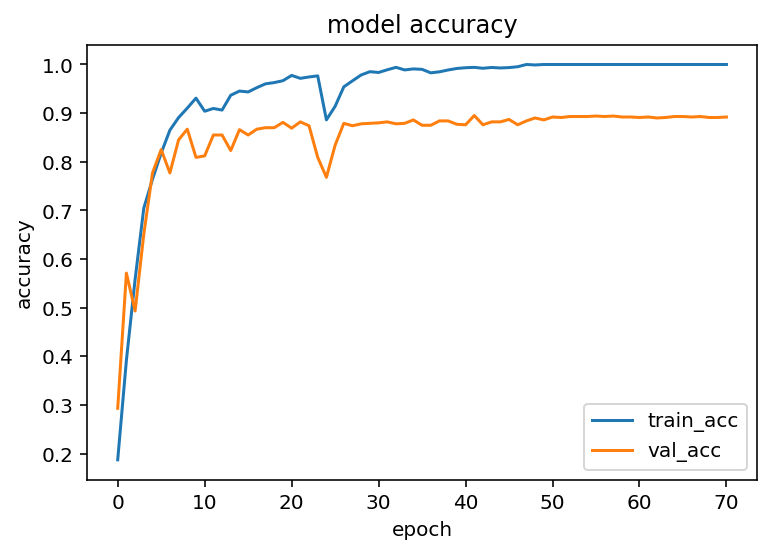

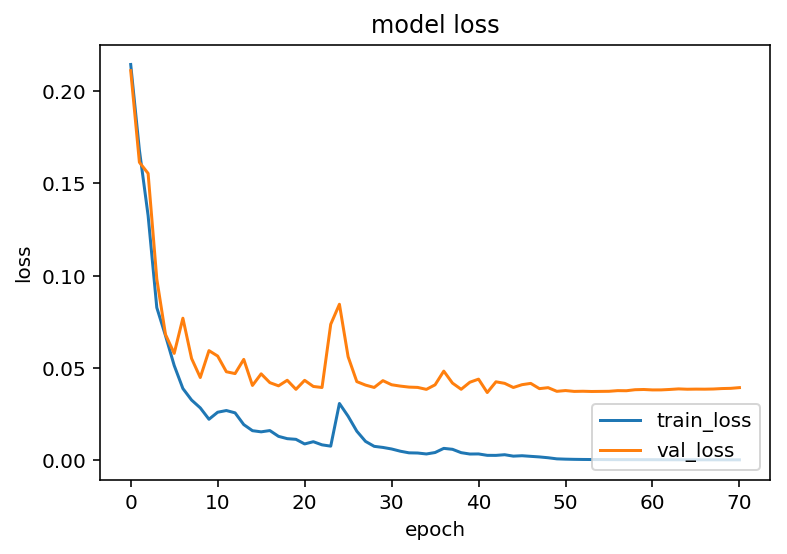

100%|██████████| 20/20 [00:02<00:00,  8.17it/s]
[2017-12-03 16:05:34,276 INFO] TestAcc: 0.9103 | TestLoss: 0.0305 
100%|██████████| 114/114 [00:14<00:00,  7.80it/s]
[2017-12-03 16:05:48,952 INFO] UnlabeledAcc: 0.8998 | UnlabeledLoss: 0.0341 
[2017-12-03 16:05:48,996 INFO] 1.0
[2017-12-03 16:05:50,503 INFO] Epoch: 0 | TrainAcc: 0.1430 | TrainLoss: 0.2255
[2017-12-03 16:05:50,959 INFO] Epoch: 0 | ValAcc: 0.1860 | ValLoss: 0.2201 

[2017-12-03 16:05:50,996 INFO] 0.98
[2017-12-03 16:05:52,462 INFO] Epoch: 1 | TrainAcc: 0.3455 | TrainLoss: 0.1792
[2017-12-03 16:05:52,880 INFO] Epoch: 1 | ValAcc: 0.4260 | ValLoss: 0.1659 

[2017-12-03 16:05:52,907 INFO] 0.96
[2017-12-03 16:05:54,329 INFO] Epoch: 2 | TrainAcc: 0.5699 | TrainLoss: 0.1197
[2017-12-03 16:05:54,745 INFO] Epoch: 2 | ValAcc: 0.5940 | ValLoss: 0.1207 

[2017-12-03 16:05:54,779 INFO] 0.9400000000000001
[2017-12-03 16:05:56,218 INFO] Epoch: 3 | TrainAcc: 0.7010 | TrainLoss: 0.0819
[2017-12-03 16:05:56,620 INFO] Epoch: 3 | ValAcc: 0.63

[2017-12-03 16:06:49,689 INFO] 0.18
[2017-12-03 16:06:50,480 INFO] Epoch: 41 | TrainAcc: 0.9932 | TrainLoss: 0.0019
[2017-12-03 16:06:50,808 INFO] Epoch: 41 | ValAcc: 0.8840 | ValLoss: 0.0382 

[2017-12-03 16:06:50,832 INFO] 0.16
[2017-12-03 16:06:51,588 INFO] Epoch: 42 | TrainAcc: 0.9897 | TrainLoss: 0.0020
[2017-12-03 16:06:51,943 INFO] Epoch: 42 | ValAcc: 0.8880 | ValLoss: 0.0379 

[2017-12-03 16:06:51,967 INFO] 0.14
[2017-12-03 16:06:52,747 INFO] Epoch: 43 | TrainAcc: 0.9939 | TrainLoss: 0.0033
[2017-12-03 16:06:53,117 INFO] Epoch: 43 | ValAcc: 0.8760 | ValLoss: 0.0469 

[2017-12-03 16:06:53,154 INFO] 0.12
[2017-12-03 16:06:53,915 INFO] Epoch: 44 | TrainAcc: 0.9911 | TrainLoss: 0.0034
[2017-12-03 16:06:54,270 INFO] Epoch: 44 | ValAcc: 0.8960 | ValLoss: 0.0398 

[2017-12-03 16:06:54,296 INFO] 0.1
[2017-12-03 16:06:55,027 INFO] Epoch: 45 | TrainAcc: 0.9945 | TrainLoss: 0.0028
[2017-12-03 16:06:55,382 INFO] Epoch: 45 | ValAcc: 0.8890 | ValLoss: 0.0440 

[2017-12-03 16:06:55,414 INFO] 

[2017-12-03 16:07:38,464 INFO] 0
[2017-12-03 16:07:39,268 INFO] Epoch: 84 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:07:39,800 INFO] Epoch: 84 | ValAcc: 0.9020 | ValLoss: 0.0401 

[2017-12-03 16:07:39,828 INFO] 0
[2017-12-03 16:07:40,631 INFO] Epoch: 85 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:07:41,065 INFO] Epoch: 85 | ValAcc: 0.9020 | ValLoss: 0.0400 

[2017-12-03 16:07:41,100 INFO] 0
[2017-12-03 16:07:41,778 INFO] Epoch: 86 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:07:42,132 INFO] Epoch: 86 | ValAcc: 0.9020 | ValLoss: 0.0399 

[2017-12-03 16:07:42,157 INFO] 0
[2017-12-03 16:07:42,849 INFO] Epoch: 87 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:07:43,197 INFO] Epoch: 87 | ValAcc: 0.9020 | ValLoss: 0.0398 

[2017-12-03 16:07:43,221 INFO] 0
[2017-12-03 16:07:43,897 INFO] Epoch: 88 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 16:07:44,253 INFO] Epoch: 88 | ValAcc: 0.9020 | ValLoss: 0.0399 

[2017-12-03 16:07:44,277 INFO] 0
[2017-12-03 

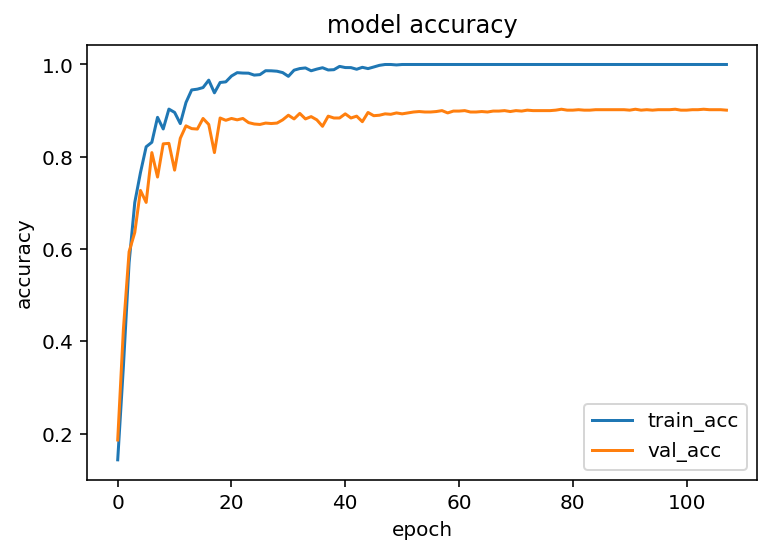

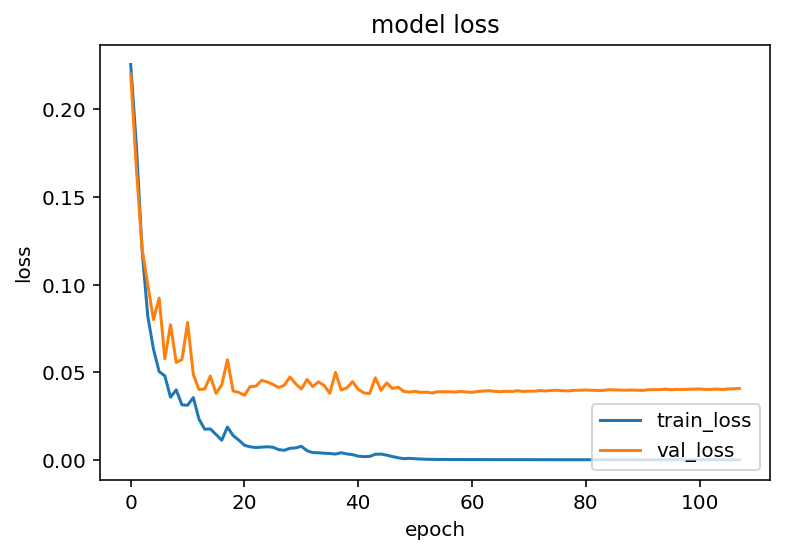

100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
[2017-12-03 16:08:08,949 INFO] TestAcc: 0.9169 | TestLoss: 0.0300 
100%|██████████| 114/114 [00:17<00:00,  6.49it/s]
[2017-12-03 16:08:26,575 INFO] UnlabeledAcc: 0.9094 | UnlabeledLoss: 0.0337 


In [38]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
hard = False
ex_name = 'pseudo_ann_'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_dataset = MNISTDataset(X_val, y_val, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch_size, num_workers=num_workers)
test_dataset = MNISTDataset(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, num_workers=num_workers)
unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
unlabeled_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)


results_ann_ = {}
results_ann_['test_acc'] = np.empty((trial_times))
results_ann_['test_loss'] = np.empty((trial_times))
results_ann_['unlabeled_acc'] = np.empty((trial_times))
results_ann_['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch
        
        #optimizer.param_groups[0]['lr'] = 0.5 * (0.1 ** (epoch // 30))
        #ratio_pl = min(0.02 * max(epoch - 10, 0), 1.5) 
        ratio_pl = max(0.01 * (100 - epoch*2), 0)
        logger.info(ratio_pl)
        train_dataset = MNISTDatasetForPseudoLabeling(
            X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_ann_['test_acc'][i], results_ann_['test_loss'][i] = _test(model, test_loader, criterion)
    results_ann_['unlabeled_acc'][i], results_ann_['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [39]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann_['test_acc']),
    np.std(results_ann_['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_ann_['test_loss']),
    np.std(results_ann_['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann_['unlabeled_acc']),
    np.std(results_ann_['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_ann_['unlabeled_loss']),
    np.std(results_ann_['unlabeled_loss'])
))

t, p = stats.ttest_rel(results_ann['test_acc'], results_ann_['test_acc'])
print( "ann_ or const on soft：p値 = %(p)s" %locals() )

[2017-12-03 16:08:26,686 INFO] Test Accuracy: 0.9122 ± 0.0072
[2017-12-03 16:08:26,689 INFO] Test Loss: 0.0307 ± 0.0022

[2017-12-03 16:08:26,691 INFO] Unlabeled Accuracy: 0.9039 ± 0.0072
[2017-12-03 16:08:26,692 INFO] Unlabeled Loss: 0.0340 ± 0.0019


ann_ or const on soft：p値 = 0.141227906662


# hierarchical pseudo label training

Prepare pseudo label

In [22]:
y_pseudo = np.load('./save/pseudo_label_soft.npy')
y_pseudo = y_pseudo[:58000]

[2017-12-03 04:59:47,326 INFO] Epoch: 0 | TrainAcc: 0.2185 | TrainLoss: 0.2121
[2017-12-03 04:59:47,830 INFO] Epoch: 0 | ValAcc: 0.3430 | ValLoss: 0.2099 

[2017-12-03 04:59:49,432 INFO] Epoch: 1 | TrainAcc: 0.4800 | TrainLoss: 0.1569
[2017-12-03 04:59:49,915 INFO] Epoch: 1 | ValAcc: 0.5050 | ValLoss: 0.1450 

[2017-12-03 04:59:51,572 INFO] Epoch: 2 | TrainAcc: 0.6930 | TrainLoss: 0.0903
[2017-12-03 04:59:52,051 INFO] Epoch: 2 | ValAcc: 0.7140 | ValLoss: 0.0827 

[2017-12-03 04:59:53,872 INFO] Epoch: 3 | TrainAcc: 0.7920 | TrainLoss: 0.0581
[2017-12-03 04:59:54,427 INFO] Epoch: 3 | ValAcc: 0.7710 | ValLoss: 0.0679 

[2017-12-03 04:59:56,438 INFO] Epoch: 4 | TrainAcc: 0.8250 | TrainLoss: 0.0457
[2017-12-03 04:59:56,984 INFO] Epoch: 4 | ValAcc: 0.7490 | ValLoss: 0.0773 

[2017-12-03 04:59:58,775 INFO] Epoch: 5 | TrainAcc: 0.8620 | TrainLoss: 0.0359
[2017-12-03 04:59:59,451 INFO] Epoch: 5 | ValAcc: 0.8200 | ValLoss: 0.0551 

[2017-12-03 05:00:01,277 INFO] Epoch: 6 | TrainAcc: 0.8700 | Tra

[2017-12-03 05:01:33,188 INFO] Epoch: 52 | TrainAcc: 0.9805 | TrainLoss: 0.0043
[2017-12-03 05:01:33,586 INFO] Epoch: 52 | ValAcc: 0.8690 | ValLoss: 0.0423 

[2017-12-03 05:01:34,953 INFO] Epoch: 53 | TrainAcc: 0.9815 | TrainLoss: 0.0037
[2017-12-03 05:01:35,319 INFO] Epoch: 53 | ValAcc: 0.8900 | ValLoss: 0.0378 

[2017-12-03 05:01:36,703 INFO] Epoch: 54 | TrainAcc: 0.9860 | TrainLoss: 0.0031
[2017-12-03 05:01:37,094 INFO] Epoch: 54 | ValAcc: 0.8880 | ValLoss: 0.0383 

[2017-12-03 05:01:38,419 INFO] Epoch: 55 | TrainAcc: 0.9860 | TrainLoss: 0.0033
[2017-12-03 05:01:38,790 INFO] Epoch: 55 | ValAcc: 0.8910 | ValLoss: 0.0360 

[2017-12-03 05:01:40,187 INFO] Epoch: 56 | TrainAcc: 0.9830 | TrainLoss: 0.0040
[2017-12-03 05:01:40,559 INFO] Epoch: 56 | ValAcc: 0.8990 | ValLoss: 0.0335 

[2017-12-03 05:01:42,000 INFO] Epoch: 57 | TrainAcc: 0.9905 | TrainLoss: 0.0035
[2017-12-03 05:01:42,365 INFO] Epoch: 57 | ValAcc: 0.9030 | ValLoss: 0.0331 

[2017-12-03 05:01:43,761 INFO] Epoch: 58 | TrainAcc:

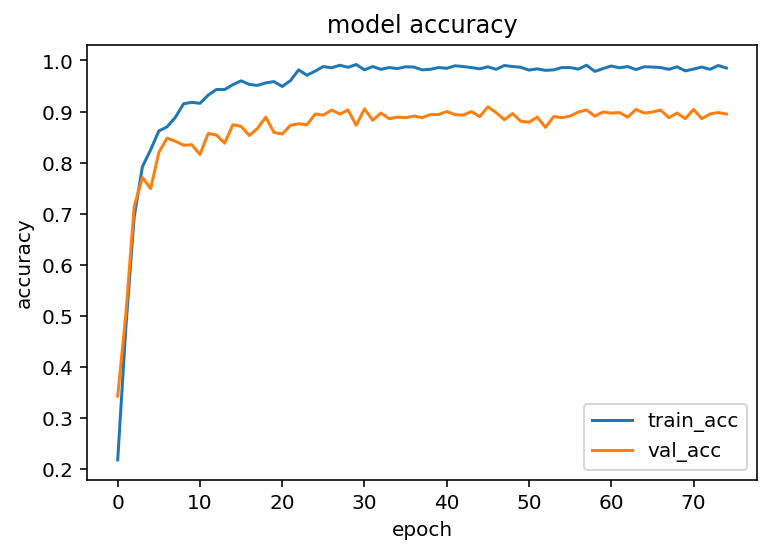

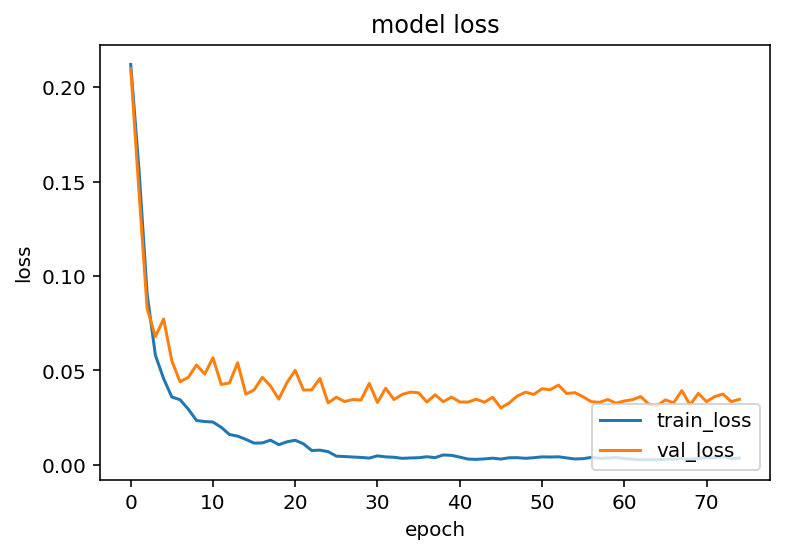

100%|██████████| 20/20 [00:03<00:00,  5.03it/s]
[2017-12-03 05:02:23,580 INFO] TestAcc: 0.9185 | TestLoss: 0.0265 
100%|██████████| 114/114 [00:19<00:00,  5.89it/s]
[2017-12-03 05:02:43,016 INFO] UnlabeledAcc: 0.9108 | UnlabeledLoss: 0.0290 
[2017-12-03 05:02:44,635 INFO] Epoch: 0 | TrainAcc: 0.1585 | TrainLoss: 0.2217
[2017-12-03 05:02:45,114 INFO] Epoch: 0 | ValAcc: 0.2550 | ValLoss: 0.2226 

[2017-12-03 05:02:46,697 INFO] Epoch: 1 | TrainAcc: 0.3140 | TrainLoss: 0.1859
[2017-12-03 05:02:47,152 INFO] Epoch: 1 | ValAcc: 0.4780 | ValLoss: 0.1693 

[2017-12-03 05:02:48,790 INFO] Epoch: 2 | TrainAcc: 0.5430 | TrainLoss: 0.1326
[2017-12-03 05:02:49,223 INFO] Epoch: 2 | ValAcc: 0.5640 | ValLoss: 0.1263 

[2017-12-03 05:02:50,838 INFO] Epoch: 3 | TrainAcc: 0.6870 | TrainLoss: 0.0896
[2017-12-03 05:02:51,291 INFO] Epoch: 3 | ValAcc: 0.5870 | ValLoss: 0.1189 

[2017-12-03 05:02:52,852 INFO] Epoch: 4 | TrainAcc: 0.7440 | TrainLoss: 0.0701
[2017-12-03 05:02:53,291 INFO] Epoch: 4 | ValAcc: 0.762

[2017-12-03 05:04:25,676 INFO] Epoch: 50 | ValAcc: 0.8980 | ValLoss: 0.0348 

[2017-12-03 05:04:27,193 INFO] Epoch: 51 | TrainAcc: 0.9865 | TrainLoss: 0.0048
[2017-12-03 05:04:27,737 INFO] Epoch: 51 | ValAcc: 0.8910 | ValLoss: 0.0383 

[2017-12-03 05:04:29,228 INFO] Epoch: 52 | TrainAcc: 0.9815 | TrainLoss: 0.0048
[2017-12-03 05:04:29,686 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0366 

[2017-12-03 05:04:31,130 INFO] Epoch: 53 | TrainAcc: 0.9800 | TrainLoss: 0.0044
[2017-12-03 05:04:31,559 INFO] Epoch: 53 | ValAcc: 0.8940 | ValLoss: 0.0338 

[2017-12-03 05:04:33,016 INFO] Epoch: 54 | TrainAcc: 0.9865 | TrainLoss: 0.0042
[2017-12-03 05:04:33,458 INFO] Epoch: 54 | ValAcc: 0.8860 | ValLoss: 0.0373 

[2017-12-03 05:04:34,945 INFO] Epoch: 55 | TrainAcc: 0.9700 | TrainLoss: 0.0056
[2017-12-03 05:04:35,375 INFO] Epoch: 55 | ValAcc: 0.8860 | ValLoss: 0.0375 

[2017-12-03 05:04:36,835 INFO] Epoch: 56 | TrainAcc: 0.9855 | TrainLoss: 0.0050
[2017-12-03 05:04:37,288 INFO] Epoch: 56 | ValAcc: 0

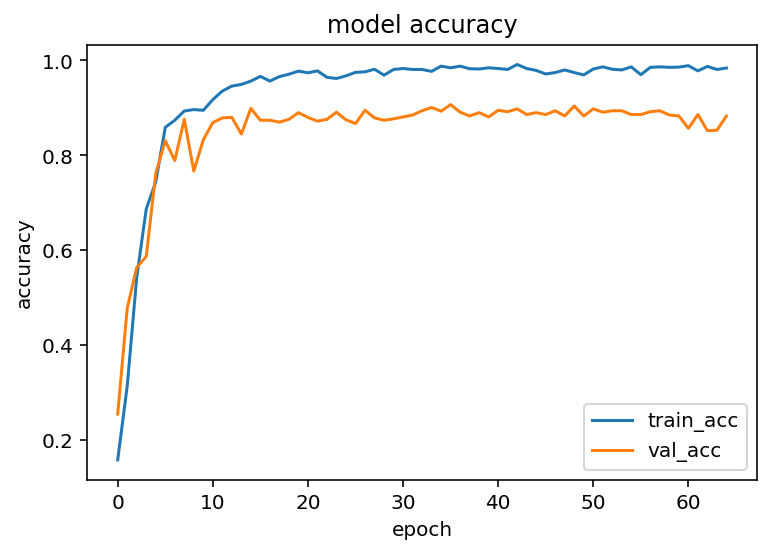

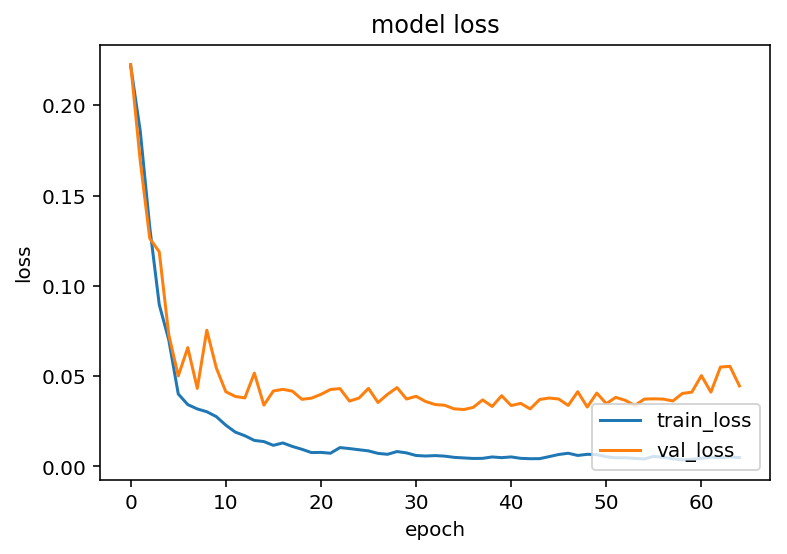

100%|██████████| 20/20 [00:03<00:00,  6.01it/s]
[2017-12-03 05:04:56,217 INFO] TestAcc: 0.9129 | TestLoss: 0.0284 
100%|██████████| 114/114 [00:18<00:00,  6.20it/s]
[2017-12-03 05:05:14,682 INFO] UnlabeledAcc: 0.9010 | UnlabeledLoss: 0.0320 
[2017-12-03 05:05:16,187 INFO] Epoch: 0 | TrainAcc: 0.1810 | TrainLoss: 0.2263
[2017-12-03 05:05:16,639 INFO] Epoch: 0 | ValAcc: 0.1670 | ValLoss: 0.2213 

[2017-12-03 05:05:18,254 INFO] Epoch: 1 | TrainAcc: 0.3220 | TrainLoss: 0.1854
[2017-12-03 05:05:18,677 INFO] Epoch: 1 | ValAcc: 0.3550 | ValLoss: 0.1785 

[2017-12-03 05:05:20,227 INFO] Epoch: 2 | TrainAcc: 0.5475 | TrainLoss: 0.1369
[2017-12-03 05:05:20,678 INFO] Epoch: 2 | ValAcc: 0.5490 | ValLoss: 0.1291 

[2017-12-03 05:05:22,266 INFO] Epoch: 3 | TrainAcc: 0.6660 | TrainLoss: 0.0925
[2017-12-03 05:05:22,709 INFO] Epoch: 3 | ValAcc: 0.6780 | ValLoss: 0.0914 

[2017-12-03 05:05:24,282 INFO] Epoch: 4 | TrainAcc: 0.7860 | TrainLoss: 0.0582
[2017-12-03 05:05:24,698 INFO] Epoch: 4 | ValAcc: 0.751

[2017-12-03 05:06:55,574 INFO] Epoch: 50 | ValAcc: 0.8900 | ValLoss: 0.0393 

[2017-12-03 05:06:55,605 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 05:06:55,607 INFO] Train done.
[2017-12-03 05:06:55,609 INFO] Elapsed Time: 100.89158606529236


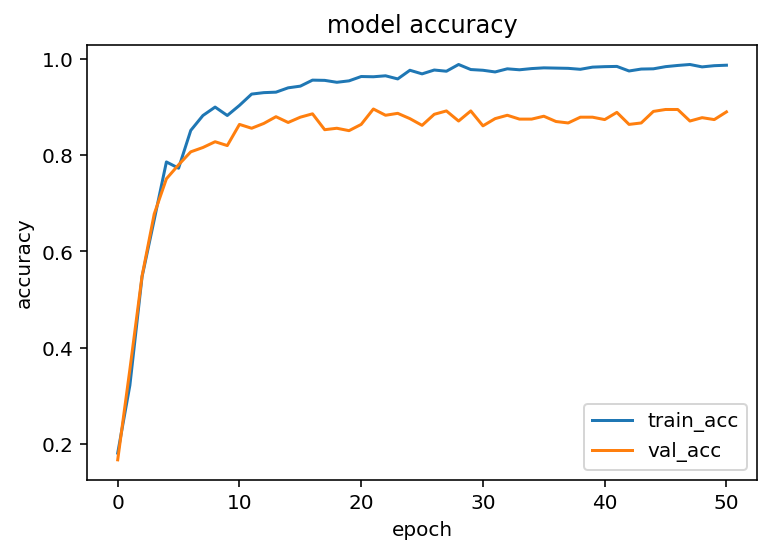

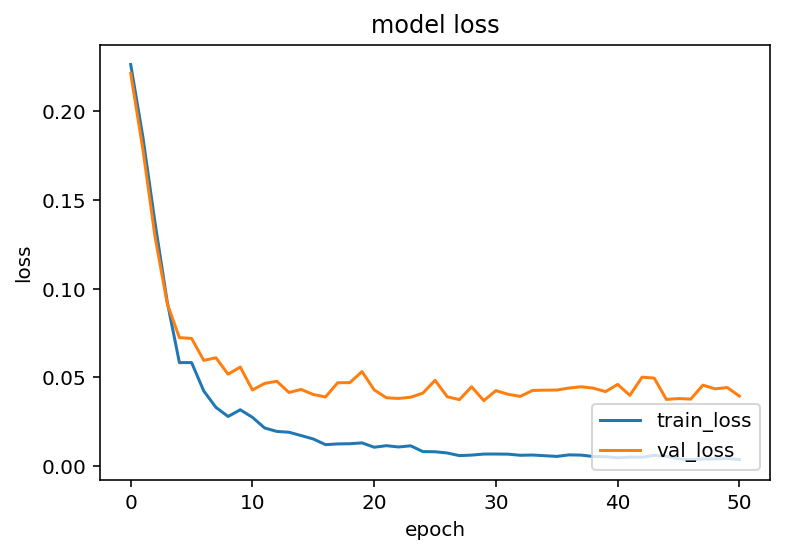

100%|██████████| 20/20 [00:03<00:00,  5.31it/s]
[2017-12-03 05:06:59,753 INFO] TestAcc: 0.8970 | TestLoss: 0.0329 
100%|██████████| 114/114 [00:18<00:00,  6.25it/s]
[2017-12-03 05:07:18,067 INFO] UnlabeledAcc: 0.8933 | UnlabeledLoss: 0.0348 
[2017-12-03 05:07:19,530 INFO] Epoch: 0 | TrainAcc: 0.1435 | TrainLoss: 0.2288
[2017-12-03 05:07:19,997 INFO] Epoch: 0 | ValAcc: 0.2000 | ValLoss: 0.2235 

[2017-12-03 05:07:21,474 INFO] Epoch: 1 | TrainAcc: 0.3340 | TrainLoss: 0.1868
[2017-12-03 05:07:21,990 INFO] Epoch: 1 | ValAcc: 0.4690 | ValLoss: 0.1727 

[2017-12-03 05:07:23,520 INFO] Epoch: 2 | TrainAcc: 0.5540 | TrainLoss: 0.1272
[2017-12-03 05:07:23,958 INFO] Epoch: 2 | ValAcc: 0.4100 | ValLoss: 0.1556 

[2017-12-03 05:07:25,460 INFO] Epoch: 3 | TrainAcc: 0.6785 | TrainLoss: 0.0846
[2017-12-03 05:07:25,963 INFO] Epoch: 3 | ValAcc: 0.5960 | ValLoss: 0.1292 

[2017-12-03 05:07:27,489 INFO] Epoch: 4 | TrainAcc: 0.7670 | TrainLoss: 0.0631
[2017-12-03 05:07:27,985 INFO] Epoch: 4 | ValAcc: 0.710

[2017-12-03 05:08:59,079 INFO] Epoch: 50 | ValAcc: 0.8700 | ValLoss: 0.0477 

[2017-12-03 05:09:00,687 INFO] Epoch: 51 | TrainAcc: 0.9805 | TrainLoss: 0.0048
[2017-12-03 05:09:01,119 INFO] Epoch: 51 | ValAcc: 0.8950 | ValLoss: 0.0385 

[2017-12-03 05:09:02,634 INFO] Epoch: 52 | TrainAcc: 0.9890 | TrainLoss: 0.0041
[2017-12-03 05:09:03,059 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0355 

[2017-12-03 05:09:04,620 INFO] Epoch: 53 | TrainAcc: 0.9830 | TrainLoss: 0.0036
[2017-12-03 05:09:05,107 INFO] Epoch: 53 | ValAcc: 0.9010 | ValLoss: 0.0320 

[2017-12-03 05:09:05,142 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 05:09:05,146 INFO] Train done.
[2017-12-03 05:09:05,149 INFO] Elapsed Time: 107.04746699333191


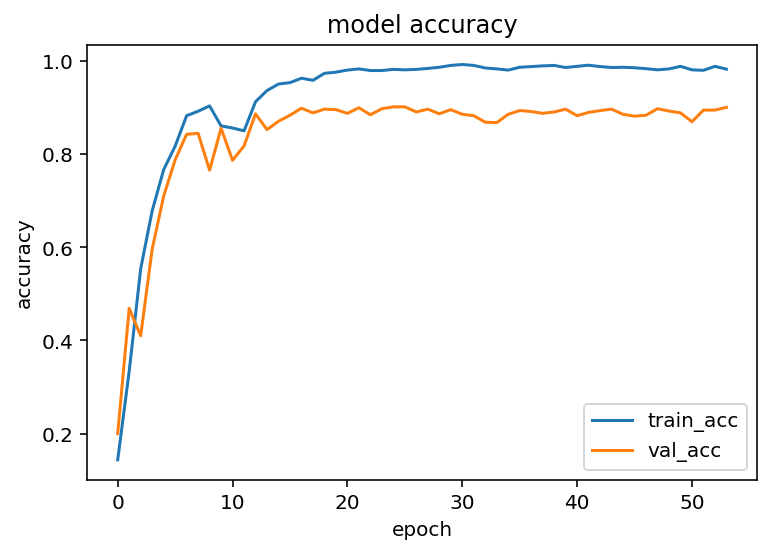

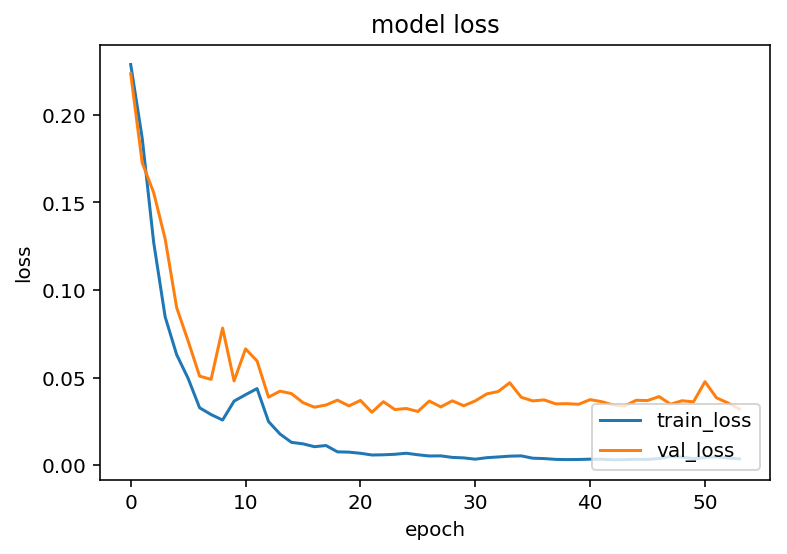

100%|██████████| 20/20 [00:03<00:00,  5.79it/s]
[2017-12-03 05:09:09,075 INFO] TestAcc: 0.9163 | TestLoss: 0.0276 
100%|██████████| 114/114 [00:17<00:00,  6.38it/s]
[2017-12-03 05:09:27,014 INFO] UnlabeledAcc: 0.9065 | UnlabeledLoss: 0.0304 
[2017-12-03 05:09:28,472 INFO] Epoch: 0 | TrainAcc: 0.1900 | TrainLoss: 0.2181
[2017-12-03 05:09:28,919 INFO] Epoch: 0 | ValAcc: 0.1590 | ValLoss: 0.2193 

[2017-12-03 05:09:30,397 INFO] Epoch: 1 | TrainAcc: 0.4130 | TrainLoss: 0.1679
[2017-12-03 05:09:30,822 INFO] Epoch: 1 | ValAcc: 0.5670 | ValLoss: 0.1480 

[2017-12-03 05:09:32,297 INFO] Epoch: 2 | TrainAcc: 0.6590 | TrainLoss: 0.0988
[2017-12-03 05:09:32,752 INFO] Epoch: 2 | ValAcc: 0.6920 | ValLoss: 0.0892 

[2017-12-03 05:09:34,278 INFO] Epoch: 3 | TrainAcc: 0.7890 | TrainLoss: 0.0572
[2017-12-03 05:09:34,751 INFO] Epoch: 3 | ValAcc: 0.7850 | ValLoss: 0.0634 

[2017-12-03 05:09:36,232 INFO] Epoch: 4 | TrainAcc: 0.8525 | TrainLoss: 0.0422
[2017-12-03 05:09:36,693 INFO] Epoch: 4 | ValAcc: 0.805

[2017-12-03 05:11:09,061 INFO] Epoch: 50 | ValAcc: 0.8830 | ValLoss: 0.0434 

[2017-12-03 05:11:10,667 INFO] Epoch: 51 | TrainAcc: 0.9795 | TrainLoss: 0.0052
[2017-12-03 05:11:11,118 INFO] Epoch: 51 | ValAcc: 0.8750 | ValLoss: 0.0438 

[2017-12-03 05:11:12,616 INFO] Epoch: 52 | TrainAcc: 0.9855 | TrainLoss: 0.0041
[2017-12-03 05:11:13,056 INFO] Epoch: 52 | ValAcc: 0.8850 | ValLoss: 0.0422 

[2017-12-03 05:11:14,656 INFO] Epoch: 53 | TrainAcc: 0.9880 | TrainLoss: 0.0041
[2017-12-03 05:11:15,094 INFO] Epoch: 53 | ValAcc: 0.8670 | ValLoss: 0.0494 

[2017-12-03 05:11:16,645 INFO] Epoch: 54 | TrainAcc: 0.9875 | TrainLoss: 0.0043
[2017-12-03 05:11:17,080 INFO] Epoch: 54 | ValAcc: 0.8790 | ValLoss: 0.0447 

[2017-12-03 05:11:18,640 INFO] Epoch: 55 | TrainAcc: 0.9840 | TrainLoss: 0.0038
[2017-12-03 05:11:19,066 INFO] Epoch: 55 | ValAcc: 0.8610 | ValLoss: 0.0508 

[2017-12-03 05:11:20,620 INFO] Epoch: 56 | TrainAcc: 0.9855 | TrainLoss: 0.0044
[2017-12-03 05:11:21,057 INFO] Epoch: 56 | ValAcc: 0

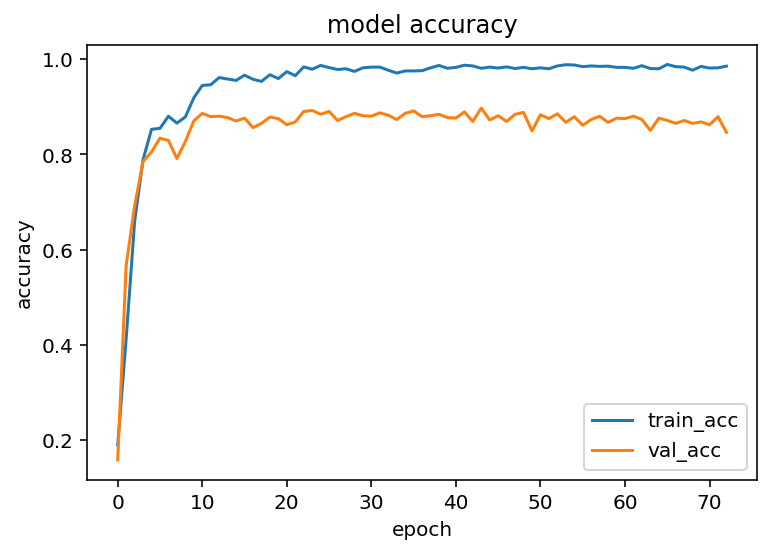

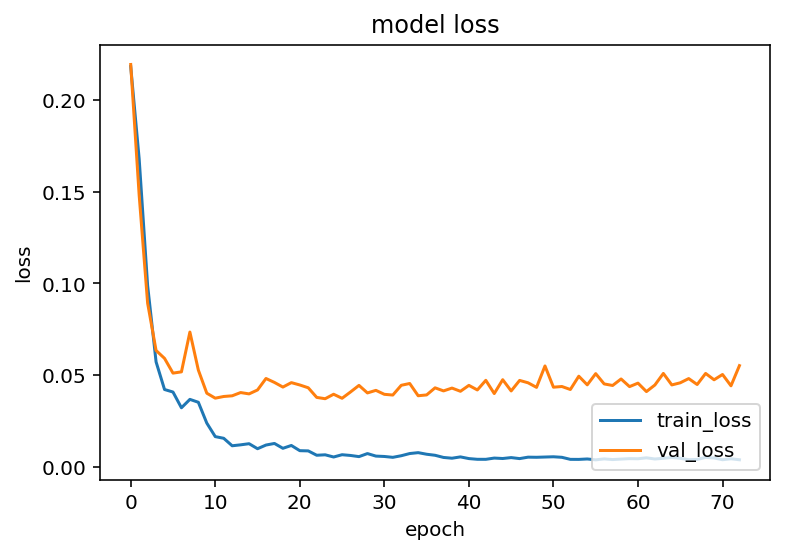

100%|██████████| 20/20 [00:03<00:00,  6.05it/s]
[2017-12-03 05:11:56,065 INFO] TestAcc: 0.9109 | TestLoss: 0.0303 
100%|██████████| 114/114 [00:18<00:00,  6.20it/s]
[2017-12-03 05:12:14,520 INFO] UnlabeledAcc: 0.8996 | UnlabeledLoss: 0.0340 
[2017-12-03 05:12:16,020 INFO] Epoch: 0 | TrainAcc: 0.1350 | TrainLoss: 0.2239
[2017-12-03 05:12:16,478 INFO] Epoch: 0 | ValAcc: 0.2600 | ValLoss: 0.2199 

[2017-12-03 05:12:18,056 INFO] Epoch: 1 | TrainAcc: 0.3745 | TrainLoss: 0.1853
[2017-12-03 05:12:18,504 INFO] Epoch: 1 | ValAcc: 0.4910 | ValLoss: 0.1712 

[2017-12-03 05:12:20,091 INFO] Epoch: 2 | TrainAcc: 0.6015 | TrainLoss: 0.1189
[2017-12-03 05:12:20,527 INFO] Epoch: 2 | ValAcc: 0.5870 | ValLoss: 0.1244 

[2017-12-03 05:12:22,143 INFO] Epoch: 3 | TrainAcc: 0.7135 | TrainLoss: 0.0816
[2017-12-03 05:12:22,612 INFO] Epoch: 3 | ValAcc: 0.6830 | ValLoss: 0.0994 

[2017-12-03 05:12:24,140 INFO] Epoch: 4 | TrainAcc: 0.7735 | TrainLoss: 0.0620
[2017-12-03 05:12:24,570 INFO] Epoch: 4 | ValAcc: 0.761

[2017-12-03 06:02:07,105 INFO] Epoch: 50 | ValAcc: 0.8860 | ValLoss: 0.0375 

[2017-12-03 06:02:08,660 INFO] Epoch: 51 | TrainAcc: 0.9880 | TrainLoss: 0.0041
[2017-12-03 06:02:09,103 INFO] Epoch: 51 | ValAcc: 0.8840 | ValLoss: 0.0365 

[2017-12-03 06:02:10,573 INFO] Epoch: 52 | TrainAcc: 0.9870 | TrainLoss: 0.0037
[2017-12-03 06:02:11,000 INFO] Epoch: 52 | ValAcc: 0.8910 | ValLoss: 0.0366 

[2017-12-03 06:02:12,588 INFO] Epoch: 53 | TrainAcc: 0.9855 | TrainLoss: 0.0037
[2017-12-03 06:02:13,015 INFO] Epoch: 53 | ValAcc: 0.8780 | ValLoss: 0.0397 

[2017-12-03 06:02:14,524 INFO] Epoch: 54 | TrainAcc: 0.9880 | TrainLoss: 0.0039
[2017-12-03 06:02:14,965 INFO] Epoch: 54 | ValAcc: 0.8920 | ValLoss: 0.0365 

[2017-12-03 06:02:16,539 INFO] Epoch: 55 | TrainAcc: 0.9865 | TrainLoss: 0.0037
[2017-12-03 06:02:17,013 INFO] Epoch: 55 | ValAcc: 0.8720 | ValLoss: 0.0420 

[2017-12-03 06:02:18,532 INFO] Epoch: 56 | TrainAcc: 0.9825 | TrainLoss: 0.0043
[2017-12-03 06:02:18,973 INFO] Epoch: 56 | ValAcc: 0

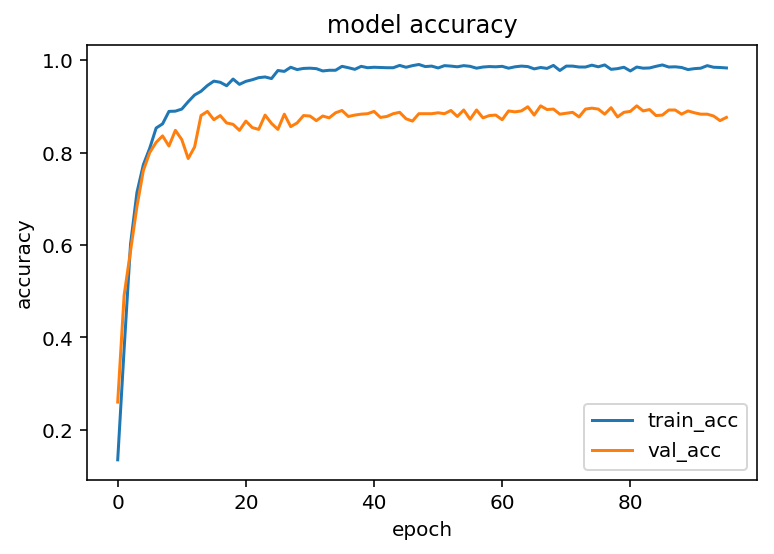

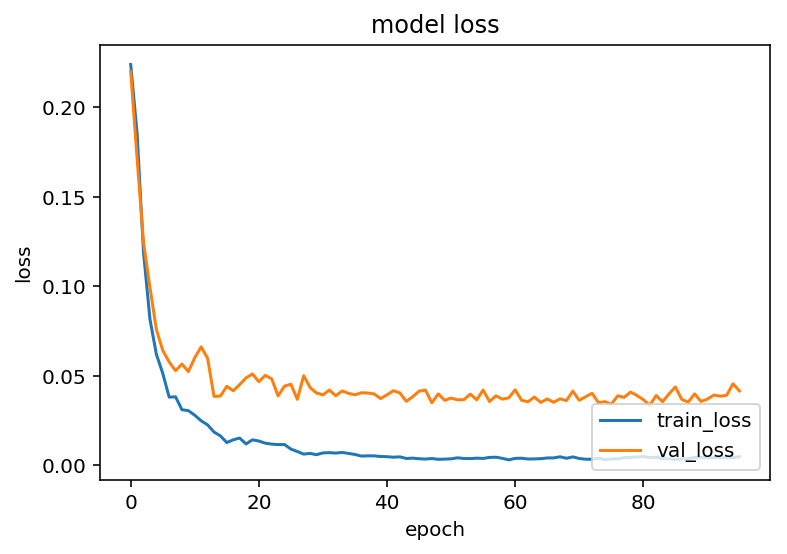

100%|██████████| 20/20 [00:03<00:00,  6.39it/s]
[2017-12-03 07:56:21,603 INFO] TestAcc: 0.9064 | TestLoss: 0.0320 
100%|██████████| 114/114 [00:16<00:00,  6.93it/s]
[2017-12-03 07:56:38,112 INFO] UnlabeledAcc: 0.8980 | UnlabeledLoss: 0.0352 
[2017-12-03 07:56:39,560 INFO] Epoch: 0 | TrainAcc: 0.2035 | TrainLoss: 0.2152
[2017-12-03 07:56:39,995 INFO] Epoch: 0 | ValAcc: 0.1850 | ValLoss: 0.2173 

[2017-12-03 07:56:41,528 INFO] Epoch: 1 | TrainAcc: 0.3930 | TrainLoss: 0.1679
[2017-12-03 07:56:41,966 INFO] Epoch: 1 | ValAcc: 0.5220 | ValLoss: 0.1526 

[2017-12-03 07:56:43,551 INFO] Epoch: 2 | TrainAcc: 0.5880 | TrainLoss: 0.1120
[2017-12-03 07:56:43,980 INFO] Epoch: 2 | ValAcc: 0.5690 | ValLoss: 0.1209 

[2017-12-03 07:56:45,625 INFO] Epoch: 3 | TrainAcc: 0.7125 | TrainLoss: 0.0781
[2017-12-03 09:00:29,548 INFO] Epoch: 3 | ValAcc: 0.7600 | ValLoss: 0.0773 

[2017-12-03 09:00:31,484 INFO] Epoch: 4 | TrainAcc: 0.8265 | TrainLoss: 0.0479
[2017-12-03 09:00:31,901 INFO] Epoch: 4 | ValAcc: 0.751

[2017-12-03 11:00:22,398 INFO] Epoch: 50 | ValAcc: 0.8930 | ValLoss: 0.0360 

[2017-12-03 11:00:23,867 INFO] Epoch: 51 | TrainAcc: 0.9830 | TrainLoss: 0.0039
[2017-12-03 11:00:24,344 INFO] Epoch: 51 | ValAcc: 0.8900 | ValLoss: 0.0347 

[2017-12-03 11:00:25,780 INFO] Epoch: 52 | TrainAcc: 0.9875 | TrainLoss: 0.0043
[2017-12-03 11:00:29,392 INFO] Epoch: 52 | ValAcc: 0.8920 | ValLoss: 0.0362 

[2017-12-03 11:00:37,298 INFO] Epoch: 53 | TrainAcc: 0.9835 | TrainLoss: 0.0037
[2017-12-03 11:00:37,812 INFO] Epoch: 53 | ValAcc: 0.9000 | ValLoss: 0.0334 

[2017-12-03 11:00:37,843 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 11:00:37,845 INFO] Train done.
[2017-12-03 11:00:37,846 INFO] Elapsed Time: 11039.70323419571


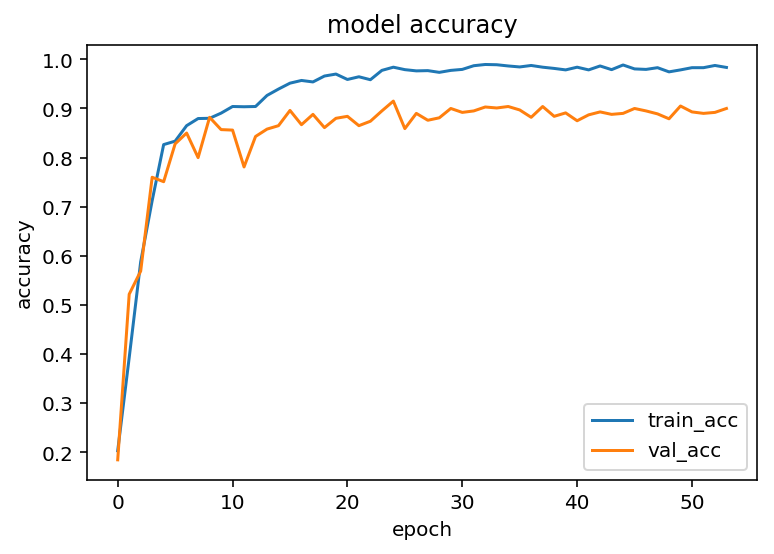

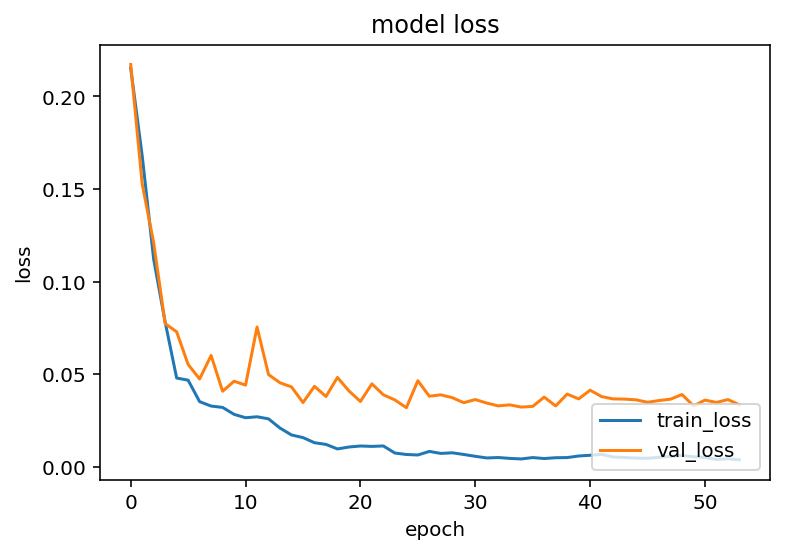

100%|██████████| 20/20 [00:03<00:00,  6.59it/s]
[2017-12-03 11:00:41,228 INFO] TestAcc: 0.9000 | TestLoss: 0.0322 
100%|██████████| 114/114 [00:16<00:00,  6.75it/s]
[2017-12-03 11:00:58,170 INFO] UnlabeledAcc: 0.8888 | UnlabeledLoss: 0.0360 
[2017-12-03 11:00:59,677 INFO] Epoch: 0 | TrainAcc: 0.1935 | TrainLoss: 0.2130
[2017-12-03 11:01:00,136 INFO] Epoch: 0 | ValAcc: 0.3610 | ValLoss: 0.2081 

[2017-12-03 11:01:01,793 INFO] Epoch: 1 | TrainAcc: 0.3880 | TrainLoss: 0.1645
[2017-12-03 11:01:02,232 INFO] Epoch: 1 | ValAcc: 0.5020 | ValLoss: 0.1604 

[2017-12-03 11:01:03,812 INFO] Epoch: 2 | TrainAcc: 0.5905 | TrainLoss: 0.1130
[2017-12-03 11:01:04,271 INFO] Epoch: 2 | ValAcc: 0.6450 | ValLoss: 0.1035 

[2017-12-03 11:01:05,800 INFO] Epoch: 3 | TrainAcc: 0.7950 | TrainLoss: 0.0632
[2017-12-03 11:01:06,231 INFO] Epoch: 3 | ValAcc: 0.7450 | ValLoss: 0.0786 

[2017-12-03 11:54:39,193 INFO] Epoch: 4 | TrainAcc: 0.8350 | TrainLoss: 0.0465
[2017-12-03 11:54:39,737 INFO] Epoch: 4 | ValAcc: 0.829

[2017-12-03 12:57:02,811 INFO] Epoch: 50 | ValAcc: 0.8850 | ValLoss: 0.0362 

[2017-12-03 12:57:04,308 INFO] Epoch: 51 | TrainAcc: 0.9880 | TrainLoss: 0.0037
[2017-12-03 12:57:04,761 INFO] Epoch: 51 | ValAcc: 0.9020 | ValLoss: 0.0326 

[2017-12-03 12:57:06,297 INFO] Epoch: 52 | TrainAcc: 0.9845 | TrainLoss: 0.0038
[2017-12-03 12:57:06,742 INFO] Epoch: 52 | ValAcc: 0.8970 | ValLoss: 0.0346 

[2017-12-03 12:57:06,773 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 12:57:06,778 INFO] Train done.
[2017-12-03 12:57:06,780 INFO] Elapsed Time: 6968.578384876251


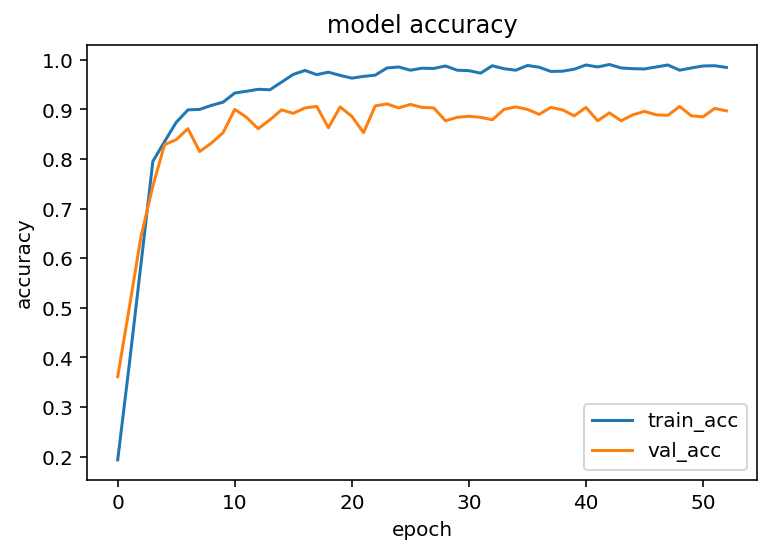

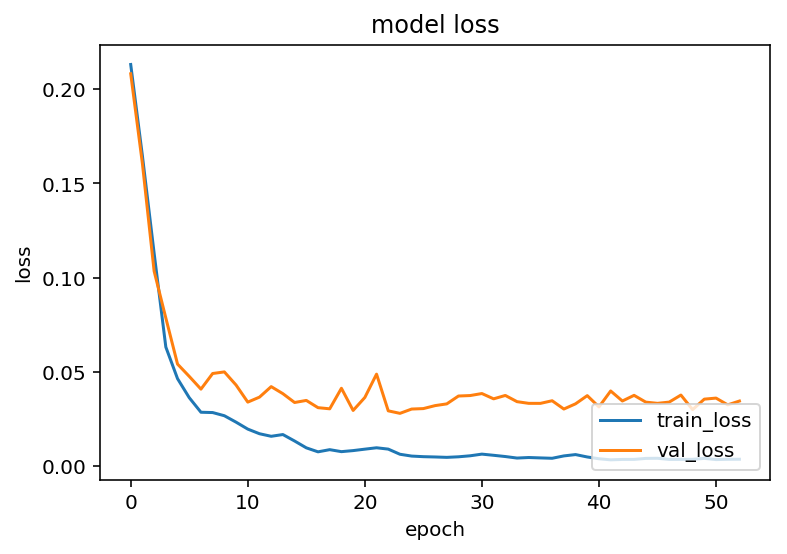

100%|██████████| 20/20 [00:03<00:00,  6.40it/s]
[2017-12-03 12:57:10,303 INFO] TestAcc: 0.9126 | TestLoss: 0.0268 
100%|██████████| 114/114 [51:50<00:00, 27.28s/it] 
[2017-12-03 13:49:00,715 INFO] UnlabeledAcc: 0.9095 | UnlabeledLoss: 0.0291 
[2017-12-03 13:49:02,282 INFO] Epoch: 0 | TrainAcc: 0.2025 | TrainLoss: 0.2233
[2017-12-03 13:49:02,745 INFO] Epoch: 0 | ValAcc: 0.1930 | ValLoss: 0.2189 

[2017-12-03 13:49:04,603 INFO] Epoch: 1 | TrainAcc: 0.3515 | TrainLoss: 0.1800
[2017-12-03 13:49:05,168 INFO] Epoch: 1 | ValAcc: 0.3330 | ValLoss: 0.1751 

[2017-12-03 13:49:06,882 INFO] Epoch: 2 | TrainAcc: 0.5085 | TrainLoss: 0.1304
[2017-12-03 13:49:07,338 INFO] Epoch: 2 | ValAcc: 0.5530 | ValLoss: 0.1295 

[2017-12-03 13:49:09,261 INFO] Epoch: 3 | TrainAcc: 0.6970 | TrainLoss: 0.0829
[2017-12-03 13:49:09,962 INFO] Epoch: 3 | ValAcc: 0.6190 | ValLoss: 0.1074 

[2017-12-03 13:49:11,986 INFO] Epoch: 4 | TrainAcc: 0.8295 | TrainLoss: 0.0487
[2017-12-03 13:49:12,497 INFO] Epoch: 4 | ValAcc: 0.78

[2017-12-03 13:50:54,115 INFO] Epoch: 50 | ValAcc: 0.8700 | ValLoss: 0.0448 

[2017-12-03 13:50:55,423 INFO] Epoch: 51 | TrainAcc: 0.9860 | TrainLoss: 0.0035
[2017-12-03 13:50:55,824 INFO] Epoch: 51 | ValAcc: 0.8770 | ValLoss: 0.0404 

[2017-12-03 13:50:57,136 INFO] Epoch: 52 | TrainAcc: 0.9875 | TrainLoss: 0.0035
[2017-12-03 13:50:57,542 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0368 

[2017-12-03 13:50:58,985 INFO] Epoch: 53 | TrainAcc: 0.9845 | TrainLoss: 0.0035
[2017-12-03 13:50:59,335 INFO] Epoch: 53 | ValAcc: 0.8760 | ValLoss: 0.0413 

[2017-12-03 13:51:00,576 INFO] Epoch: 54 | TrainAcc: 0.9795 | TrainLoss: 0.0044
[2017-12-03 13:51:00,923 INFO] Epoch: 54 | ValAcc: 0.8720 | ValLoss: 0.0406 

[2017-12-03 13:51:02,321 INFO] Epoch: 55 | TrainAcc: 0.9815 | TrainLoss: 0.0049
[2017-12-03 13:51:02,702 INFO] Epoch: 55 | ValAcc: 0.8840 | ValLoss: 0.0422 

[2017-12-03 13:51:03,994 INFO] Epoch: 56 | TrainAcc: 0.9820 | TrainLoss: 0.0043
[2017-12-03 13:51:04,335 INFO] Epoch: 56 | ValAcc: 0

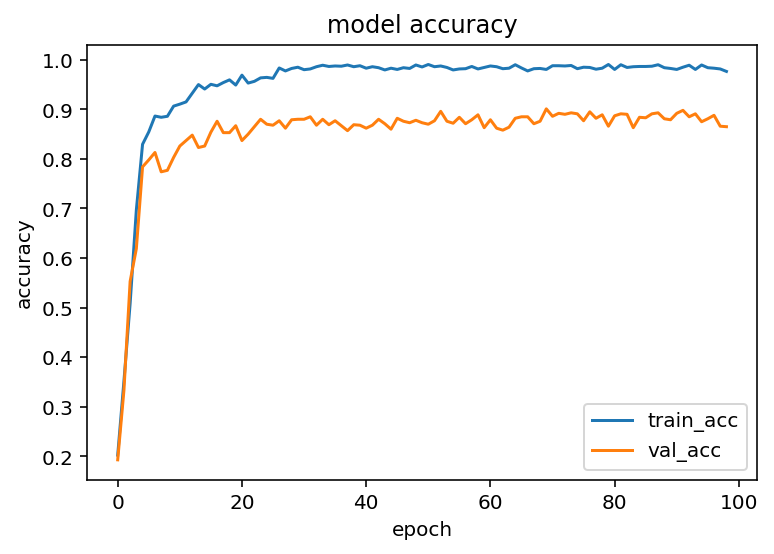

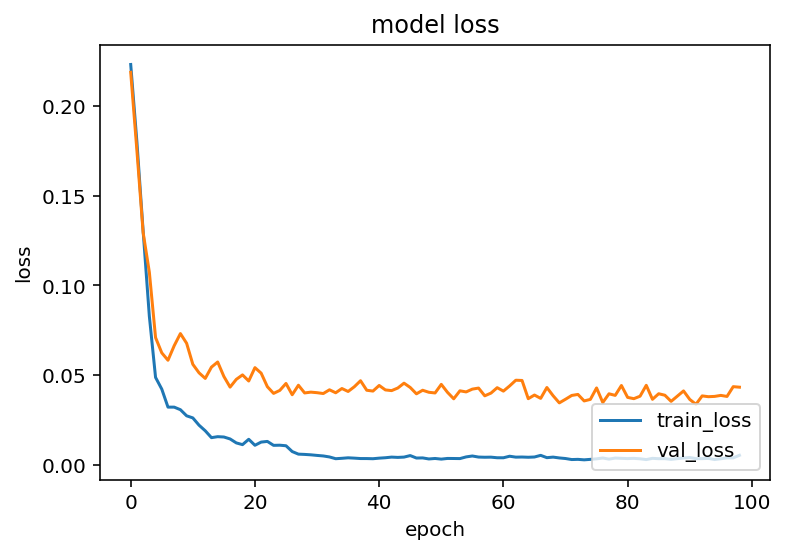

100%|██████████| 20/20 [00:02<00:00,  8.42it/s]
[2017-12-03 13:52:18,378 INFO] TestAcc: 0.9128 | TestLoss: 0.0292 
100%|██████████| 114/114 [00:11<00:00,  9.60it/s]
[2017-12-03 13:52:30,299 INFO] UnlabeledAcc: 0.9065 | UnlabeledLoss: 0.0311 
[2017-12-03 13:52:31,587 INFO] Epoch: 0 | TrainAcc: 0.1865 | TrainLoss: 0.2214
[2017-12-03 13:52:31,962 INFO] Epoch: 0 | ValAcc: 0.3450 | ValLoss: 0.2169 

[2017-12-03 13:52:33,299 INFO] Epoch: 1 | TrainAcc: 0.4190 | TrainLoss: 0.1720
[2017-12-03 13:52:33,677 INFO] Epoch: 1 | ValAcc: 0.4780 | ValLoss: 0.1568 

[2017-12-03 13:52:35,044 INFO] Epoch: 2 | TrainAcc: 0.6070 | TrainLoss: 0.1093
[2017-12-03 13:52:35,403 INFO] Epoch: 2 | ValAcc: 0.6120 | ValLoss: 0.1230 

[2017-12-03 13:52:36,679 INFO] Epoch: 3 | TrainAcc: 0.7690 | TrainLoss: 0.0673
[2017-12-03 13:52:37,039 INFO] Epoch: 3 | ValAcc: 0.6340 | ValLoss: 0.1068 

[2017-12-03 13:52:38,337 INFO] Epoch: 4 | TrainAcc: 0.7630 | TrainLoss: 0.0634
[2017-12-03 13:52:38,701 INFO] Epoch: 4 | ValAcc: 0.672

[2017-12-03 13:53:52,853 INFO] Epoch: 50 | ValAcc: 0.8880 | ValLoss: 0.0354 

[2017-12-03 13:53:54,113 INFO] Epoch: 51 | TrainAcc: 0.9805 | TrainLoss: 0.0049
[2017-12-03 13:53:54,458 INFO] Epoch: 51 | ValAcc: 0.9050 | ValLoss: 0.0326 

[2017-12-03 13:53:55,705 INFO] Epoch: 52 | TrainAcc: 0.9800 | TrainLoss: 0.0058
[2017-12-03 13:53:56,056 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0372 

[2017-12-03 13:53:57,311 INFO] Epoch: 53 | TrainAcc: 0.9760 | TrainLoss: 0.0055
[2017-12-03 13:53:57,655 INFO] Epoch: 53 | ValAcc: 0.8790 | ValLoss: 0.0413 

[2017-12-03 13:53:58,919 INFO] Epoch: 54 | TrainAcc: 0.9845 | TrainLoss: 0.0054
[2017-12-03 13:53:59,280 INFO] Epoch: 54 | ValAcc: 0.8910 | ValLoss: 0.0335 

[2017-12-03 13:54:00,544 INFO] Epoch: 55 | TrainAcc: 0.9805 | TrainLoss: 0.0053
[2017-12-03 13:54:00,942 INFO] Epoch: 55 | ValAcc: 0.8710 | ValLoss: 0.0417 

[2017-12-03 13:54:02,222 INFO] Epoch: 56 | TrainAcc: 0.9775 | TrainLoss: 0.0053
[2017-12-03 13:54:02,592 INFO] Epoch: 56 | ValAcc: 0

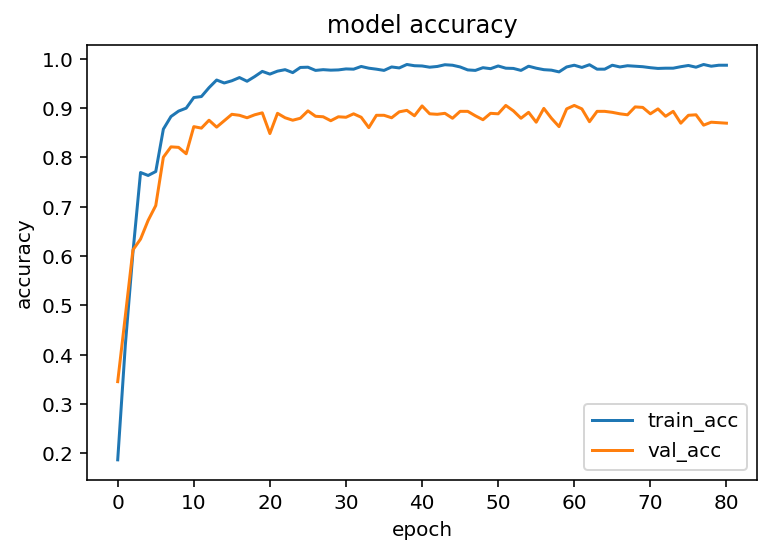

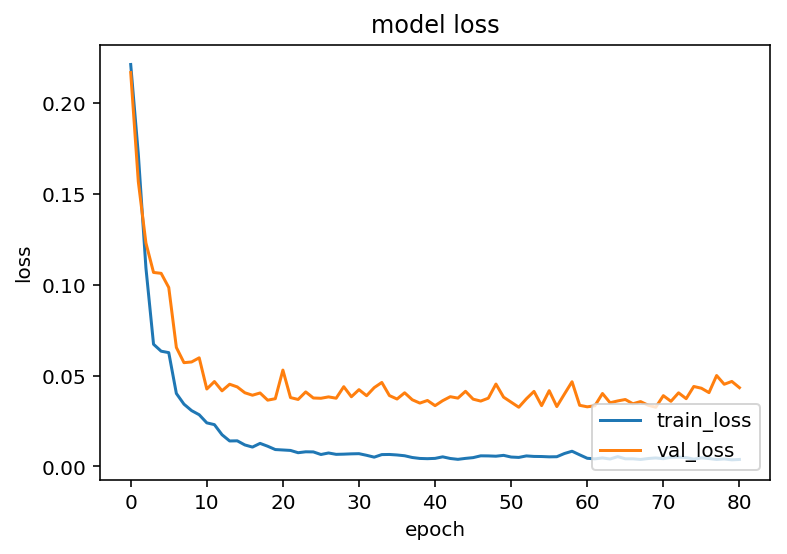

100%|██████████| 20/20 [00:02<00:00,  9.09it/s]
[2017-12-03 13:54:44,352 INFO] TestAcc: 0.9165 | TestLoss: 0.0275 
100%|██████████| 114/114 [00:11<00:00,  9.73it/s]
[2017-12-03 13:54:56,124 INFO] UnlabeledAcc: 0.9033 | UnlabeledLoss: 0.0314 


In [23]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = False
ex_name = 'pseudo_hierarchical'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results_soft = {}
results_soft['test_acc'] = np.empty((trial_times))
results_soft['test_loss'] = np.empty((trial_times))
results_soft['unlabeled_acc'] = np.empty((trial_times))
results_soft['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_soft['test_acc'][i], results_soft['test_loss'][i] = _test(model, test_loader, criterion)
    results_soft['unlabeled_acc'][i], results_soft['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [24]:
results_soft['test_acc']

array([ 0.9185,  0.9129,  0.897 ,  0.9163,  0.9109,  0.9064,  0.9   ,
        0.9126,  0.9128,  0.9165])

In [25]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['test_acc']),
    np.std(results_soft['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_soft['test_loss']),
    np.std(results_soft['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_acc']),
    np.std(results_soft['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_loss']),
    np.std(results_soft['unlabeled_loss'])
))

[2017-12-03 14:29:58,276 INFO] Test Accuracy: 0.9104 ± 0.0068
[2017-12-03 14:29:58,282 INFO] Test Loss: 0.0293 ± 0.0023

[2017-12-03 14:29:58,284 INFO] Unlabeled Accuracy: 0.9017 ± 0.0067
[2017-12-03 14:29:58,286 INFO] Unlabeled Loss: 0.0323 ± 0.0024
